Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with hard-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2 #tolerance for relative variation of parameters

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

In [5]:
scenario = 2
path = "."

In [31]:
from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    #GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')
    GenerateData.set_probas(asfile=False,file_matrix=aux1,file_groups =aux2)

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40
    
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.5669515669515669
Shape (data,annotators):  (2457, 100)
Classes:  3


In [24]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

In [25]:
aux2 = [0.15,0.4,0.45]
aux1 = GenerateData.conf_matrix.copy()

#### Delta Convergence criteria

In [7]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [16]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],8,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])

In [8]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [41]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -16982.106852852135
2 	 -16055.119551551155 	0.5934	0.194807	0.054586
3 	 -15815.252605487487 	0.1723	0.139680	0.014940
4 	 -15628.060040231181 	0.0723	0.132828	0.011836
5 	 -15504.63230494781 	0.0552	0.104531	0.007898
6 	 -15447.361469508925 	0.0606	0.079513	0.003694
7 	 -15421.794734450386 	0.0477	0.062201	0.001655
8 	 -15408.52250273299 	0.0346	0.046602	0.000861
9 	 -15401.148276001979 	0.0251	0.033304	0.000479
10 	 -15397.040948889846 	0.0182	0.022533	0.000267
11 	 -15394.684810764631 	0.0132	0.014821	0.000153
12 	 -15393.190018001947 	0.0097	0.011001	0.000097
13 	 -15392.024738231177 	0.0073	0.007729	0.000076
Class marginals
[0.37 0.34 0.29]


In [42]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.5734635734635735
ACC D&S on train: 0.9226699226699226


In [43]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],8,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over soft-MV")

Trained model over soft-MV


In [44]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],8,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over hard-MV")

Trained model over hard-MV


In [45]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],8,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S")

Trained model over D&S


In [32]:
from code.baseline import RaykarMC

#get representation needed for Raykar
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') 

### Raykar Model (joint predict model)

In [11]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 2.05 sec)	logL: -19204.592	
Iter 2/50 
M step: done,  E step: done //  (in 0.24 sec)	logL: -17826.641	Tol1: 0.07175	Tol2: 0.26210	
Iter 3/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -17345.211	Tol1: 0.02701	Tol2: 0.12063	
Iter 4/50 
M step: done,  E step: done //  (in 0.18 sec)	logL: -17088.066	Tol1: 0.01483	Tol2: 0.06843	
Iter 5/50 
M step: done,  E step: done //  (in 0.15 sec)	logL: -16907.961	Tol1: 0.01054	Tol2: 0.03040	
Iter 6/50 
M step: done,  E step: done //  (in 0.19 sec)	logL: -16751.262	Tol1: 0.00927	Tol2: 0.01243	
Iter 7/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -16604.973	Tol1: 0.00873	Tol2: 0.00521	
Finished training!


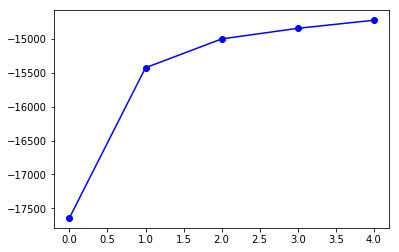

In [37]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

In [14]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
#raykarMC.define_model("keras_shallow") 
raykarMC.define_model("mlp",8,1,BatchN=False,drop=0.2)

logL_hists,i = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.71 sec)	logL: -16573.861	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -15652.877	Tol1: 0.05557	Tol2: 0.29819	
Iter 3/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -15252.674	Tol1: 0.02557	Tol2: 0.08838	
Iter 4/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14927.959	Tol1: 0.02129	Tol2: 0.08851	
Iter 5/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -14719.458	Tol1: 0.01397	Tol2: 0.06398	
Iter 6/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14583.697	Tol1: 0.00922	Tol2: 0.03886	
Iter 7/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14481.594	Tol1: 0.00700	Tol2: 0.02102	
Iter 8/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14399.148	Tol1: 0.00569	Tol2: 0.01113	
Iter 9/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14328.139	Tol1: 0.0049

M step: done,  E step: done //  (in 0.06 sec)	logL: -15029.280	Tol1: 0.00665	Tol2: 0.01951	
Iter 9/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14937.301	Tol1: 0.00612	Tol2: 0.01343	
Iter 10/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14855.955	Tol1: 0.00545	Tol2: 0.01041	
Iter 11/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -14778.007	Tol1: 0.00525	Tol2: 0.00791	
Finished training!
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 1.23 sec)	logL: -17215.588	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -16425.930	Tol1: 0.04587	Tol2: 0.25717	
Iter 3/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -16202.916	Tol1: 0.01358	Tol2: 0.04155	
Iter 4/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16007.706	Tol1: 0.01205	Tol2: 0.02979	
Iter 5/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -15804.074	Tol1: 0.01272	Tol2: 0.04027	
Iter 6/50 
M 

### Our Proposed

In [33]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs_categorical,"repeat")
#r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[3 0 8]
 [0 2 5]
 [6 0 4]
 ...
 [1 0 7]
 [9 0 6]
 [5 1 2]]
shape: (2457, 3)


In [34]:
%%time

#pre analysis
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Bayesian gaussian mixture say is 5 clusters 
DBSCAN say is 1 clusters
Affinity Propagation say is 4 clusters
Annotators PCA of annotations shape:  (100, 4)
Normalized entropy (0-1) of repeats annotations: 0.579401680828612
CPU times: user 7.09 s, sys: 1.93 s, total: 9.02 s
Wall time: 2.85 s


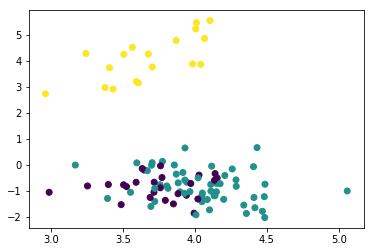

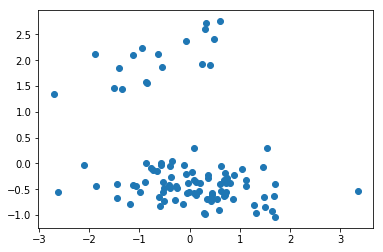

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [35]:
M_seted = 3

In [36]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.000449 mins
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 6.62 sec)	logL: -22374.265	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22064.216	Tol1: 0.01386	Tol2: 0.16178	Tol3: 0.02283	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21762.327	Tol1: 0.01368	Tol2: 0.12223	Tol3: 0.00441	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21441.822	Tol1: 0.01473	Tol2: 0.11544	Tol3: 0.00149	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21110.887	Tol1: 0.01543	Tol2: 0.11341	Tol3: 0.00149	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20780.528	Tol1: 0.01565	Tol2: 0.11437	Tol3: 0.00108	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20477.982	Tol1: 0.014

M step: done,  E step: done //  (in 0.14 sec)	logL: -21898.898	Tol1: 0.01322	Tol2: 0.09930	Tol3: 0.00356	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21596.911	Tol1: 0.01379	Tol2: 0.09787	Tol3: 0.00285	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21283.794	Tol1: 0.01450	Tol2: 0.09820	Tol3: 0.00219	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20982.658	Tol1: 0.01415	Tol2: 0.09876	Tol3: 0.00175	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20692.528	Tol1: 0.01383	Tol2: 0.10025	Tol3: 0.00132	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20419.157	Tol1: 0.01321	Tol2: 0.09973	Tol3: 0.00166	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20176.574	Tol1: 0.01188	Tol2: 0.09685	Tol3: 0.00209	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19952.038	Tol1: 0.01113	Tol2: 0.09219	Tol3: 0.00187	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19757.961	Tol1: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -19358.336	Tol1: 0.00230	Tol2: 0.05659	Tol3: 0.00355	
Iter 30/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19317.129	Tol1: 0.00213	Tol2: 0.05318	Tol3: 0.00307	
Iter 31/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19280.506	Tol1: 0.00190	Tol2: 0.05016	Tol3: 0.00327	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19243.752	Tol1: 0.00191	Tol2: 0.04651	Tol3: 0.00277	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19207.737	Tol1: 0.00187	Tol2: 0.04204	Tol3: 0.00253	
Iter 34/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19172.064	Tol1: 0.00186	Tol2: 0.03868	Tol3: 0.00285	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19139.452	Tol1: 0.00170	Tol2: 0.03556	Tol3: 0.00291	
Iter 36/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19106.122	Tol1: 0.00174	Tol2: 0.03224	Tol3: 0.00292	
Iter 37/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19076.775	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -19250.133	Tol1: 0.00130	Tol2: 0.03094	Tol3: 0.00167	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19224.764	Tol1: 0.00132	Tol2: 0.02785	Tol3: 0.00138	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19203.178	Tol1: 0.00112	Tol2: 0.02547	Tol3: 0.00143	
Iter 29/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19181.244	Tol1: 0.00114	Tol2: 0.02512	Tol3: 0.00149	
Iter 30/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19169.922	Tol1: 0.00059	Tol2: 0.02523	Tol3: 0.00150	
Iter 31/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19153.876	Tol1: 0.00084	Tol2: 0.02347	Tol3: 0.00094	
Iter 32/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19143.818	Tol1: 0.00053	Tol2: 0.02359	Tol3: 0.00122	
Iter 33/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19133.939	Tol1: 0.00052	Tol2: 0.02250	Tol3: 0.00089	
Iter 34/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19125.918	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -20575.888	Tol1: 0.01667	Tol2: 0.10221	Tol3: 0.00541	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20266.979	Tol1: 0.01501	Tol2: 0.10341	Tol3: 0.00544	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19992.844	Tol1: 0.01353	Tol2: 0.09798	Tol3: 0.00470	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19766.014	Tol1: 0.01135	Tol2: 0.08945	Tol3: 0.00452	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19590.608	Tol1: 0.00887	Tol2: 0.07899	Tol3: 0.00438	
Iter 15/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19456.342	Tol1: 0.00685	Tol2: 0.06738	Tol3: 0.00378	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19357.232	Tol1: 0.00509	Tol2: 0.05637	Tol3: 0.00310	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19283.148	Tol1: 0.00383	Tol2: 0.04786	Tol3: 0.00238	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19229.480	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -19977.142	Tol1: 0.01344	Tol2: 0.11446	Tol3: 0.00693	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19759.162	Tol1: 0.01091	Tol2: 0.10531	Tol3: 0.00662	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19582.982	Tol1: 0.00892	Tol2: 0.09161	Tol3: 0.00572	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19445.867	Tol1: 0.00700	Tol2: 0.07681	Tol3: 0.00446	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19329.236	Tol1: 0.00600	Tol2: 0.06284	Tol3: 0.00309	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19235.657	Tol1: 0.00484	Tol2: 0.05022	Tol3: 0.00270	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19162.191	Tol1: 0.00382	Tol2: 0.03888	Tol3: 0.00193	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19104.989	Tol1: 0.00299	Tol2: 0.03145	Tol3: 0.00168	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19060.284	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -20188.512	Tol1: 0.01352	Tol2: 0.12136	Tol3: 0.00385	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19960.481	Tol1: 0.01130	Tol2: 0.11658	Tol3: 0.00328	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19785.751	Tol1: 0.00875	Tol2: 0.10728	Tol3: 0.00275	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19659.151	Tol1: 0.00640	Tol2: 0.09376	Tol3: 0.00243	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19568.256	Tol1: 0.00462	Tol2: 0.07729	Tol3: 0.00197	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19500.656	Tol1: 0.00345	Tol2: 0.06209	Tol3: 0.00184	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19449.055	Tol1: 0.00265	Tol2: 0.04984	Tol3: 0.00190	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19412.621	Tol1: 0.00187	Tol2: 0.03992	Tol3: 0.00192	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19386.483	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -19331.668	Tol1: 0.00334	Tol2: 0.04084	Tol3: 0.00039	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19287.394	Tol1: 0.00229	Tol2: 0.02801	Tol3: 0.00047	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19256.920	Tol1: 0.00158	Tol2: 0.01927	Tol3: 0.00123	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.19 sec)	logL: -23021.306	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22585.031	Tol1: 0.01895	Tol2: 0.20355	Tol3: 0.05010	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22327.741	Tol1: 0.01139	Tol2: 0.11782	Tol3: 0.00757	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22071.456	Tol1: 0.01148	Tol2: 0.09977	Tol3: 0.00076	
Iter 5/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.13 sec)	logL: -18986.438	Tol1: 0.00305	Tol2: 0.05460	Tol3: 0.00281	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18940.975	Tol1: 0.00239	Tol2: 0.05162	Tol3: 0.00296	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18898.814	Tol1: 0.00223	Tol2: 0.04724	Tol3: 0.00269	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18864.255	Tol1: 0.00183	Tol2: 0.04389	Tol3: 0.00257	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18834.680	Tol1: 0.00157	Tol2: 0.04027	Tol3: 0.00264	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18805.773	Tol1: 0.00153	Tol2: 0.03724	Tol3: 0.00252	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18786.447	Tol1: 0.00103	Tol2: 0.03446	Tol3: 0.00224	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18767.118	Tol1: 0.00103	Tol2: 0.03133	Tol3: 0.00205	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18748.498	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -20298.638	Tol1: 0.01146	Tol2: 0.09422	Tol3: 0.00350	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20088.844	Tol1: 0.01034	Tol2: 0.08961	Tol3: 0.00328	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19919.448	Tol1: 0.00843	Tol2: 0.08242	Tol3: 0.00315	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19777.811	Tol1: 0.00711	Tol2: 0.07290	Tol3: 0.00258	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19662.586	Tol1: 0.00583	Tol2: 0.06449	Tol3: 0.00224	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19567.124	Tol1: 0.00485	Tol2: 0.05692	Tol3: 0.00206	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19495.890	Tol1: 0.00364	Tol2: 0.05018	Tol3: 0.00201	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19437.480	Tol1: 0.00300	Tol2: 0.04350	Tol3: 0.00154	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19394.626	T

In [37]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.000553 mins
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.5884479  0.8165823  0.20467871]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.65 sec)	logL: -22056.502	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21725.932	Tol1: 0.01499	Tol2: 0.18743	Tol3: 0.02543	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21445.795	Tol1: 0.01289	Tol2: 0.12446	Tol3: 0.00541	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21170.831	Tol1: 0.01282	Tol2: 0.10591	Tol3: 0.00298	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20898.689	Tol1: 0.01285	Tol2: 0.09889	Tol3: 0.00350	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20637.566	Tol1: 0.01249	Tol2: 0.09394	Tol3: 0.00338	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL

M step: done,  E step: done //  (in 0.14 sec)	logL: -19022.943	Tol1: 0.00208	Tol2: 0.02874	Tol3: 0.00096	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18988.900	Tol1: 0.00179	Tol2: 0.02320	Tol3: 0.00072	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -18967.400	Tol1: 0.00113	Tol2: 0.01939	Tol3: 0.00066	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.9621332  0.83973885 0.09340753]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.84 sec)	logL: -23120.891	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22650.102	Tol1: 0.02036	Tol2: 0.21401	Tol3: 0.02569	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22233.381	Tol1: 0.01840	Tol2: 0.12122	Tol3: 0.00933	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21826.660	Tol1: 0.01829	Tol2: 0.09978	Tol3: 0.00902	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.14 sec)	logL: -19814.901	Tol1: 0.01037	Tol2: 0.06061	Tol3: 0.00485	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19656.694	Tol1: 0.00798	Tol2: 0.05243	Tol3: 0.00453	
Iter 15/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19543.770	Tol1: 0.00574	Tol2: 0.04275	Tol3: 0.00371	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19451.118	Tol1: 0.00474	Tol2: 0.03526	Tol3: 0.00291	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19374.078	Tol1: 0.00396	Tol2: 0.02957	Tol3: 0.00245	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19313.206	Tol1: 0.00314	Tol2: 0.02469	Tol3: 0.00211	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19266.873	Tol1: 0.00240	Tol2: 0.01939	Tol3: 0.00181	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.32786545 0.28776094 0.96866935]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q esti

M step: done,  E step: done //  (in 0.16 sec)	logL: -21282.775	Tol1: 0.02210	Tol2: 0.23007	Tol3: 0.03539	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20966.216	Tol1: 0.01487	Tol2: 0.14095	Tol3: 0.01387	
Iter 4/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -20704.444	Tol1: 0.01249	Tol2: 0.11246	Tol3: 0.00689	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20492.798	Tol1: 0.01022	Tol2: 0.09345	Tol3: 0.00438	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20313.625	Tol1: 0.00874	Tol2: 0.07716	Tol3: 0.00310	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20168.341	Tol1: 0.00715	Tol2: 0.06140	Tol3: 0.00343	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20034.799	Tol1: 0.00662	Tol2: 0.04996	Tol3: 0.00258	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19927.841	Tol1: 0.00534	Tol2: 0.04184	Tol3: 0.00243	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19826.711	Tol1: 0.

M step: done,  E step: done //  (in 0.15 sec)	logL: -20285.070	Tol1: 0.01097	Tol2: 0.08679	Tol3: 0.00322	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20100.133	Tol1: 0.00912	Tol2: 0.07402	Tol3: 0.00222	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19949.826	Tol1: 0.00748	Tol2: 0.06342	Tol3: 0.00160	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19834.910	Tol1: 0.00576	Tol2: 0.05412	Tol3: 0.00102	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19752.011	Tol1: 0.00418	Tol2: 0.04582	Tol3: 0.00071	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19692.763	Tol1: 0.00300	Tol2: 0.03829	Tol3: 0.00049	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19651.715	Tol1: 0.00208	Tol2: 0.03214	Tol3: 0.00034	
Iter 14/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19620.790	Tol1: 0.00157	Tol2: 0.02846	Tol3: 0.00023	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19592.268	Tol

M step: done,  E step: done //  (in 0.16 sec)	logL: -18843.817	Tol1: 0.00110	Tol2: 0.02031	Tol3: 0.00255	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18825.317	Tol1: 0.00098	Tol2: 0.02062	Tol3: 0.00250	
Iter 27/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18808.177	Tol1: 0.00091	Tol2: 0.01853	Tol3: 0.00272	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.985814   0.03858891 0.24148715]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.94 sec)	logL: -23240.830	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22605.423	Tol1: 0.02734	Tol2: 0.28587	Tol3: 0.03493	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22318.670	Tol1: 0.01269	Tol2: 0.14057	Tol3: 0.01383	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22067.104	Tol1: 0.01127	Tol2: 0.10827	Tol3: 0.01237	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.15 sec)	logL: -18975.741	Tol1: 0.00191	Tol2: 0.03481	Tol3: 0.00526	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18943.110	Tol1: 0.00172	Tol2: 0.03520	Tol3: 0.00486	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18912.495	Tol1: 0.00162	Tol2: 0.03495	Tol3: 0.00426	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18885.616	Tol1: 0.00142	Tol2: 0.03702	Tol3: 0.00395	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18862.318	Tol1: 0.00123	Tol2: 0.03552	Tol3: 0.00303	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18838.025	Tol1: 0.00129	Tol2: 0.03407	Tol3: 0.00268	
Iter 30/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18816.536	Tol1: 0.00114	Tol2: 0.03535	Tol3: 0.00235	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18799.262	Tol1: 0.00092	Tol2: 0.03608	Tol3: 0.00211	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -18783.111	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -18753.685	Tol1: 0.00037	Tol2: 0.02195	Tol3: 0.00146	
Iter 49/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18749.344	Tol1: 0.00023	Tol2: 0.02052	Tol3: 0.00143	
Iter 50/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18744.622	Tol1: 0.00025	Tol2: 0.01854	Tol3: 0.00124	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.88765246 0.49386537 0.16143376]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.34 sec)	logL: -24217.146	
Iter 2/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23424.745	Tol1: 0.03272	Tol2: 0.31011	Tol3: 0.04827	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23105.363	Tol1: 0.01363	Tol2: 0.12411	Tol3: 0.02010	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22867.905	Tol1: 0.01028	Tol2: 0.07040	Tol3: 0.00894	
Iter 5/50
M step: done

M step: done,  E step: done //  (in 0.15 sec)	logL: -20988.638	Tol1: 0.01798	Tol2: 0.08978	Tol3: 0.00849	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20614.065	Tol1: 0.01785	Tol2: 0.09472	Tol3: 0.00793	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20272.796	Tol1: 0.01656	Tol2: 0.09614	Tol3: 0.00708	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19987.518	Tol1: 0.01407	Tol2: 0.09170	Tol3: 0.00622	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19750.742	Tol1: 0.01185	Tol2: 0.08216	Tol3: 0.00511	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19570.684	Tol1: 0.00912	Tol2: 0.07057	Tol3: 0.00462	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19438.849	Tol1: 0.00674	Tol2: 0.05761	Tol3: 0.00345	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19330.420	Tol1: 0.00558	Tol2: 0.04566	Tol3: 0.00223	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19258.505	To

M step: done,  E step: done //  (in 0.17 sec)	logL: -20909.030	Tol1: 0.01721	Tol2: 0.06325	Tol3: 0.00707	
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20574.132	Tol1: 0.01602	Tol2: 0.05735	Tol3: 0.00514	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20276.521	Tol1: 0.01447	Tol2: 0.05419	Tol3: 0.00393	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20021.709	Tol1: 0.01257	Tol2: 0.05043	Tol3: 0.00303	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19818.694	Tol1: 0.01014	Tol2: 0.04639	Tol3: 0.00243	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19651.177	Tol1: 0.00845	Tol2: 0.04254	Tol3: 0.00156	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19510.368	Tol1: 0.00717	Tol2: 0.03981	Tol3: 0.00113	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19401.559	Tol1: 0.00558	Tol2: 0.03544	Tol3: 0.00078	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19310.988	Tol1

In [38]:
gMixture3 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture3.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture3.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture3.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.232544 mins
Initializing new EM...
Pre-train network on 1 epochs...

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.09911519 0.18903637 0.99015284]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.80 sec)	logL: -22912.534	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22398.242	Tol1: 0.02245	Tol2: 0.23896	Tol3: 0.00417	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21937.015	Tol1: 0.02059	Tol2: 0.14562	Tol3: 0.00464	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21531.617	Tol1: 0.01848	Tol2: 0.11031	Tol3: 0.00461	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21161.984	Tol1: 0.01717	Tol2: 0.09537	Tol3: 0.00392	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20847.502	Tol1: 0.01486	Tol2: 0.09549	Tol3: 0.00302	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20592.891	Tol1: 0.01221	Tol2: 0.09243	Tol3: 0.00164	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20380.413	Tol1: 0.01032	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -20500.266	Tol1: 0.00890	Tol2: 0.08778	Tol3: 0.00593	
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20335.936	Tol1: 0.00802	Tol2: 0.08174	Tol3: 0.00447	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20199.230	Tol1: 0.00672	Tol2: 0.07570	Tol3: 0.00357	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20080.333	Tol1: 0.00589	Tol2: 0.07020	Tol3: 0.00265	
Iter 10/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19970.232	Tol1: 0.00548	Tol2: 0.06583	Tol3: 0.00207	
Iter 11/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19875.839	Tol1: 0.00473	Tol2: 0.06036	Tol3: 0.00206	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19797.187	Tol1: 0.00396	Tol2: 0.05363	Tol3: 0.00188	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19718.600	Tol1: 0.00397	Tol2: 0.04815	Tol3: 0.00226	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19646.900	Tol1

M step: done,  E step: done //  (in 0.17 sec)	logL: -20887.806	Tol1: 0.02144	Tol2: 0.10008	Tol3: 0.00255	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20501.491	Tol1: 0.01849	Tol2: 0.08933	Tol3: 0.00193	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20175.261	Tol1: 0.01591	Tol2: 0.08656	Tol3: 0.00198	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19904.265	Tol1: 0.01343	Tol2: 0.08506	Tol3: 0.00233	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19684.042	Tol1: 0.01106	Tol2: 0.08084	Tol3: 0.00238	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19508.948	Tol1: 0.00890	Tol2: 0.07280	Tol3: 0.00220	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19368.272	Tol1: 0.00721	Tol2: 0.06285	Tol3: 0.00201	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19265.218	Tol1: 0.00532	Tol2: 0.05231	Tol3: 0.00189	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19185.613	Tol1: 

M step: done,  E step: done //  (in 0.16 sec)	logL: -23031.951	Tol1: 0.01430	Tol2: 0.09416	Tol3: 0.00763	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22720.151	Tol1: 0.01354	Tol2: 0.07148	Tol3: 0.00311	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22396.469	Tol1: 0.01425	Tol2: 0.06923	Tol3: 0.00477	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22064.780	Tol1: 0.01481	Tol2: 0.07297	Tol3: 0.00695	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21729.651	Tol1: 0.01519	Tol2: 0.07628	Tol3: 0.00856	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21399.173	Tol1: 0.01521	Tol2: 0.08269	Tol3: 0.00932	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21090.571	Tol1: 0.01442	Tol2: 0.08658	Tol3: 0.00922	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20813.143	Tol1: 0.01315	Tol2: 0.08768	Tol3: 0.00861	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20582.324	Tol1: 

M step: done,  E step: done //  (in 0.21 sec)	logL: -19339.882	Tol1: 0.00451	Tol2: 0.03588	Tol3: 0.00077	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19264.845	Tol1: 0.00388	Tol2: 0.03005	Tol3: 0.00070	
Iter 24/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19202.582	Tol1: 0.00323	Tol2: 0.02533	Tol3: 0.00083	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19153.882	Tol1: 0.00254	Tol2: 0.02221	Tol3: 0.00125	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19109.969	Tol1: 0.00229	Tol2: 0.02028	Tol3: 0.00173	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19070.991	Tol1: 0.00204	Tol2: 0.02047	Tol3: 0.00286	
Iter 28/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19036.953	Tol1: 0.00178	Tol2: 0.01730	Tol3: 0.00266	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.12582077 0.4026631  0.3878067 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q esti

M step: done,  E step: done //  (in 0.15 sec)	logL: -19065.166	Tol1: 0.00198	Tol2: 0.03791	Tol3: 0.00327	
Iter 27/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19030.392	Tol1: 0.00182	Tol2: 0.03596	Tol3: 0.00314	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18998.961	Tol1: 0.00165	Tol2: 0.03470	Tol3: 0.00286	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18970.430	Tol1: 0.00150	Tol2: 0.03387	Tol3: 0.00263	
Iter 30/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18937.384	Tol1: 0.00174	Tol2: 0.03105	Tol3: 0.00218	
Iter 31/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18907.461	Tol1: 0.00158	Tol2: 0.03371	Tol3: 0.00221	
Iter 32/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18884.075	Tol1: 0.00124	Tol2: 0.03465	Tol3: 0.00176	
Iter 33/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -18867.197	Tol1: 0.00089	Tol2: 0.03249	Tol3: 0.00160	
Iter 34/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -18853.146	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -22610.366	Tol1: 0.01312	Tol2: 0.12337	Tol3: 0.01080	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22346.635	Tol1: 0.01166	Tol2: 0.08860	Tol3: 0.00879	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22083.471	Tol1: 0.01178	Tol2: 0.07403	Tol3: 0.00815	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21816.214	Tol1: 0.01210	Tol2: 0.06730	Tol3: 0.00791	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21551.841	Tol1: 0.01212	Tol2: 0.06525	Tol3: 0.00808	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21285.870	Tol1: 0.01234	Tol2: 0.06980	Tol3: 0.00762	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21027.112	Tol1: 0.01216	Tol2: 0.07583	Tol3: 0.00765	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20778.650	Tol1: 0.01182	Tol2: 0.07805	Tol3: 0.00738	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20538.743	Tol1: 0

Pre-train network on 1 epochs... Done!
Lambda by group:  [0.33582678 0.8300241  0.27585205]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.31 sec)	logL: -23827.149	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23092.074	Tol1: 0.03085	Tol2: 0.28355	Tol3: 0.05550	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22847.101	Tol1: 0.01061	Tol2: 0.13331	Tol3: 0.00618	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22669.568	Tol1: 0.00777	Tol2: 0.08304	Tol3: 0.00260	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22482.104	Tol1: 0.00827	Tol2: 0.06483	Tol3: 0.00419	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22278.254	Tol1: 0.00907	Tol2: 0.05822	Tol3: 0.00562	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22047.169	Tol1: 0.01037	Tol2: 0.05648	Tol3: 0.00617	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	

M step: done,  E step: done //  (in 0.16 sec)	logL: -18875.328	Tol1: 0.00044	Tol2: 0.02358	Tol3: 0.00048	
Iter 37/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18865.795	Tol1: 0.00051	Tol2: 0.02017	Tol3: 0.00023	
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18855.153	Tol1: 0.00056	Tol2: 0.02004	Tol3: 0.00041	
Iter 39/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -18848.551	Tol1: 0.00035	Tol2: 0.02126	Tol3: 0.00044	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -18838.107	Tol1: 0.00055	Tol2: 0.01960	Tol3: 0.00093	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [0.7144704  0.2945946  0.21190888]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.35 sec)	logL: -25270.241	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24585.568	Tol1: 0.02709	Tol2: 0.32654	Tol3: 0.01770	
Iter 3/50
M step: do

M step: done,  E step: done //  (in 0.16 sec)	logL: -21451.836	Tol1: 0.01866	Tol2: 0.07032	Tol3: 0.00227	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21052.665	Tol1: 0.01861	Tol2: 0.08150	Tol3: 0.00217	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20680.909	Tol1: 0.01766	Tol2: 0.08771	Tol3: 0.00223	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20354.015	Tol1: 0.01581	Tol2: 0.08959	Tol3: 0.00196	
Iter 10/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20083.501	Tol1: 0.01329	Tol2: 0.08766	Tol3: 0.00157	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19851.027	Tol1: 0.01158	Tol2: 0.08192	Tol3: 0.00121	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19667.795	Tol1: 0.00923	Tol2: 0.07349	Tol3: 0.00119	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19524.730	Tol1: 0.00727	Tol2: 0.06345	Tol3: 0.00161	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19412.574	Tol1

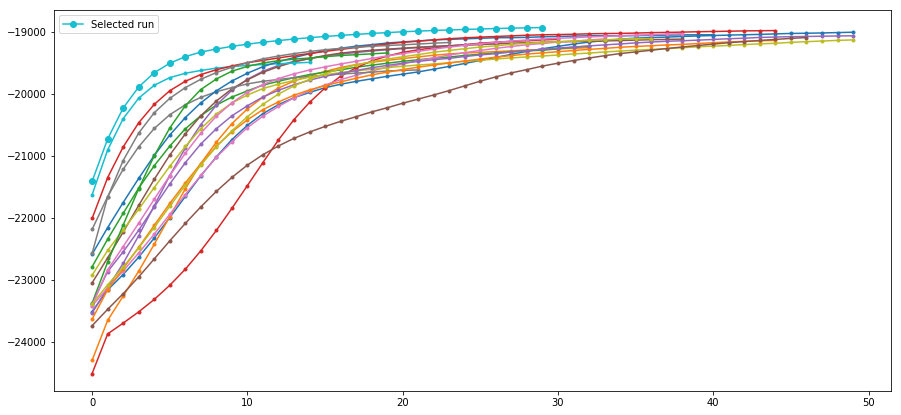

In [74]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

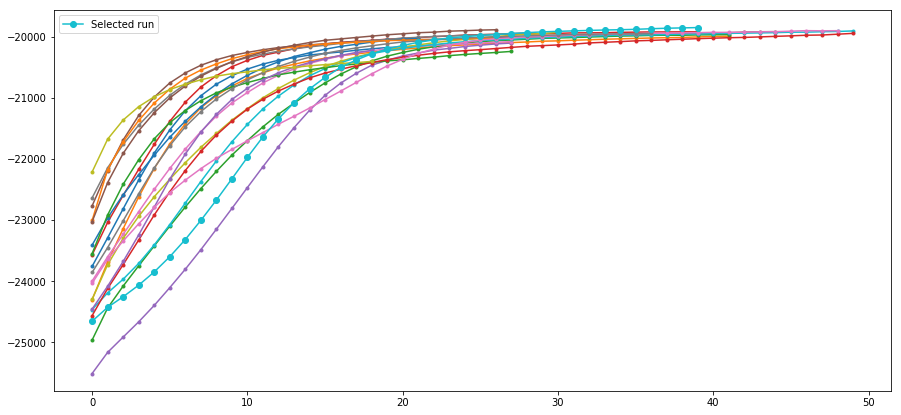

In [32]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [18]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [25]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
Z_train_pred = model_UB.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
Z_test_pred = model_UB.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.923077 |     0.923077 |
+----+--------+------------+--------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.93895 |      0.93895 |
+----+--------+------------+--------------+


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [28]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

NameError: name 'mv_onehot' is not defined

*** Soft-Majority (Train with softMV) ***
Train


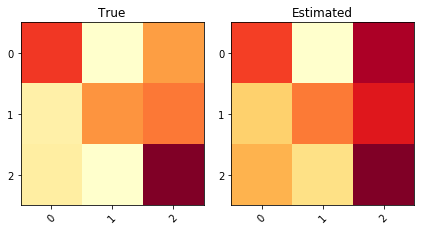

KL divergence: 0.1298	Pearson Correlation between diagonals: 0.9918


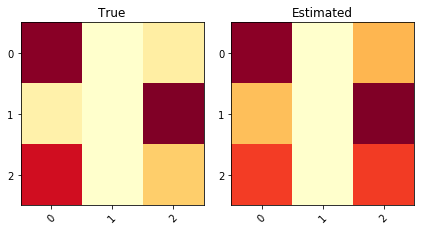

KL divergence: 0.0992	Pearson Correlation between diagonals: 0.8988


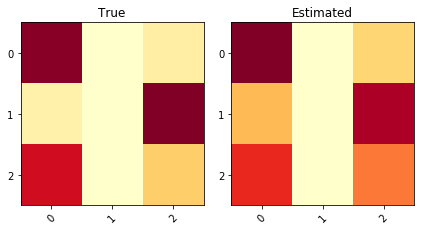

KL divergence: 0.0717	Pearson Correlation between diagonals: 0.9589


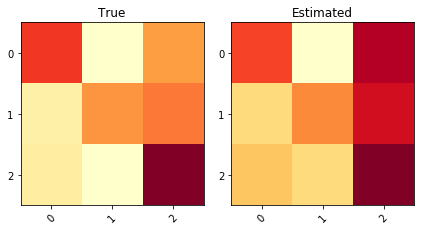

KL divergence: 0.1421	Pearson Correlation between diagonals: 0.9944


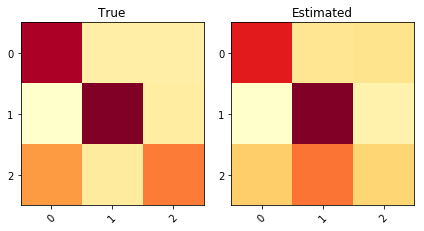

KL divergence: 0.1713	Pearson Correlation between diagonals: 0.9888


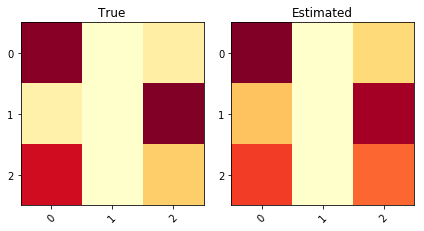

KL divergence: 0.0714	Pearson Correlation between diagonals: 0.9470


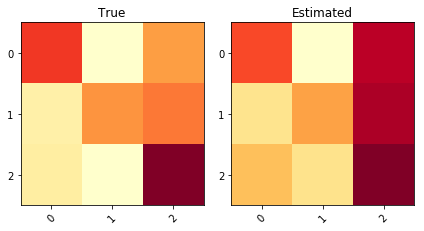

KL divergence: 0.1390	Pearson Correlation between diagonals: 0.9996


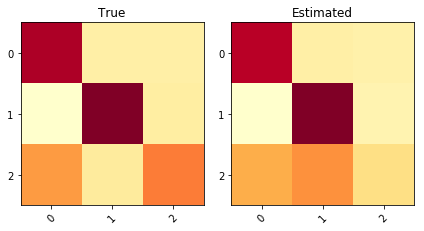

KL divergence: 0.1707	Pearson Correlation between diagonals: 0.9986


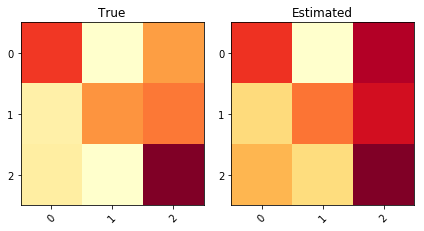

KL divergence: 0.1293	Pearson Correlation between diagonals: 0.9969


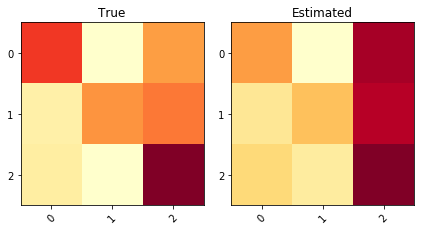

KL divergence: 0.1422	Pearson Correlation between diagonals: 0.9737


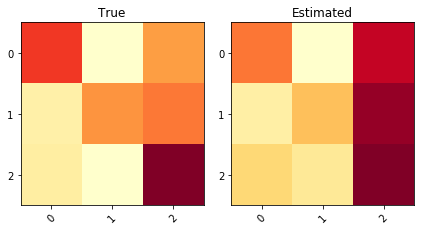

KL divergence: 0.1317	Pearson Correlation between diagonals: 0.9971


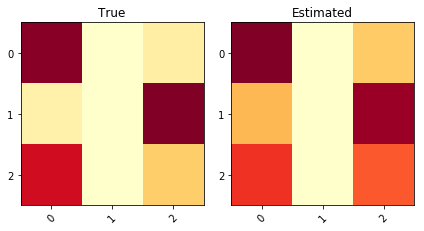

KL divergence: 0.0836	Pearson Correlation between diagonals: 0.9370


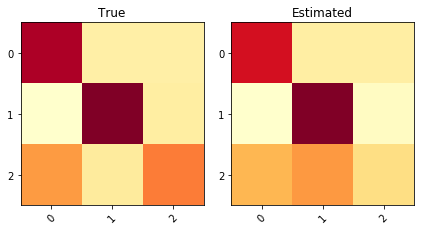

KL divergence: 0.1621	Pearson Correlation between diagonals: 0.9986


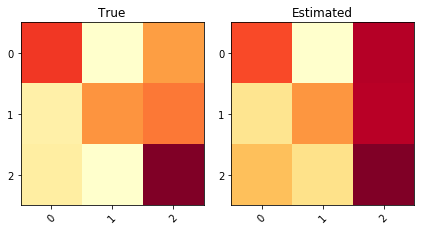

KL divergence: 0.1284	Pearson Correlation between diagonals: 0.9962


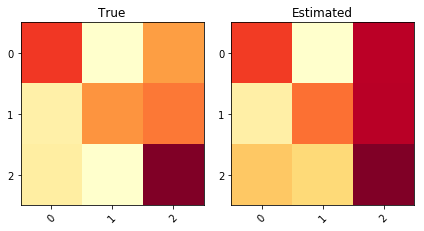

KL divergence: 0.1325	Pearson Correlation between diagonals: 0.9893
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.681319 |     0.681319 |     0.132734 |              0.971539 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.686203 |     0.686203 |
+----+--------+------------+--------------+


In [33]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


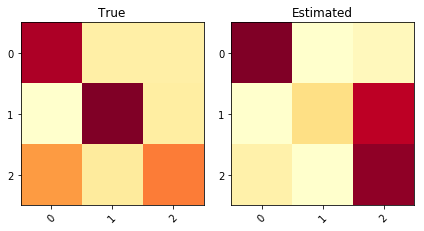

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


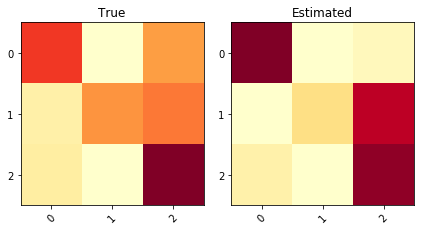

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


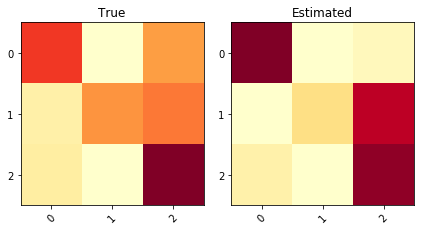

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


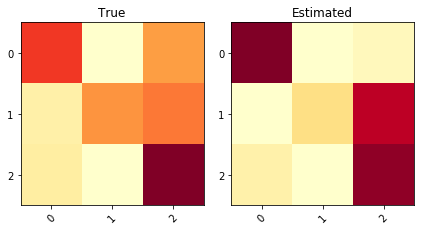

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


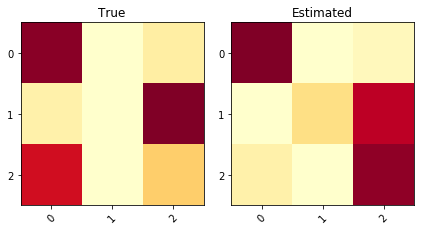

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7486


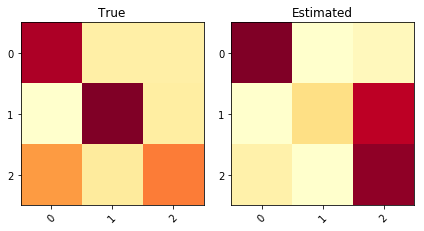

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


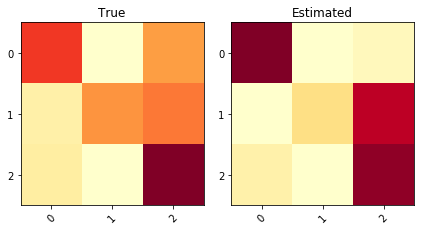

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


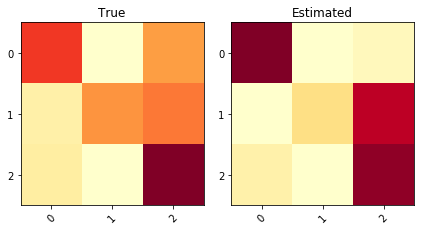

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


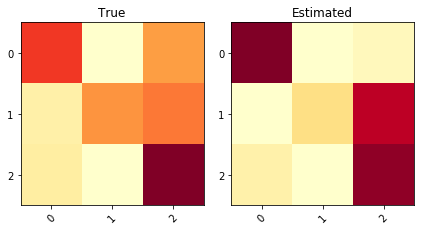

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


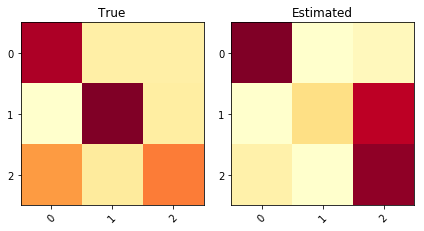

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


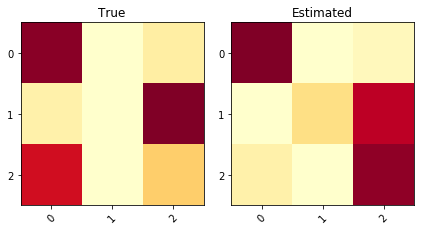

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7486


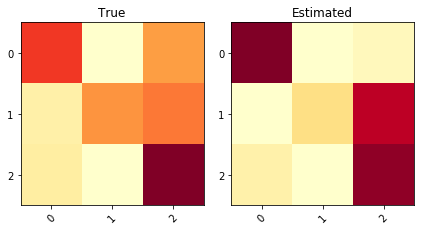

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7722


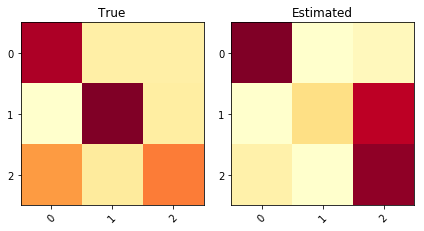

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


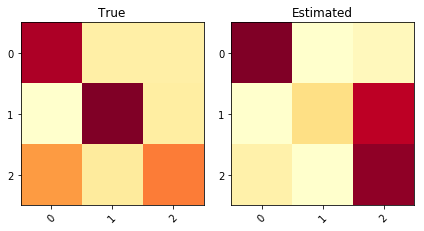

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6286


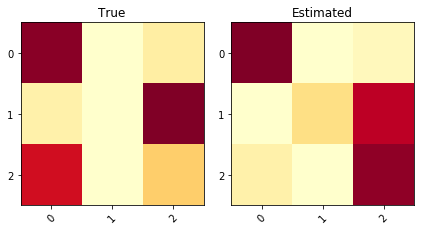

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7486
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.681319 |     0.681319 |      0.59983 |              0.332536 |
+----+--------+------------+--------------+--------------+-----------------------+


In [34]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


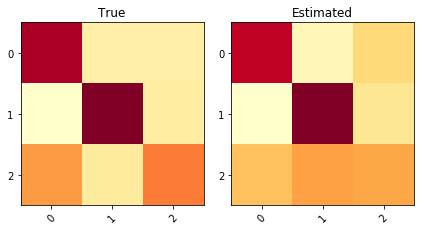

KL divergence: 0.1032	Pearson Correlation between diagonals: 0.9994


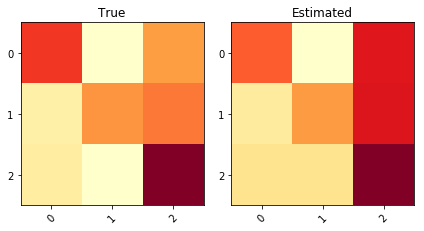

KL divergence: 0.0844	Pearson Correlation between diagonals: 0.9908


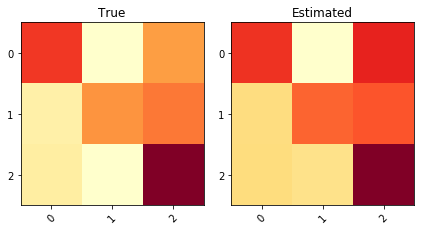

KL divergence: 0.0809	Pearson Correlation between diagonals: 0.9897


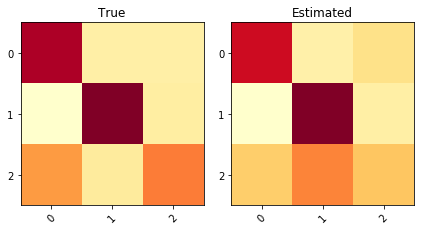

KL divergence: 0.1235	Pearson Correlation between diagonals: 0.9980


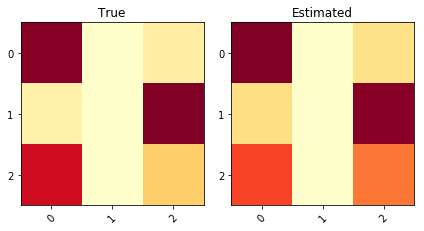

KL divergence: 0.0427	Pearson Correlation between diagonals: 0.9585


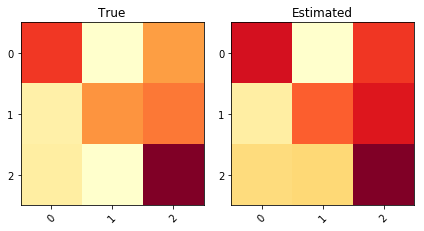

KL divergence: 0.0963	Pearson Correlation between diagonals: 0.9917


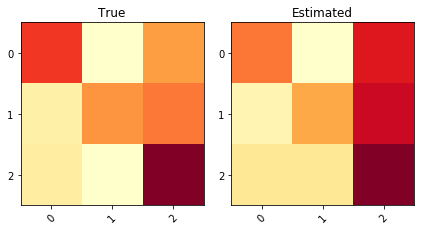

KL divergence: 0.0888	Pearson Correlation between diagonals: 0.9858


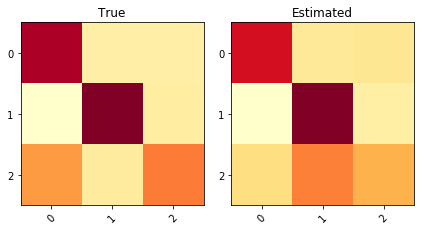

KL divergence: 0.1240	Pearson Correlation between diagonals: 0.9926


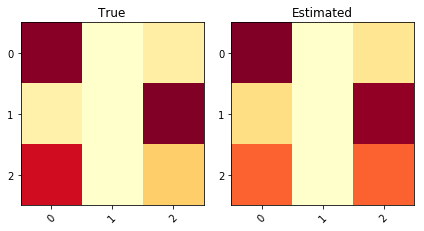

KL divergence: 0.0542	Pearson Correlation between diagonals: 0.9445


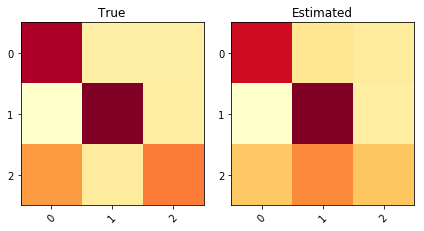

KL divergence: 0.1258	Pearson Correlation between diagonals: 0.9980


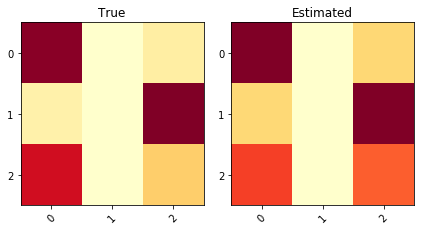

KL divergence: 0.0600	Pearson Correlation between diagonals: 0.9406


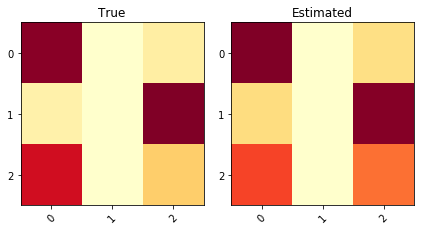

KL divergence: 0.0470	Pearson Correlation between diagonals: 0.9545


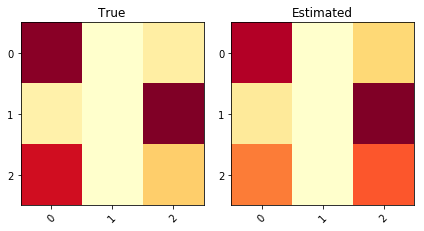

KL divergence: 0.0689	Pearson Correlation between diagonals: 0.9027


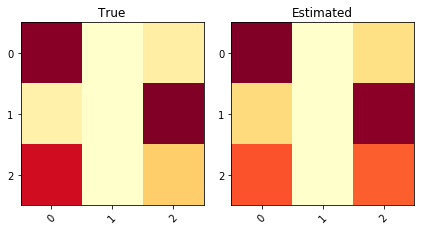

KL divergence: 0.0575	Pearson Correlation between diagonals: 0.9412


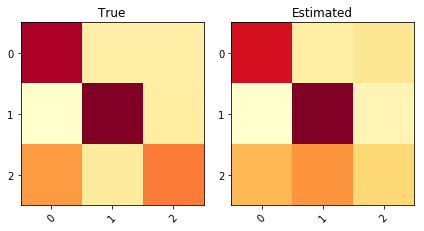

KL divergence: 0.1210	Pearson Correlation between diagonals: 0.9975
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.843712 |     0.843712 |    0.0907799 |              0.974686 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.835165 |     0.835165 |
+----+--------+------------+--------------+


In [35]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


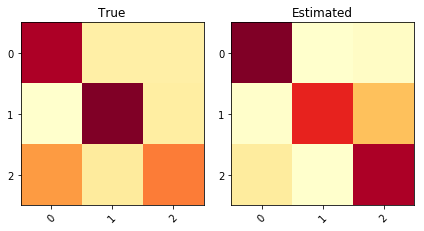

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680


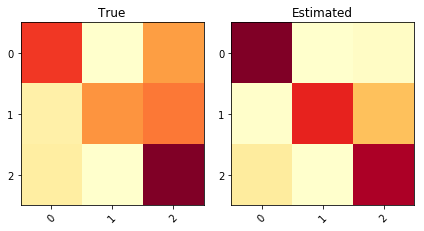

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


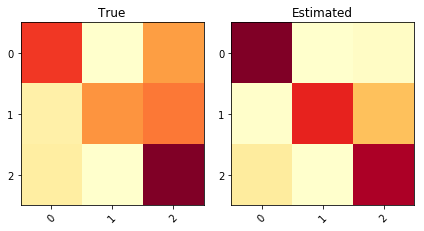

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


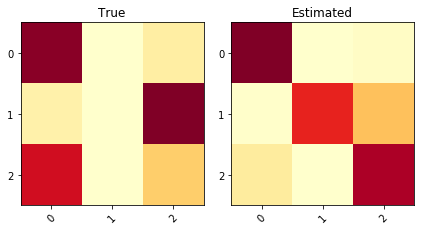

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


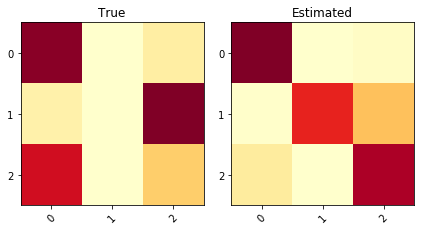

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


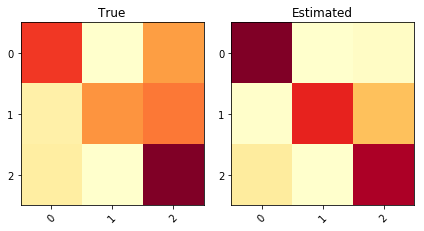

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


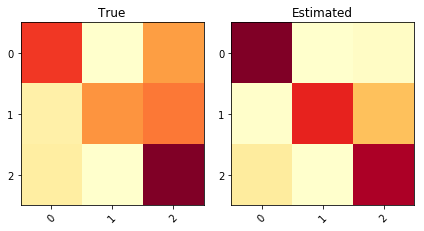

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


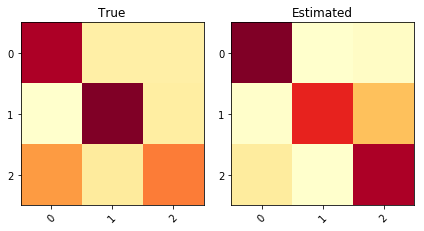

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680


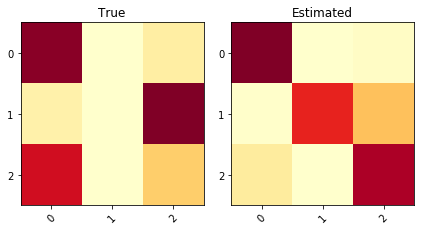

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


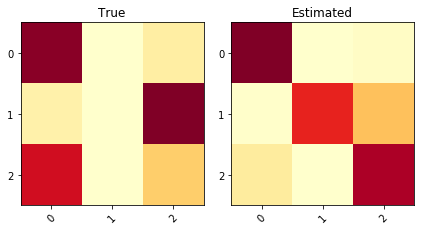

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


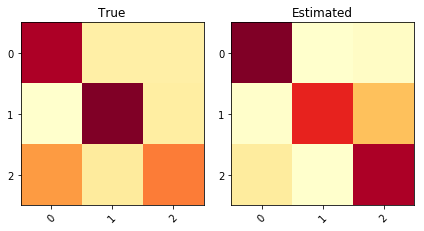

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680


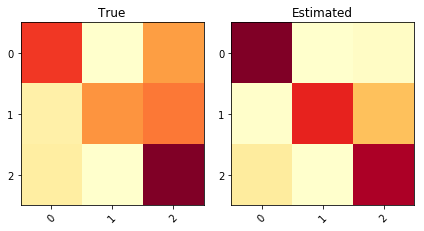

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


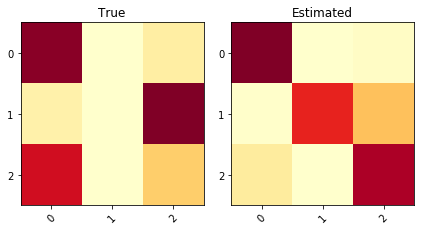

KL divergence: 0.5630	Pearson Correlation between diagonals: 0.9123


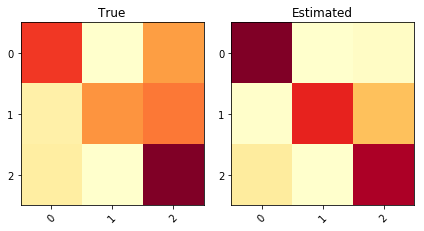

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.5476


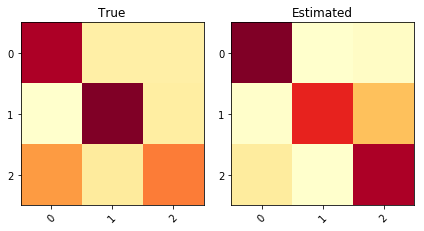

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.3680
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.843712 |     0.843712 |     0.533007 |              0.347628 |
+----+--------+------------+--------------+--------------+-----------------------+


In [36]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


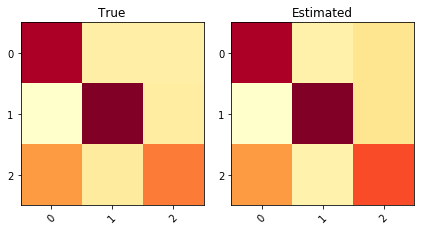

KL divergence: 0.0117	Pearson Correlation between diagonals: 0.9985


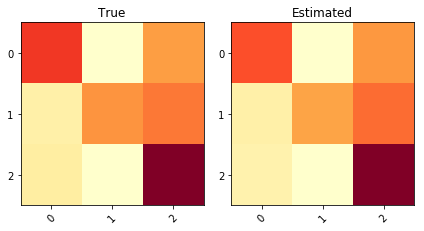

KL divergence: 0.0031	Pearson Correlation between diagonals: 0.9992


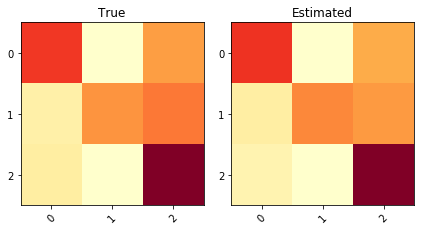

KL divergence: 0.0054	Pearson Correlation between diagonals: 0.9996


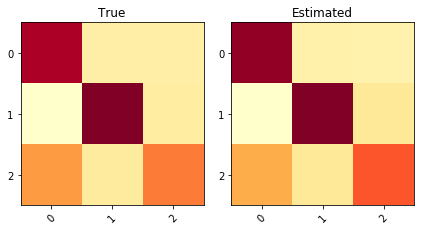

KL divergence: 0.0047	Pearson Correlation between diagonals: 0.9956


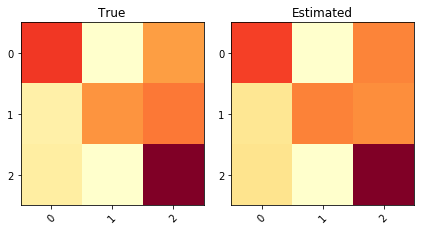

KL divergence: 0.0090	Pearson Correlation between diagonals: 0.9937


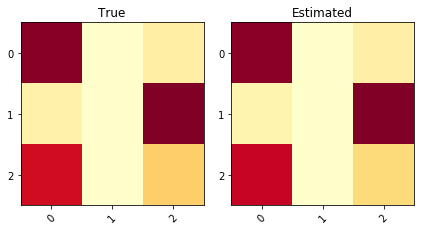

KL divergence: 0.0018	Pearson Correlation between diagonals: 0.9988


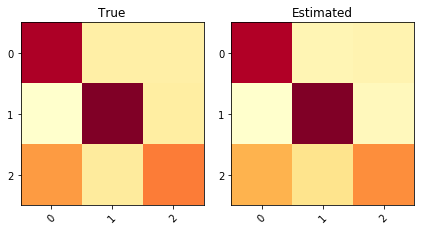

KL divergence: 0.0193	Pearson Correlation between diagonals: 1.0000


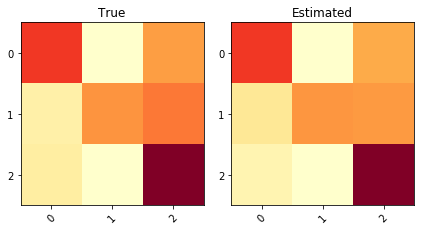

KL divergence: 0.0077	Pearson Correlation between diagonals: 1.0000


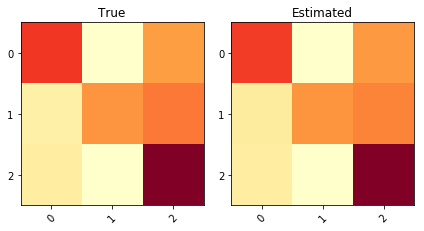

KL divergence: 0.0014	Pearson Correlation between diagonals: 0.9997


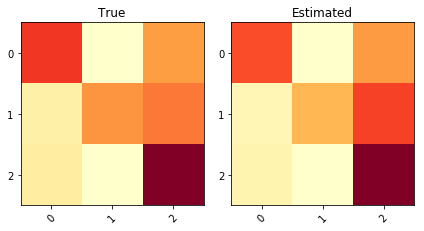

KL divergence: 0.0133	Pearson Correlation between diagonals: 0.9994


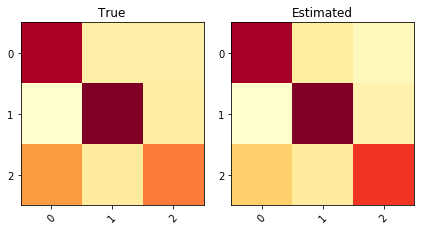

KL divergence: 0.0286	Pearson Correlation between diagonals: 0.9984


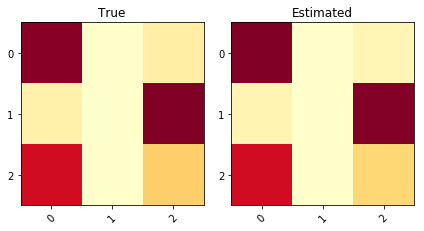

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9991


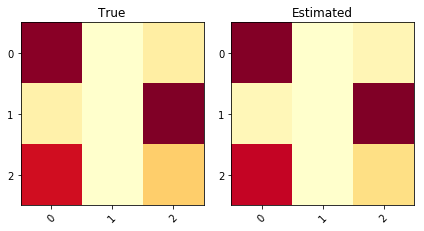

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9963


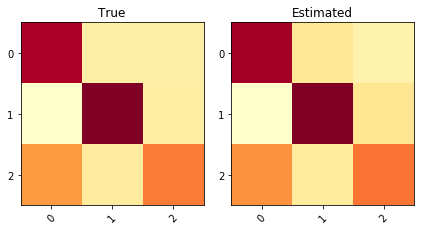

KL divergence: 0.0047	Pearson Correlation between diagonals: 0.9995


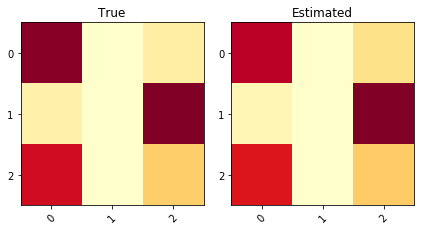

KL divergence: 0.0088	Pearson Correlation between diagonals: 0.9987
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.935694 |     0.935694 |    0.0105937 |              0.992496 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.948718 |     0.948718 |
+----+--------+------------+--------------+


In [37]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


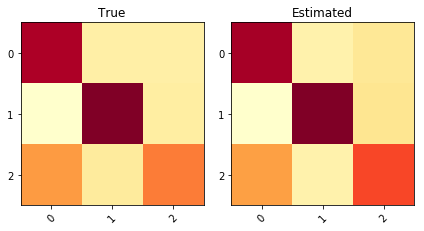

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9999


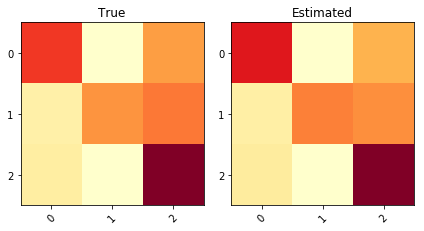

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9935


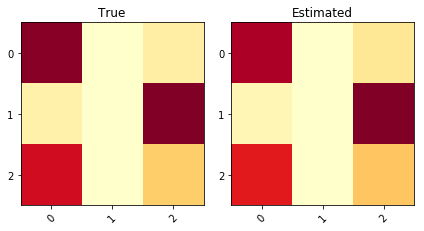

KL divergence: 0.0172	Pearson Correlation between diagonals: 0.9981


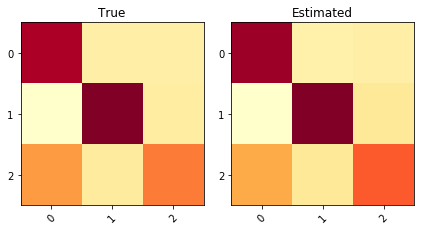

KL divergence: 0.0072	Pearson Correlation between diagonals: 0.9985


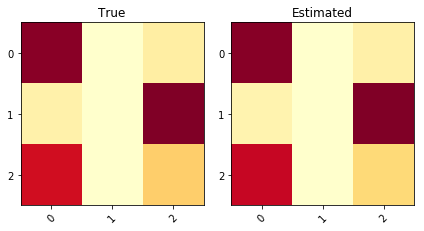

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9989


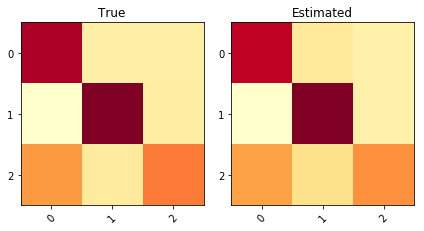

KL divergence: 0.0103	Pearson Correlation between diagonals: 0.9973


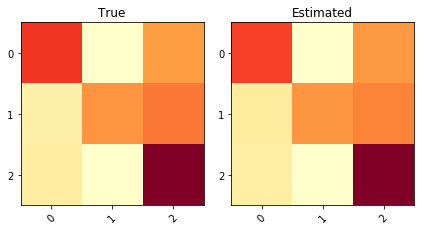

KL divergence: 0.0102	Pearson Correlation between diagonals: 0.9995


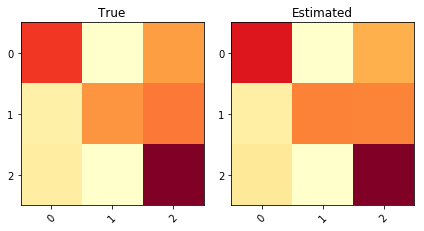

KL divergence: 0.0123	Pearson Correlation between diagonals: 0.9902


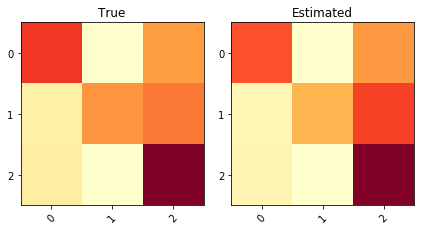

KL divergence: 0.0189	Pearson Correlation between diagonals: 0.9999


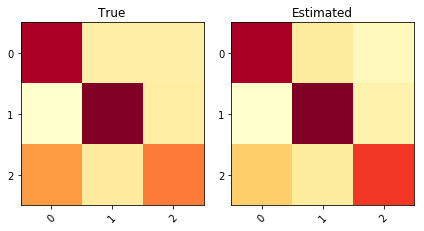

KL divergence: 0.0268	Pearson Correlation between diagonals: 0.9973


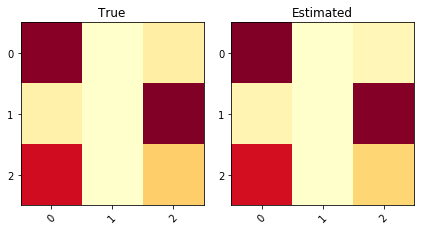

KL divergence: 0.0155	Pearson Correlation between diagonals: 0.9993


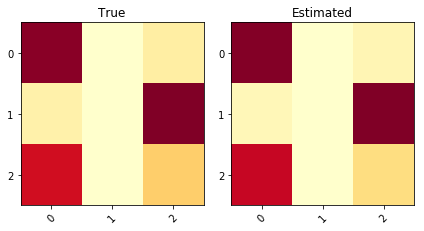

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.9970


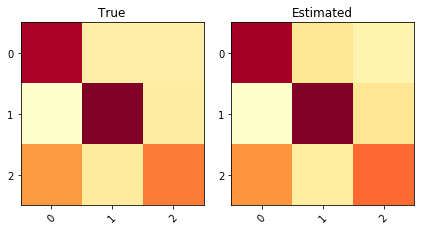

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9996


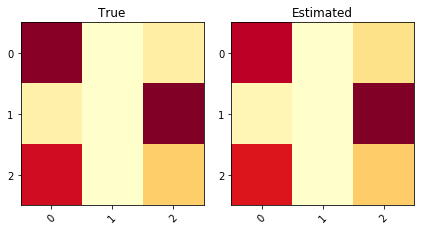

KL divergence: 0.0208	Pearson Correlation between diagonals: 0.9987


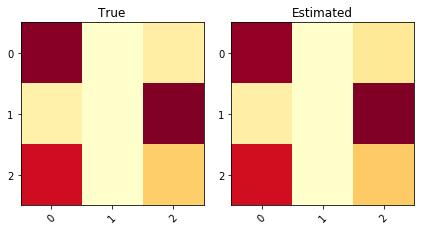

KL divergence: 0.0141	Pearson Correlation between diagonals: 0.9997
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.929182 |     0.929182 |    0.0154835 |              0.992634 |       0.134198 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.693702 |               0.727043 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [38]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


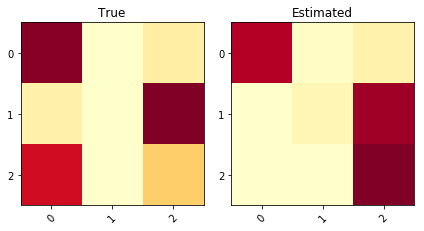

KL divergence: 1.0877	Pearson Correlation between diagonals: 0.6435


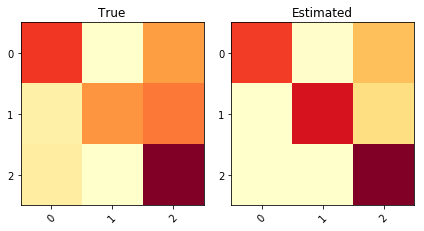

KL divergence: 0.2676	Pearson Correlation between diagonals: 0.7228


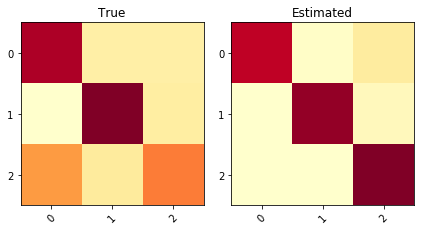

KL divergence: 0.6448	Pearson Correlation between diagonals: -0.5906


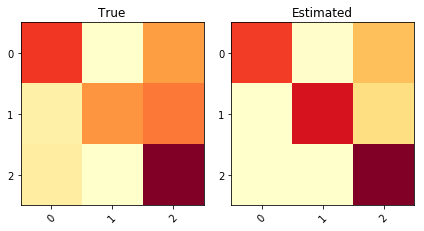

KL divergence: 0.2676	Pearson Correlation between diagonals: 0.7228


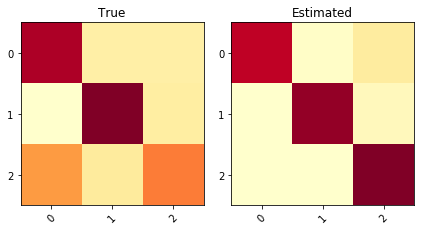

KL divergence: 0.6448	Pearson Correlation between diagonals: -0.5906


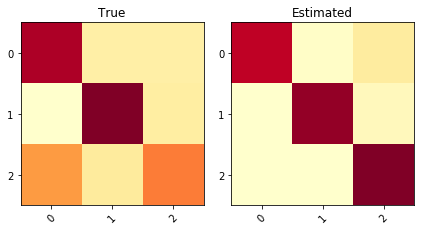

KL divergence: 0.6448	Pearson Correlation between diagonals: -0.5906


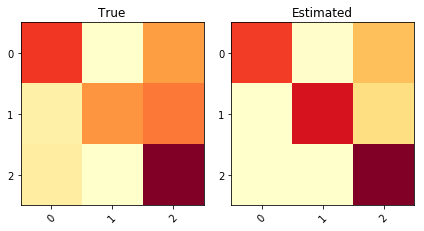

KL divergence: 0.2676	Pearson Correlation between diagonals: 0.7228


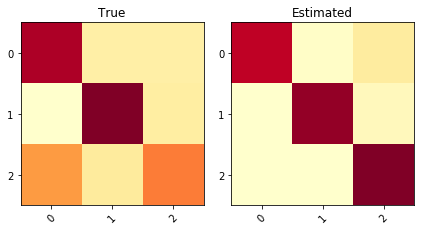

KL divergence: 0.6448	Pearson Correlation between diagonals: -0.5906


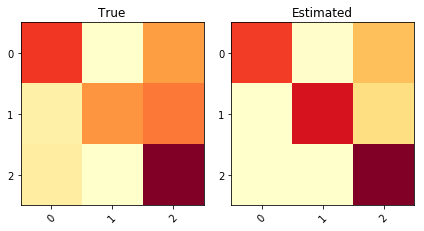

KL divergence: 0.2676	Pearson Correlation between diagonals: 0.7228


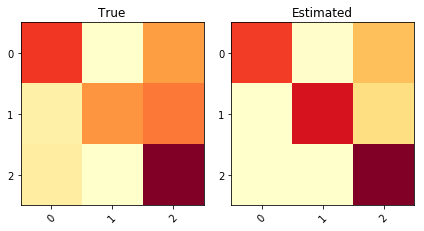

KL divergence: 0.2676	Pearson Correlation between diagonals: 0.7228


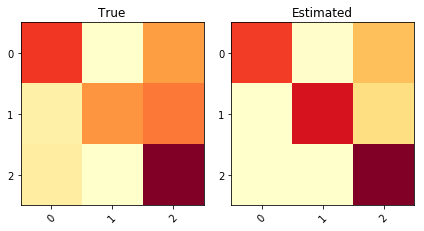

KL divergence: 0.2676	Pearson Correlation between diagonals: 0.7228


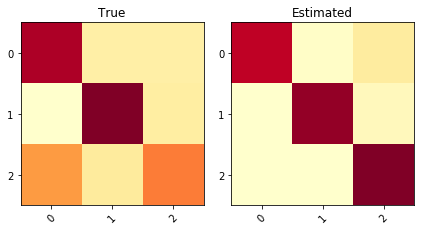

KL divergence: 0.6448	Pearson Correlation between diagonals: -0.5906


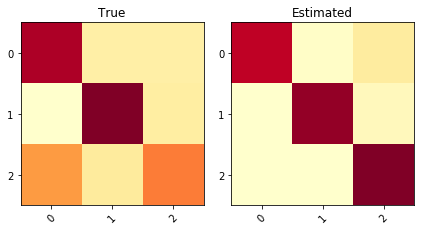

KL divergence: 0.6448	Pearson Correlation between diagonals: -0.5906


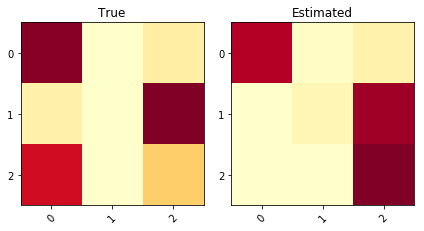

KL divergence: 1.0877	Pearson Correlation between diagonals: 0.6435


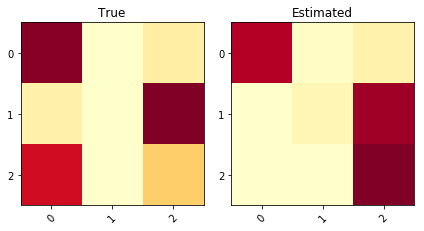

KL divergence: 1.0877	Pearson Correlation between diagonals: 0.6435
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.890924      0.890924       0.52968               0.365442       0.0864868
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.667379                0.722049
====  =======================  ======================
Test


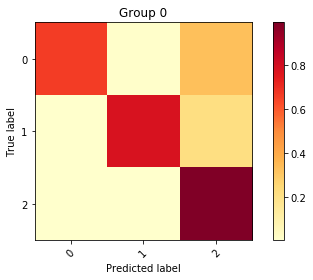

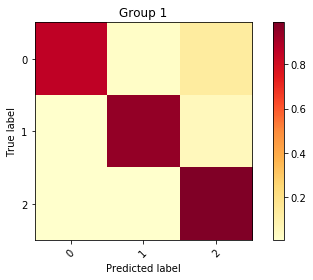

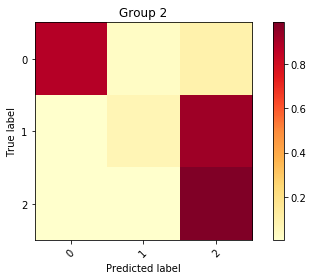

Inertia: 0.09667161231239636
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.553328      55   0.414977     0.813681  0.220295             0.895356    0.7558        0.7558
   1         1  0.281123      28   0.247053     0.931646  0.0726669            0.964306    0.92674       0.92674
   2         2  0.165549      16   0.271419     0.644772  0.931477             0.70557     0.644689      0.644689
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.901099      0.901099


In [36]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


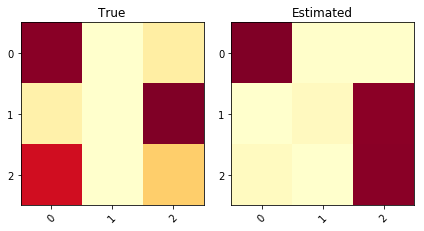

KL divergence: 0.6920	Pearson Correlation between diagonals: 0.7354


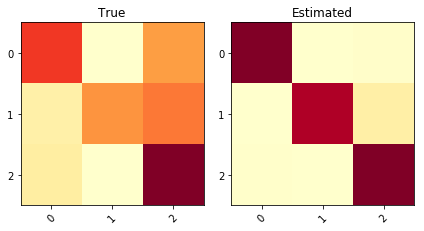

KL divergence: 0.6475	Pearson Correlation between diagonals: 0.8353


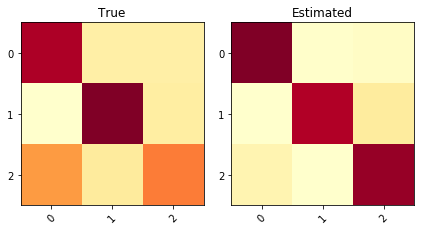

KL divergence: 0.2670	Pearson Correlation between diagonals: -0.2333


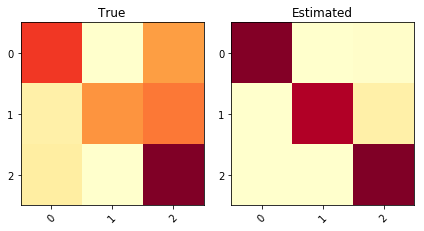

KL divergence: 0.6588	Pearson Correlation between diagonals: 0.8402


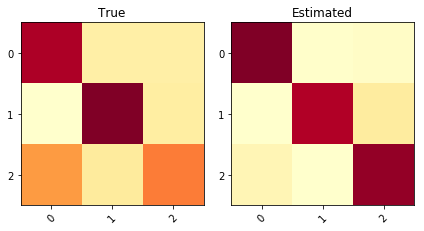

KL divergence: 0.2908	Pearson Correlation between diagonals: -0.3134


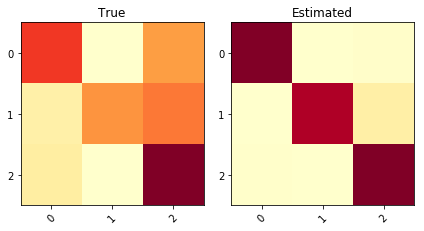

KL divergence: 0.6463	Pearson Correlation between diagonals: 0.8347


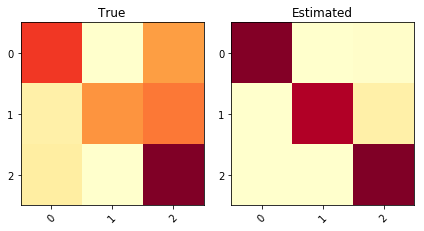

KL divergence: 0.6596	Pearson Correlation between diagonals: 0.8405


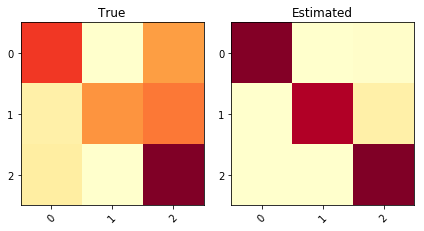

KL divergence: 0.6602	Pearson Correlation between diagonals: 0.8407


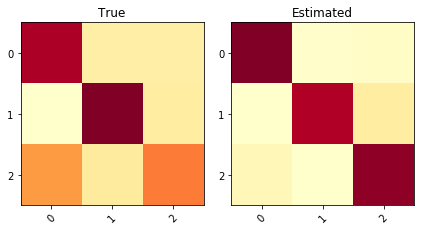

KL divergence: 0.3195	Pearson Correlation between diagonals: -0.3939


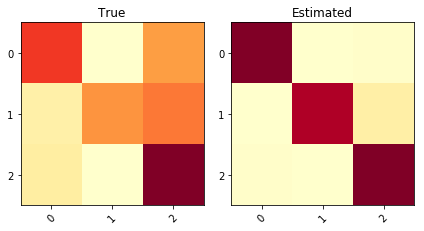

KL divergence: 0.6149	Pearson Correlation between diagonals: 0.8165


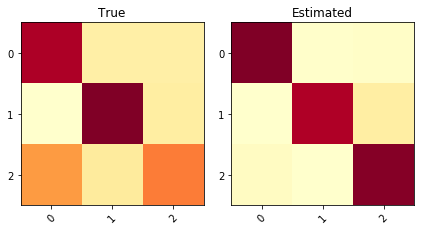

KL divergence: 0.4145	Pearson Correlation between diagonals: -0.5660


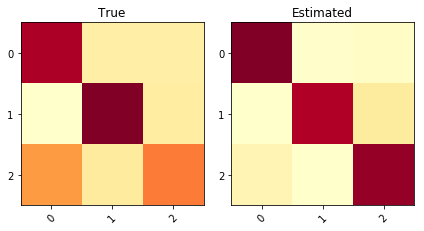

KL divergence: 0.2735	Pearson Correlation between diagonals: -0.2562


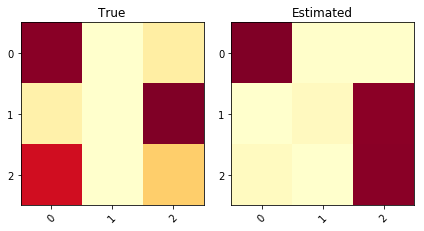

KL divergence: 0.6920	Pearson Correlation between diagonals: 0.7354


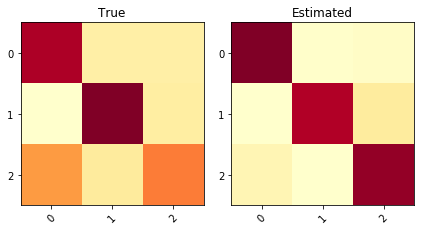

KL divergence: 0.2877	Pearson Correlation between diagonals: -0.3037


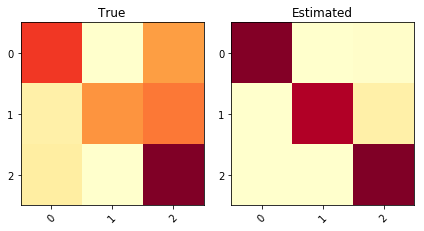

KL divergence: 0.6599	Pearson Correlation between diagonals: 0.8406
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.923484      0.923484      0.577884               0.497456       0.0860487
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.64556                0.761781
====  =======================  ======================
Test


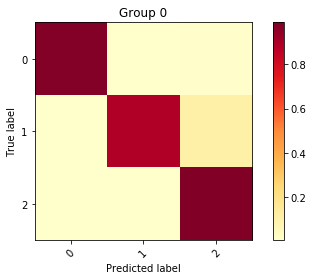

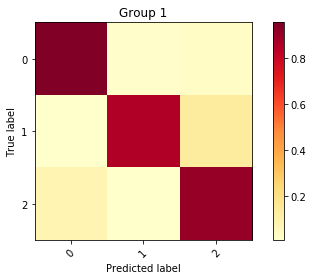

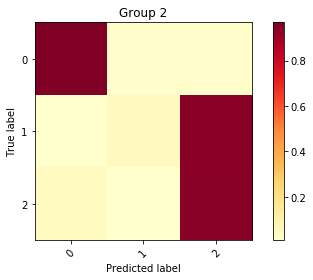

Inertia: 0.09524285009441276
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.566773      56   0.177724     0.953389  0.0489042            0.975884    0.898657      0.898657
   1         1  0.216467      21   0.33439      0.905857  0.0998696            0.95091     0.894994      0.894994
   2         2  0.21676       21   0.210641     0.654382  1.05931              0.697613    0.64591       0.64591
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.927961      0.92796

In [37]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


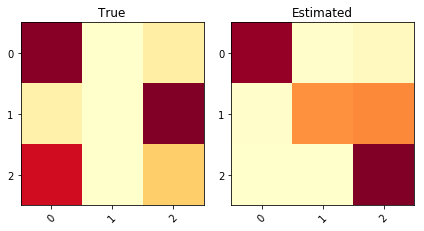

KL divergence: 1.3070	Pearson Correlation between diagonals: 0.6675


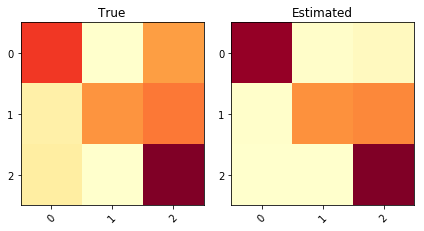

KL divergence: 0.3162	Pearson Correlation between diagonals: 0.8405


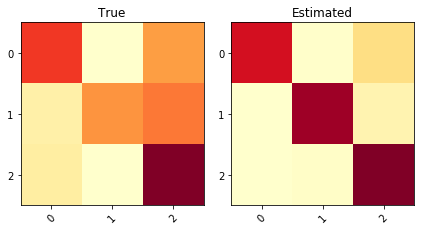

KL divergence: 0.3708	Pearson Correlation between diagonals: 0.4368


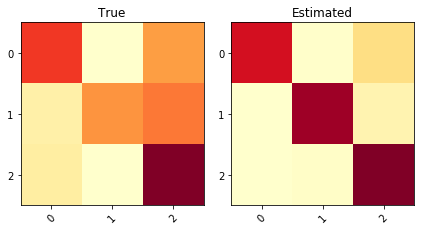

KL divergence: 0.3708	Pearson Correlation between diagonals: 0.4369


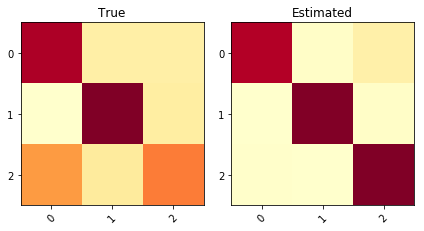

KL divergence: 0.4875	Pearson Correlation between diagonals: -0.3702


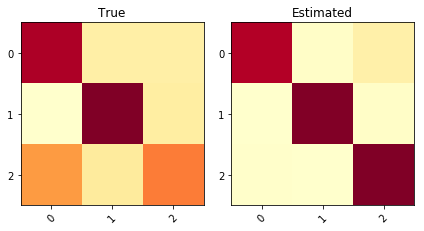

KL divergence: 0.4875	Pearson Correlation between diagonals: -0.3702


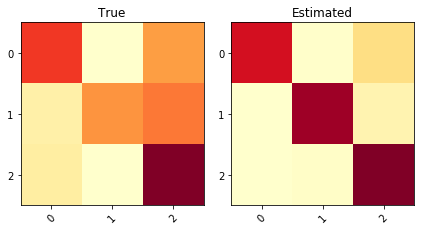

KL divergence: 0.3708	Pearson Correlation between diagonals: 0.4366


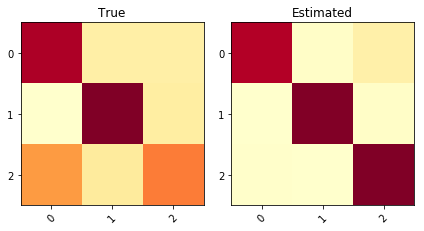

KL divergence: 0.4875	Pearson Correlation between diagonals: -0.3702


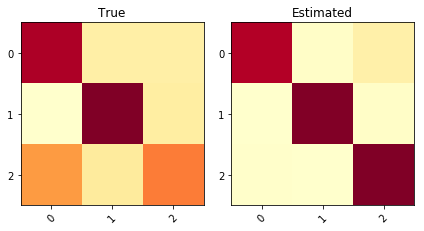

KL divergence: 0.4875	Pearson Correlation between diagonals: -0.3702


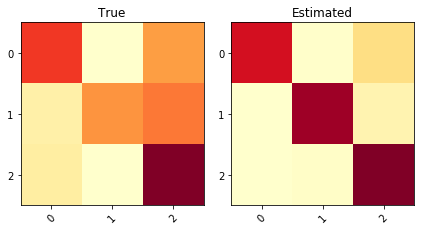

KL divergence: 0.3708	Pearson Correlation between diagonals: 0.4367


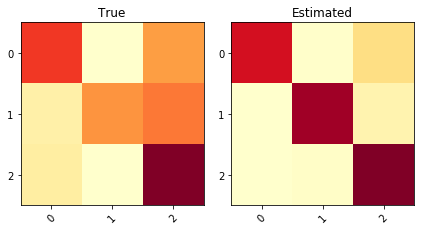

KL divergence: 0.3641	Pearson Correlation between diagonals: 0.4606


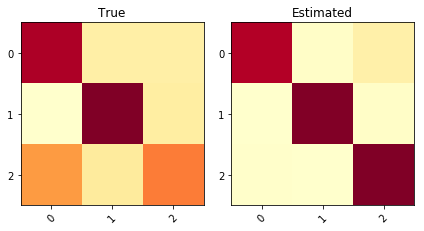

KL divergence: 0.4875	Pearson Correlation between diagonals: -0.3702


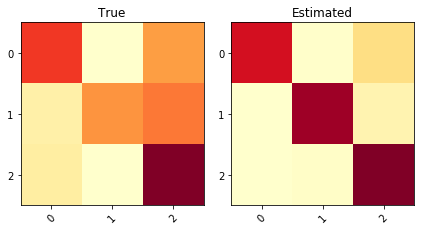

KL divergence: 0.3708	Pearson Correlation between diagonals: 0.4369


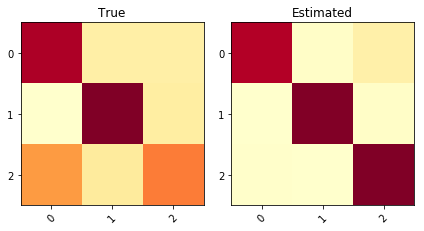

KL divergence: 0.4875	Pearson Correlation between diagonals: -0.3704


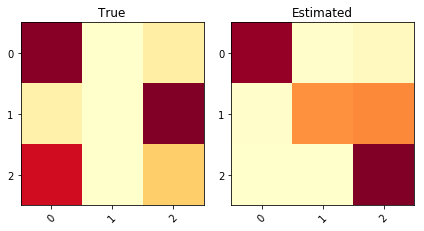

KL divergence: 1.3070	Pearson Correlation between diagonals: 0.6675
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.888482      0.888482      0.578949               0.316185       0.0887187
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.660428                0.760245
====  =======================  ======================
Test


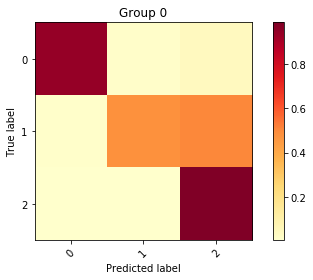

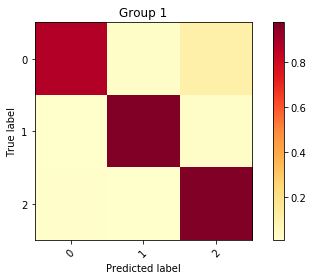

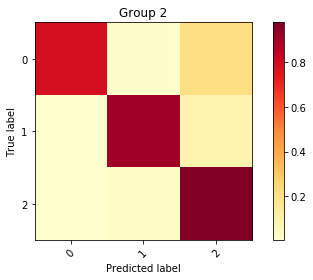

Inertia: 0.04093198284196357
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.362402      36   0.346846     0.806292  0.264352             0.880866    0.638584      0.638584
   1         1  0.224919      22   0.241495     0.93936   0.0638557            0.968546    0.904762      0.904762
   2         2  0.412678      41   0.338992     0.889263  0.121751             0.940814    0.885226      0.885226
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.884005      0.8840

In [38]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [55]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.5734635734635735


*** Soft-Majority (Train with softMV) ***
Train


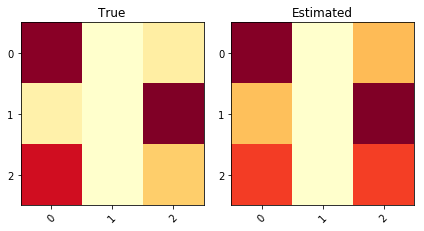

KL divergence: 0.0938	Pearson Correlation between diagonals: 0.9063


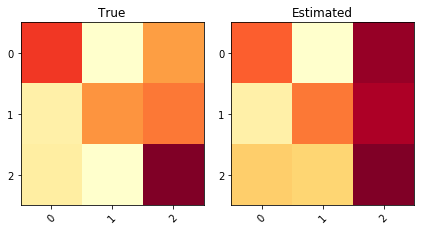

KL divergence: 0.1547	Pearson Correlation between diagonals: 0.9581


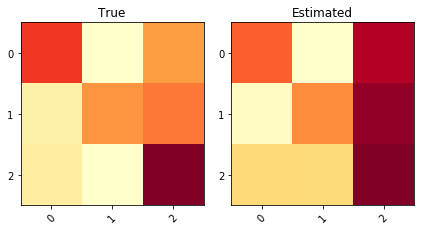

KL divergence: 0.1419	Pearson Correlation between diagonals: 0.9765


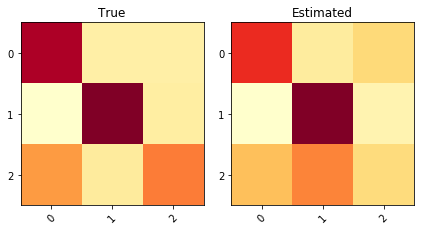

KL divergence: 0.1902	Pearson Correlation between diagonals: 0.9816


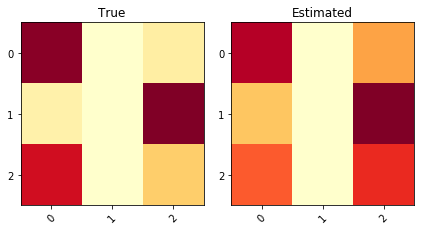

KL divergence: 0.1252	Pearson Correlation between diagonals: 0.8399


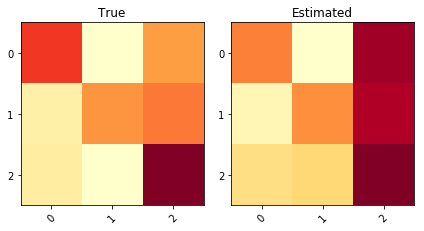

KL divergence: 0.1566	Pearson Correlation between diagonals: 0.9449


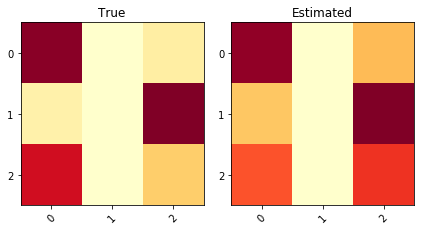

KL divergence: 0.1012	Pearson Correlation between diagonals: 0.8848


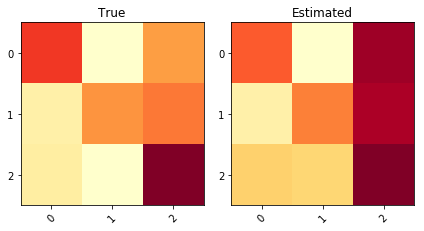

KL divergence: 0.1501	Pearson Correlation between diagonals: 0.9683


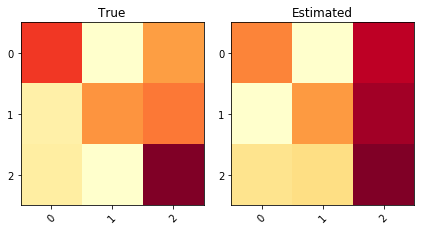

KL divergence: 0.1430	Pearson Correlation between diagonals: 0.9572


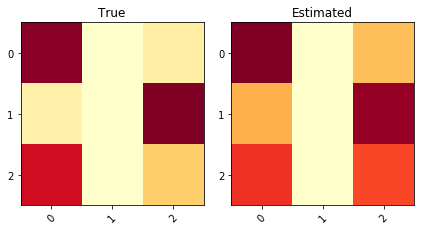

KL divergence: 0.0978	Pearson Correlation between diagonals: 0.9211


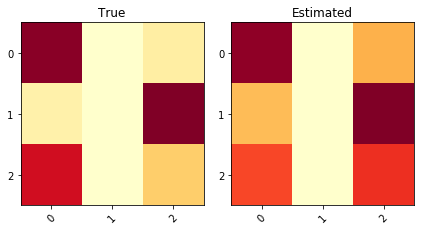

KL divergence: 0.1091	Pearson Correlation between diagonals: 0.8814


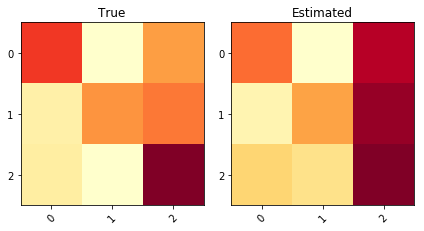

KL divergence: 0.1379	Pearson Correlation between diagonals: 0.9868


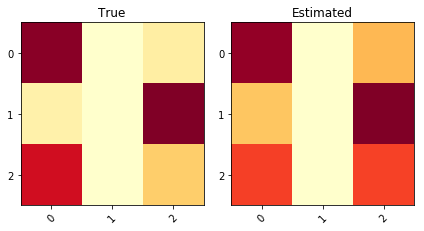

KL divergence: 0.0937	Pearson Correlation between diagonals: 0.9021


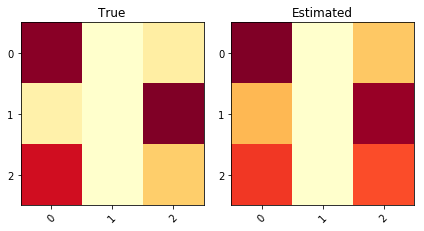

KL divergence: 0.0887	Pearson Correlation between diagonals: 0.9275


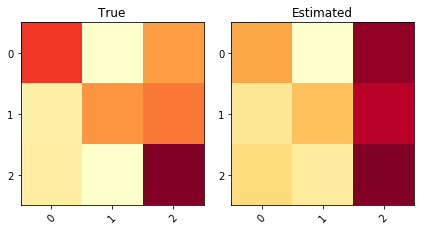

KL divergence: 0.1578	Pearson Correlation between diagonals: 0.9571
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.547416 |     0.547416 |     0.135122 |              0.931909 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.575092 |     0.575092 |
+----+--------+------------+--------------+


In [56]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


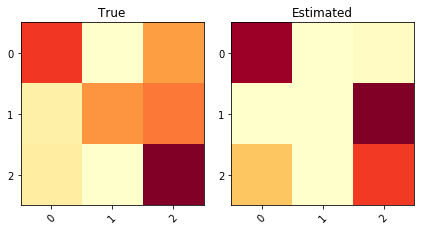

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


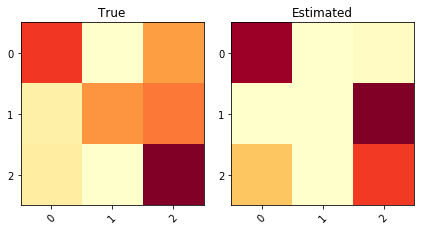

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


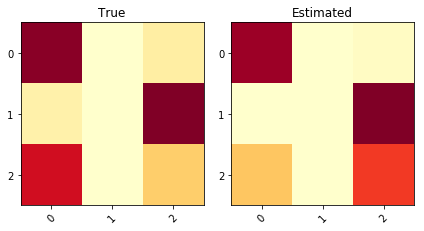

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


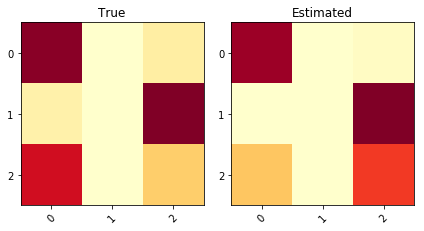

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


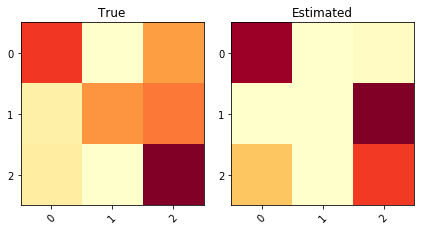

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


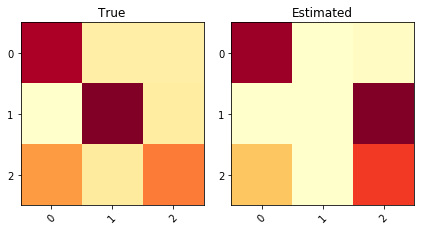

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.4259


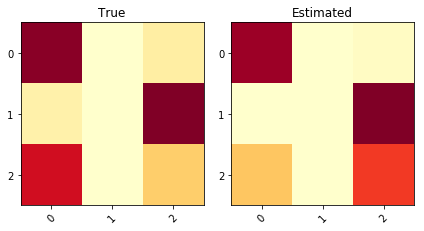

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


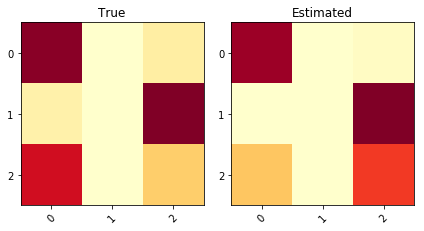

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


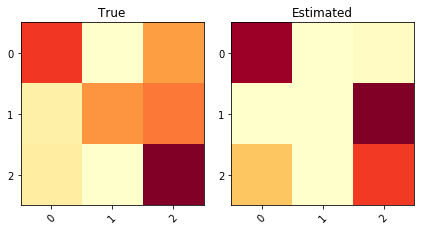

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


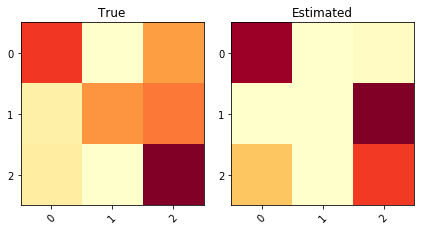

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


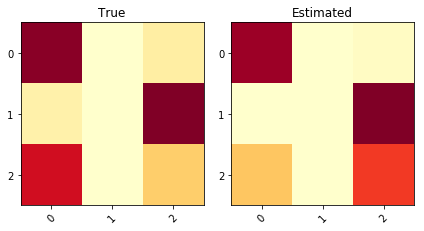

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


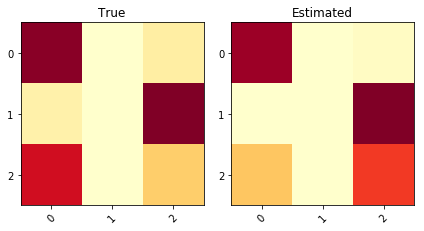

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846


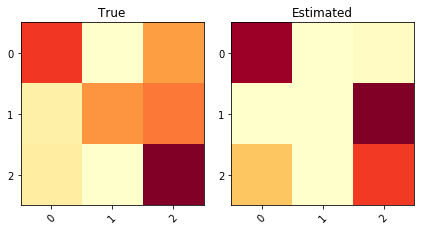

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


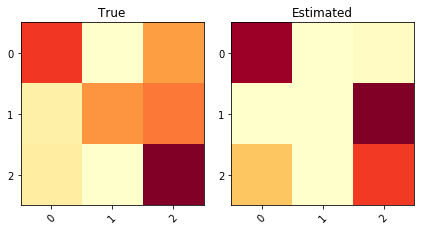

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.5993


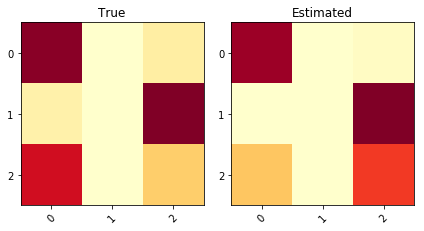

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8846
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.547416 |     0.547416 |      1.83324 |              0.607501 |
+----+--------+------------+--------------+--------------+-----------------------+


In [57]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


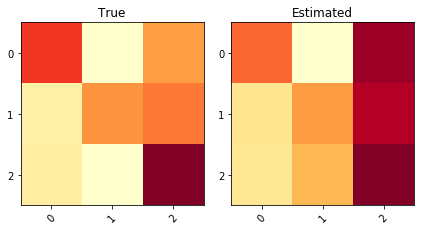

KL divergence: 0.1459	Pearson Correlation between diagonals: 0.9828


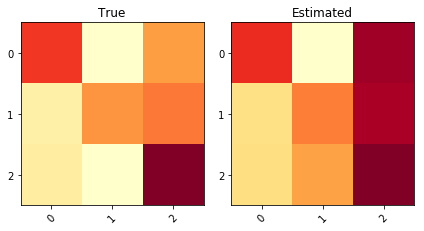

KL divergence: 0.1463	Pearson Correlation between diagonals: 1.0000


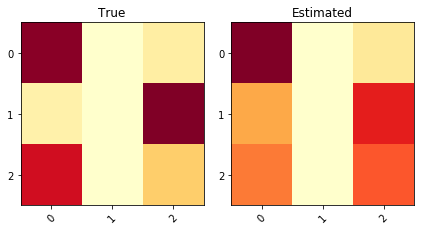

KL divergence: 0.1173	Pearson Correlation between diagonals: 0.9345


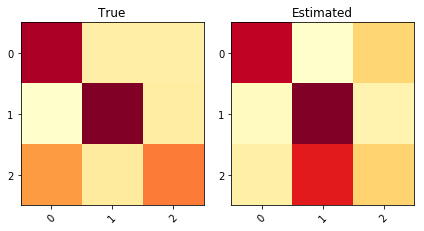

KL divergence: 0.2350	Pearson Correlation between diagonals: 0.9999


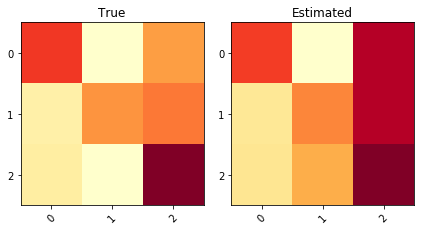

KL divergence: 0.1365	Pearson Correlation between diagonals: 0.9965


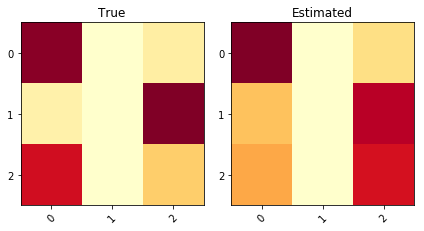

KL divergence: 0.1527	Pearson Correlation between diagonals: 0.8434


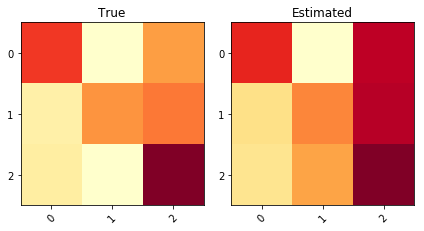

KL divergence: 0.1347	Pearson Correlation between diagonals: 0.9987


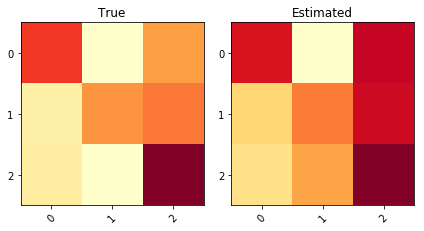

KL divergence: 0.1363	Pearson Correlation between diagonals: 0.9894


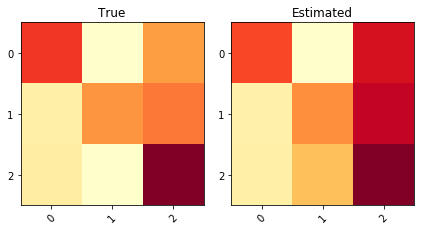

KL divergence: 0.1175	Pearson Correlation between diagonals: 0.9950


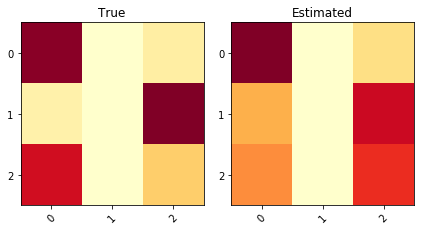

KL divergence: 0.1299	Pearson Correlation between diagonals: 0.8902


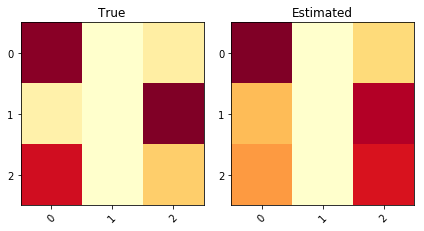

KL divergence: 0.1439	Pearson Correlation between diagonals: 0.8498


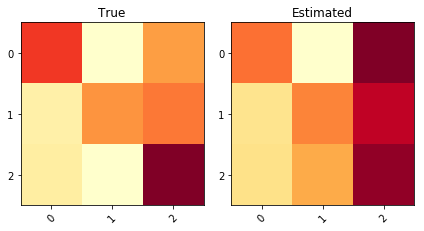

KL divergence: 0.1595	Pearson Correlation between diagonals: 0.9507


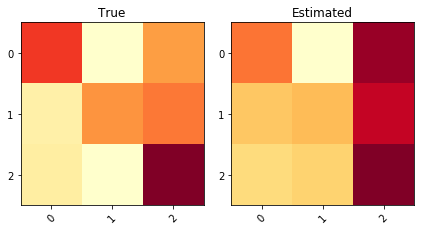

KL divergence: 0.1602	Pearson Correlation between diagonals: 0.9967


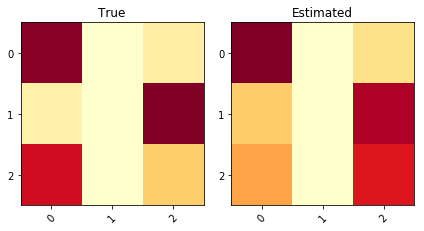

KL divergence: 0.1370	Pearson Correlation between diagonals: 0.8560


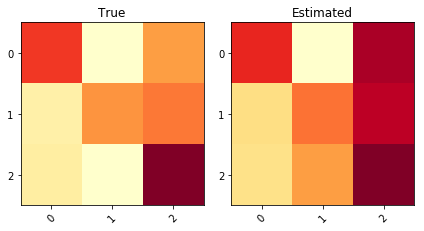

KL divergence: 0.1401	Pearson Correlation between diagonals: 0.9999
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.571429 |     0.571429 |     0.148251 |              0.929138 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.598291 |     0.598291 |
+----+--------+------------+--------------+


In [58]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


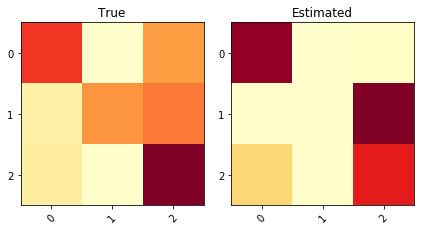

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


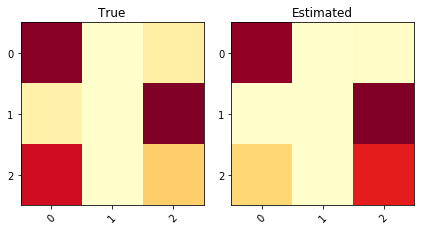

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


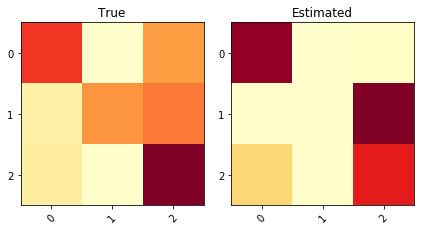

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


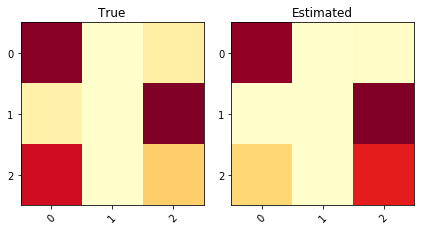

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


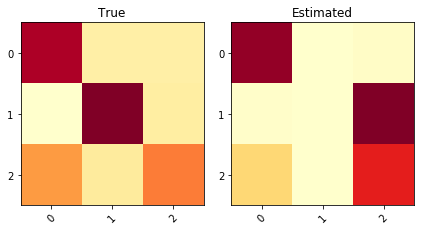

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.4783


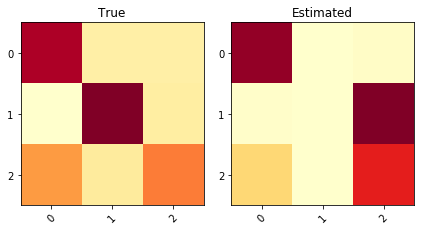

KL divergence: 6.0199	Pearson Correlation between diagonals: -0.4783


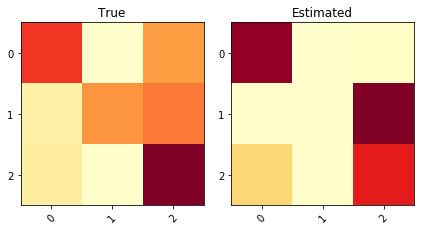

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


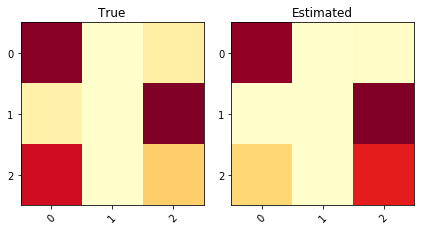

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


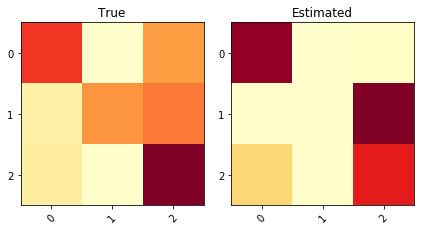

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


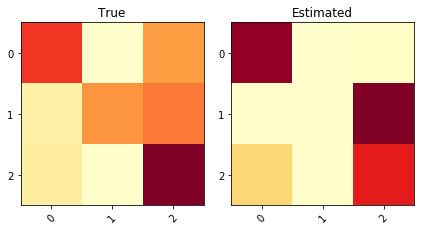

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


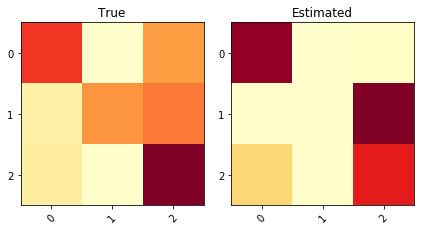

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


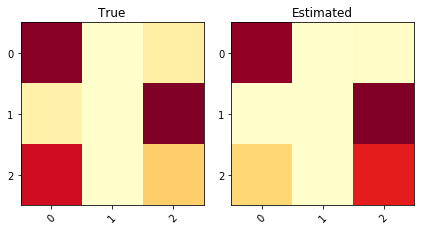

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


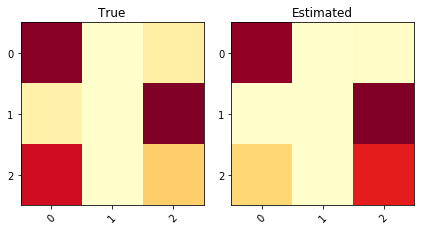

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557


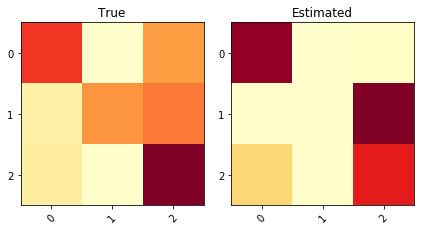

KL divergence: 2.3243	Pearson Correlation between diagonals: 0.6452


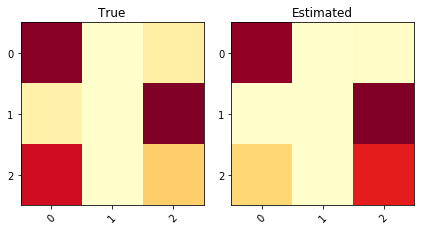

KL divergence: 0.2927	Pearson Correlation between diagonals: 0.8557
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.571429 |     0.571429 |      1.83324 |              0.607225 |
+----+--------+------------+--------------+--------------+-----------------------+


In [59]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


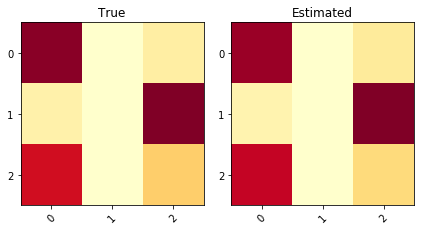

KL divergence: 0.0028	Pearson Correlation between diagonals: 0.9990


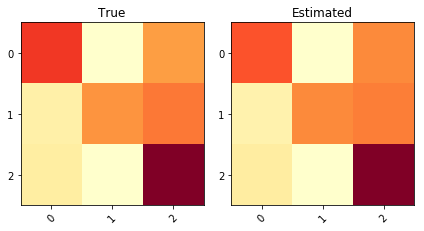

KL divergence: 0.0032	Pearson Correlation between diagonals: 0.9826


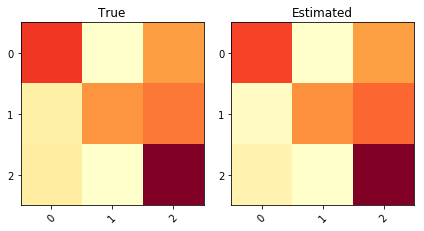

KL divergence: 0.0222	Pearson Correlation between diagonals: 0.9972


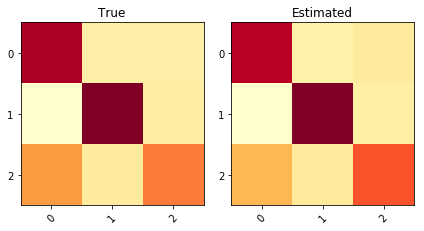

KL divergence: 0.0067	Pearson Correlation between diagonals: 0.9920


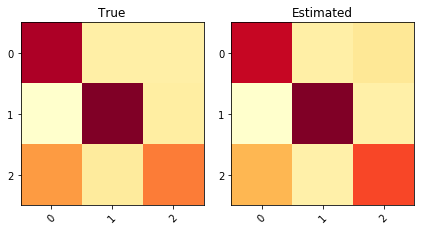

KL divergence: 0.0114	Pearson Correlation between diagonals: 0.9647


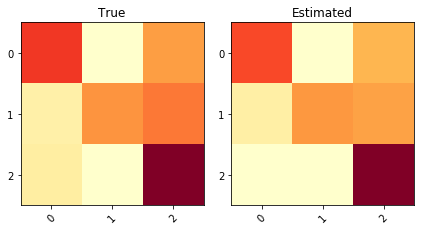

KL divergence: 0.1959	Pearson Correlation between diagonals: 0.9979


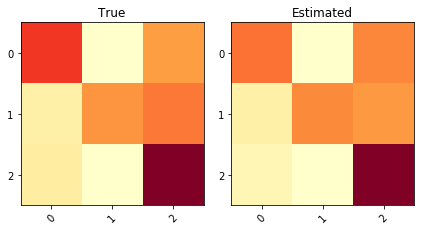

KL divergence: 0.0121	Pearson Correlation between diagonals: 0.9515


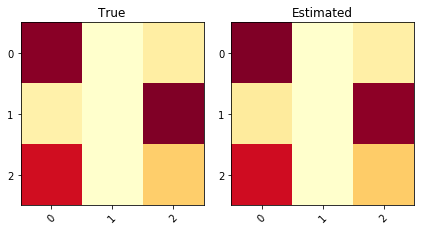

KL divergence: 0.0026	Pearson Correlation between diagonals: 1.0000


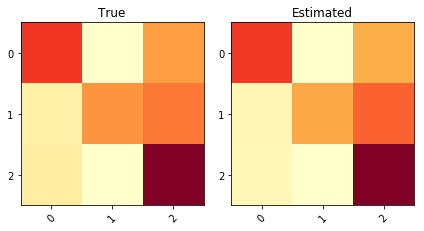

KL divergence: 0.0116	Pearson Correlation between diagonals: 0.9978


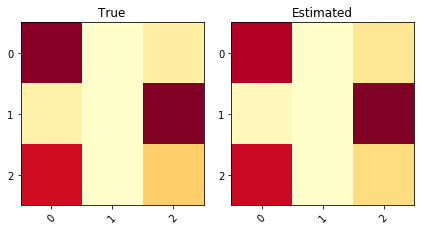

KL divergence: 0.0102	Pearson Correlation between diagonals: 0.9991


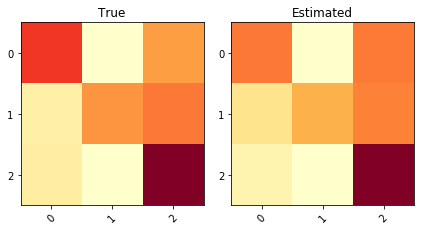

KL divergence: 0.0192	Pearson Correlation between diagonals: 0.9907


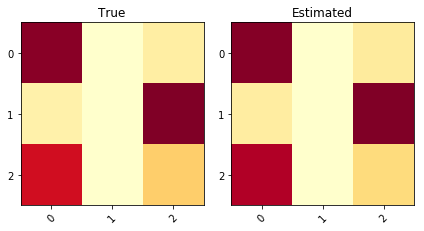

KL divergence: 0.0046	Pearson Correlation between diagonals: 0.9980


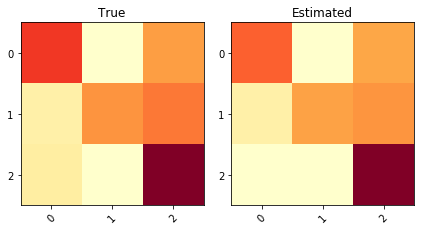

KL divergence: 0.2028	Pearson Correlation between diagonals: 0.9923


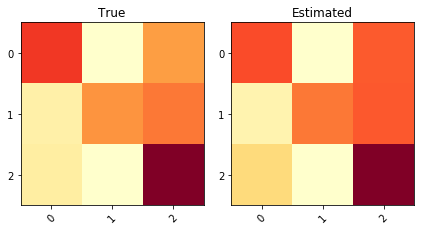

KL divergence: 0.0159	Pearson Correlation between diagonals: 0.9775


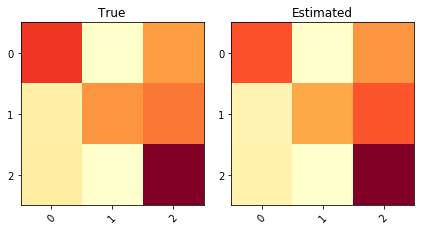

KL divergence: 0.0063	Pearson Correlation between diagonals: 0.9996
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.932031 |     0.932031 |    0.0227982 |              0.990658 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.95116 |      0.95116 |
+----+--------+------------+--------------+


In [60]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


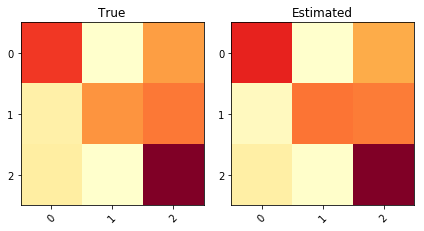

KL divergence: 0.0198	Pearson Correlation between diagonals: 1.0000


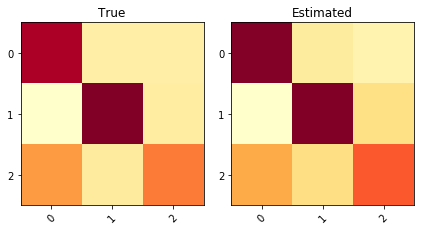

KL divergence: 0.0189	Pearson Correlation between diagonals: 0.9847


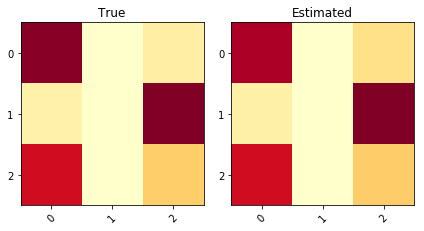

KL divergence: 0.0200	Pearson Correlation between diagonals: 0.9994


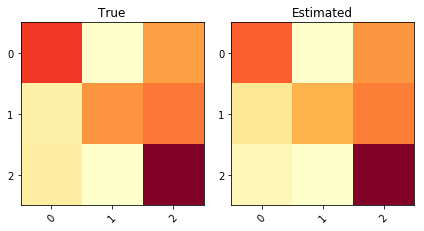

KL divergence: 0.0207	Pearson Correlation between diagonals: 0.9990


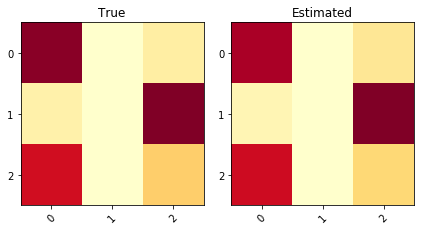

KL divergence: 0.0164	Pearson Correlation between diagonals: 0.9998


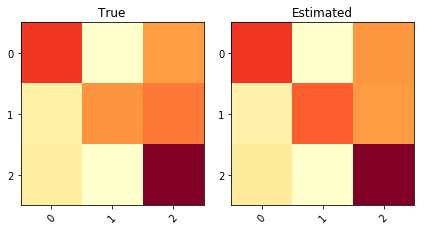

KL divergence: 0.0156	Pearson Correlation between diagonals: 0.9804


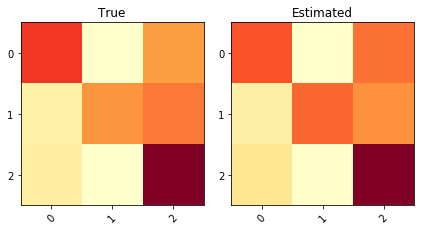

KL divergence: 0.0206	Pearson Correlation between diagonals: 0.9524


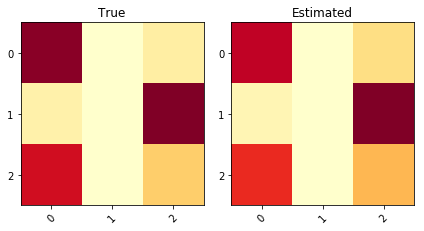

KL divergence: 0.0279	Pearson Correlation between diagonals: 0.9904


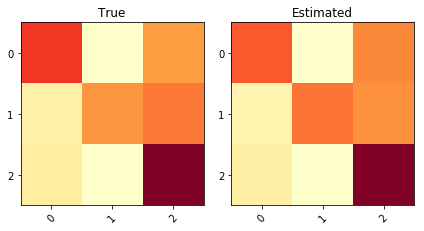

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9606


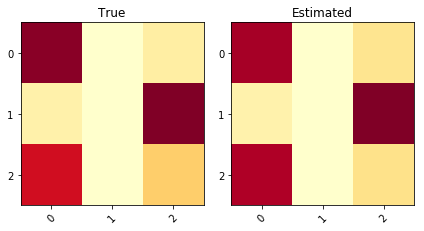

KL divergence: 0.0237	Pearson Correlation between diagonals: 0.9961


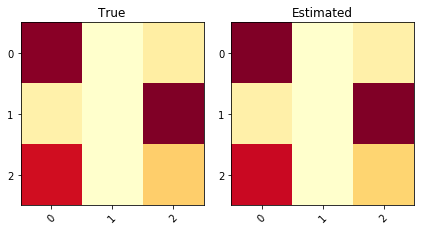

KL divergence: 0.0122	Pearson Correlation between diagonals: 0.9996


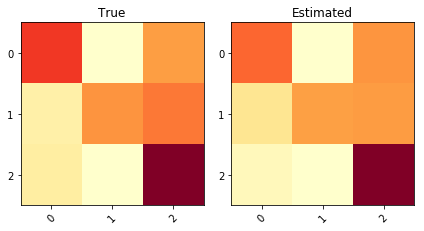

KL divergence: 0.0251	Pearson Correlation between diagonals: 0.9882


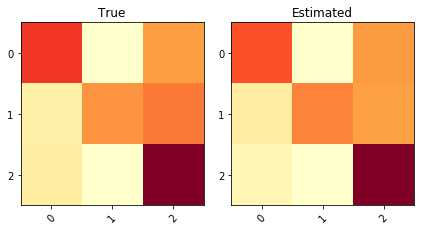

KL divergence: 0.0162	Pearson Correlation between diagonals: 0.9807


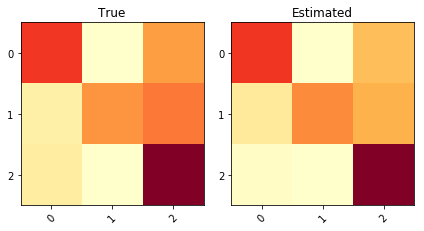

KL divergence: 0.0438	Pearson Correlation between diagonals: 0.9995


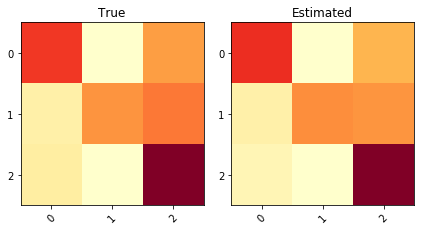

KL divergence: 0.0144	Pearson Correlation between diagonals: 0.9997
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.923077 |     0.923077 |    0.0173547 |              0.992159 |       0.234615 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.722518 |               0.638854 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [22]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


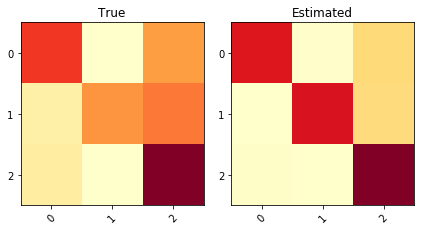

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.8974


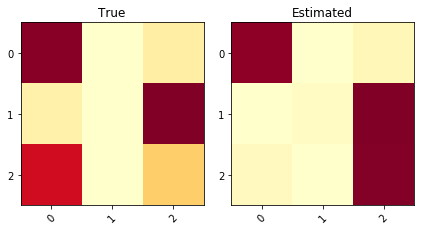

KL divergence: 0.7232	Pearson Correlation between diagonals: 0.7083


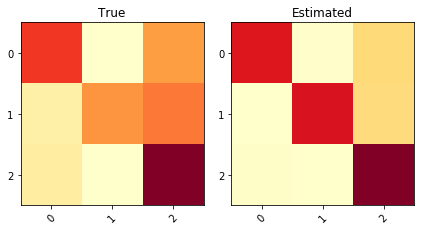

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.8974


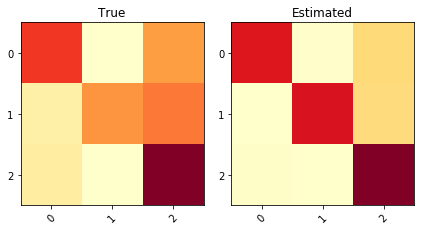

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.8974


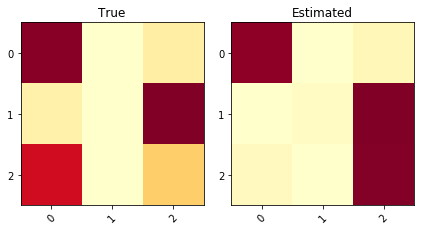

KL divergence: 0.7232	Pearson Correlation between diagonals: 0.7083


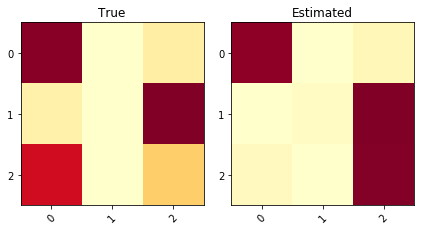

KL divergence: 0.7232	Pearson Correlation between diagonals: 0.7083


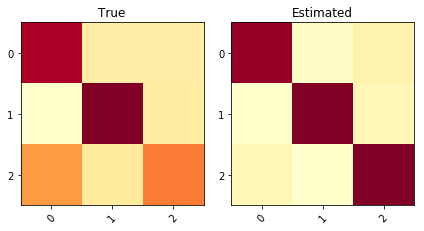

KL divergence: 0.2852	Pearson Correlation between diagonals: -0.2967


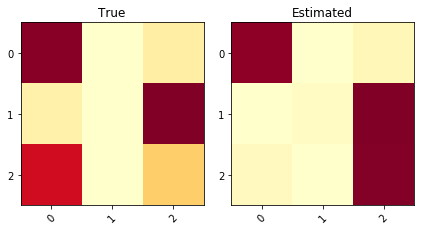

KL divergence: 0.7232	Pearson Correlation between diagonals: 0.7083


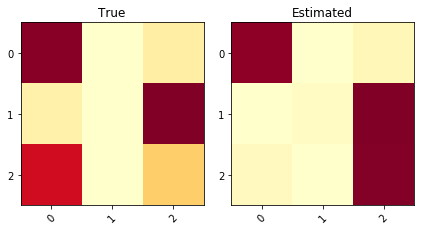

KL divergence: 0.7232	Pearson Correlation between diagonals: 0.7083


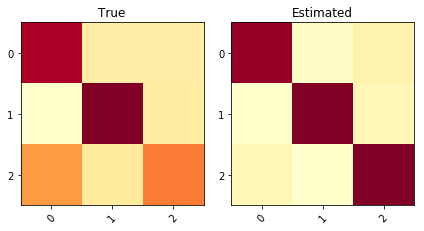

KL divergence: 0.2852	Pearson Correlation between diagonals: -0.2967


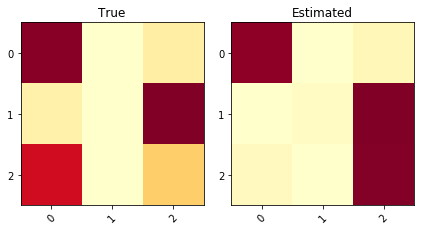

KL divergence: 0.7232	Pearson Correlation between diagonals: 0.7083


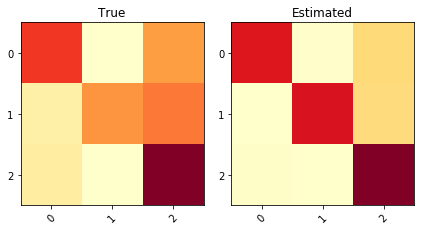

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.8974


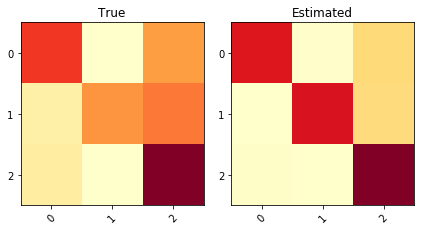

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.8974


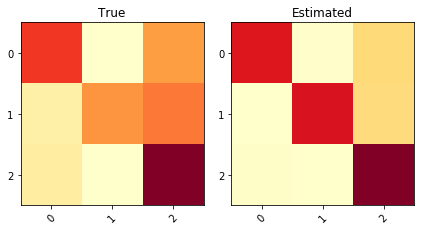

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.8974


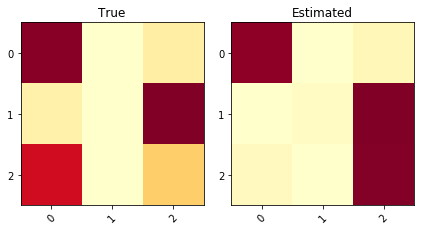

KL divergence: 0.7232	Pearson Correlation between diagonals: 0.7083
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.730973      0.730973        0.4591               0.655157        0.184145
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.689404                0.651766
====  =======================  ======================
Test


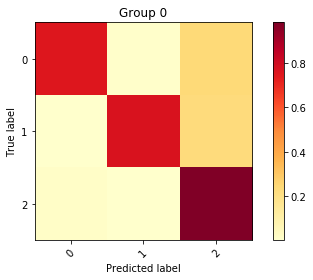

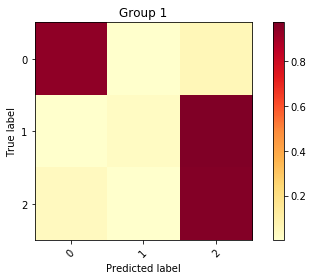

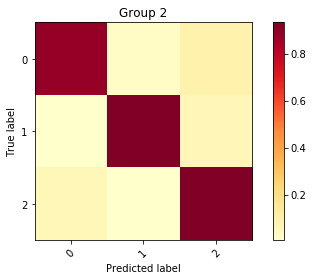

Inertia: 0.10651513809959094
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.420128      42   0.411592     0.835122  0.187589             0.90975     0.788767      0.788767
   1         1  0.4582        45   0.189384     0.64135   1.23685              0.679335    0.545788      0.545788
   2         2  0.121672      12   0.316727     0.917183  0.0867076            0.957212    0.802198      0.802198
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.748474      0.7484

In [39]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


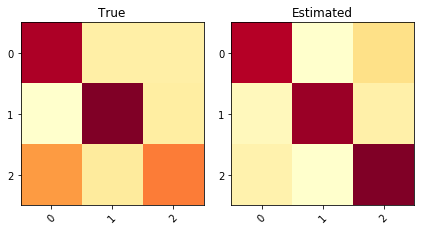

KL divergence: 0.2481	Pearson Correlation between diagonals: -0.7542


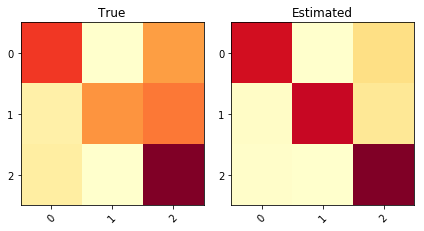

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497


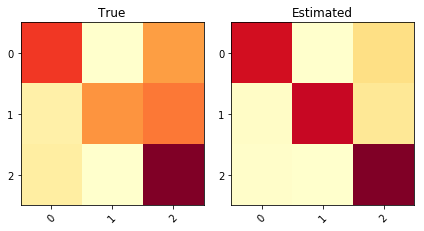

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497


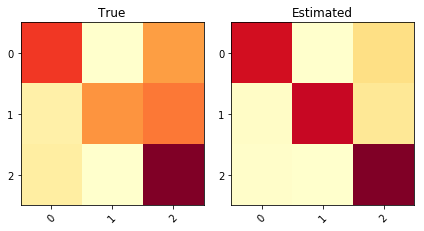

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497


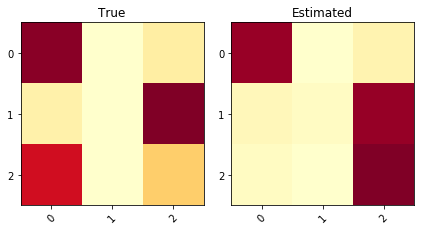

KL divergence: 0.6801	Pearson Correlation between diagonals: 0.6902


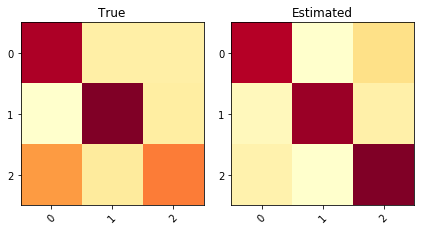

KL divergence: 0.2480	Pearson Correlation between diagonals: -0.7538


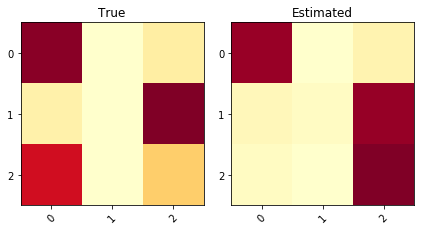

KL divergence: 0.6801	Pearson Correlation between diagonals: 0.6902


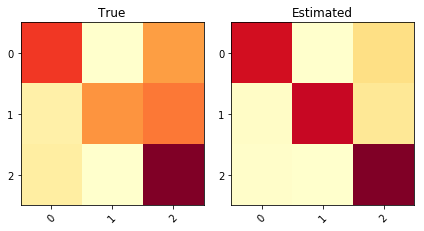

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497


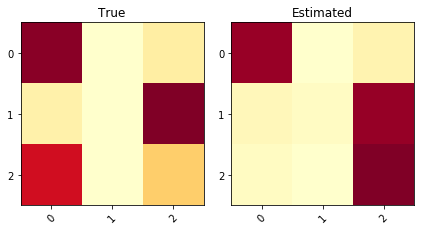

KL divergence: 0.6801	Pearson Correlation between diagonals: 0.6902


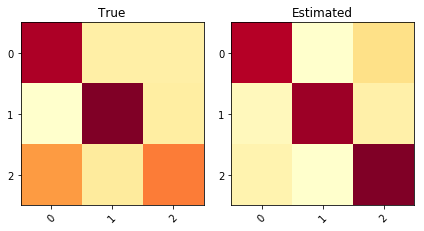

KL divergence: 0.2529	Pearson Correlation between diagonals: -0.7695


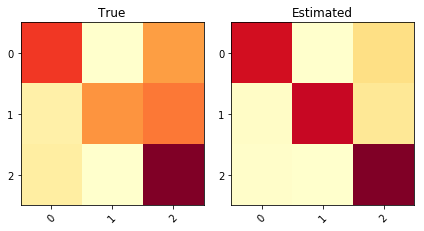

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497


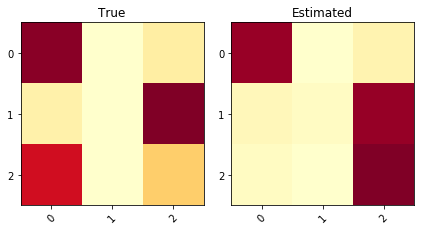

KL divergence: 0.6801	Pearson Correlation between diagonals: 0.6902


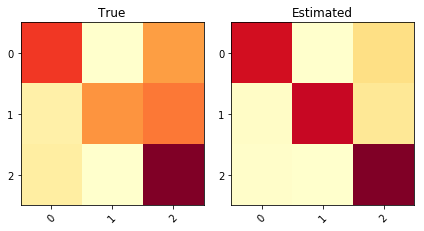

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497


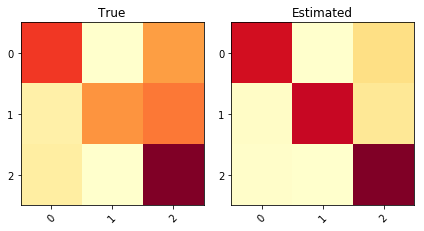

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497


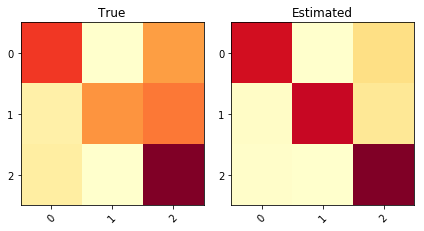

KL divergence: 0.2149	Pearson Correlation between diagonals: 0.8497
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.663004      0.663004      0.433278               0.567677        0.192501
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.67629                 0.67154
====  =======================  ======================
Test


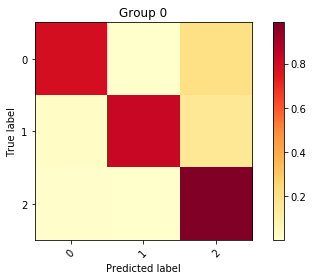

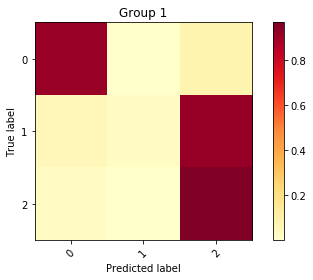

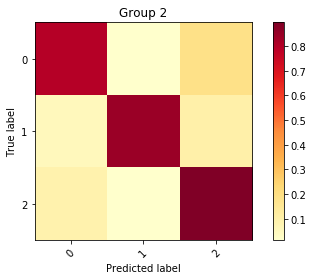

Inertia: 0.09952202633333702
A result
 ====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.432503       43   0.378848     0.867448   0.146812            0.92877     0.781441      0.781441
   1         1  0.470344       47   0.26068      0.637099   1.24146             0.677063    0.554335      0.554335
   2         2  0.0971529       9   0.484841     0.847391   0.166684            0.918784    0.796093      0.796093
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.669109     

In [40]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


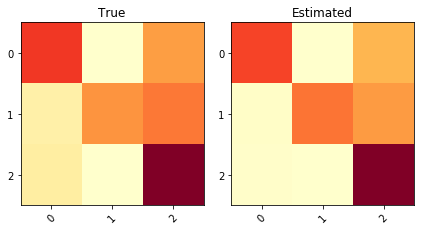

KL divergence: 0.0853	Pearson Correlation between diagonals: 0.9847


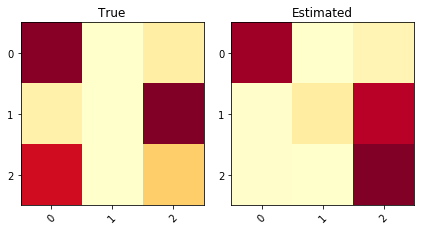

KL divergence: 1.1417	Pearson Correlation between diagonals: 0.6751


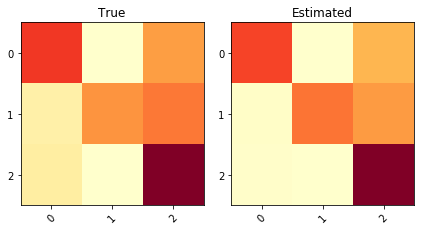

KL divergence: 0.0853	Pearson Correlation between diagonals: 0.9847


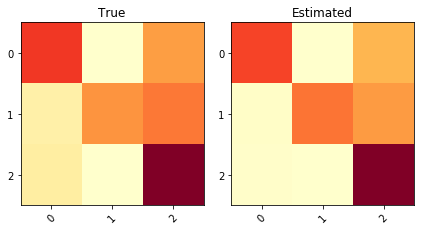

KL divergence: 0.0853	Pearson Correlation between diagonals: 0.9847


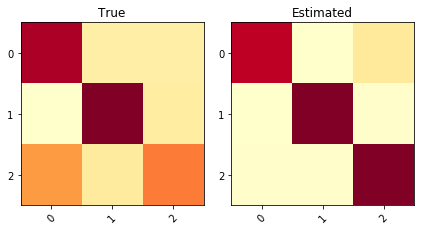

KL divergence: 0.6702	Pearson Correlation between diagonals: -0.2866


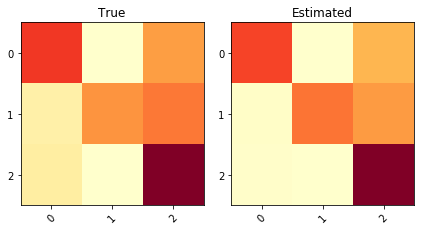

KL divergence: 0.0853	Pearson Correlation between diagonals: 0.9847


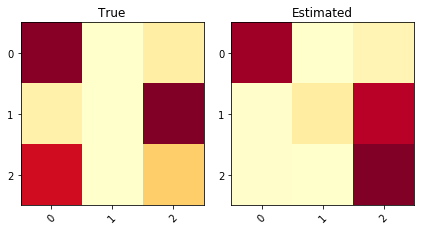

KL divergence: 1.1417	Pearson Correlation between diagonals: 0.6751


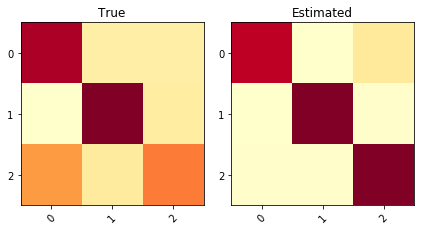

KL divergence: 0.6702	Pearson Correlation between diagonals: -0.2866


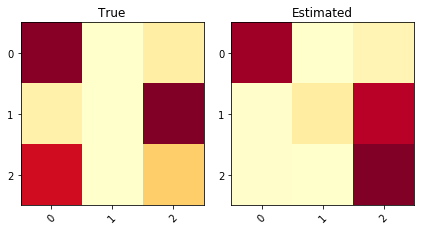

KL divergence: 1.1417	Pearson Correlation between diagonals: 0.6751


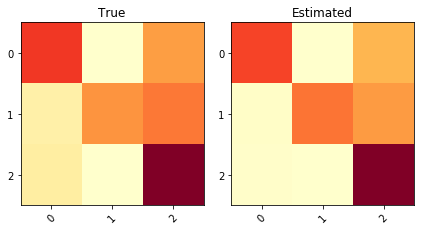

KL divergence: 0.0853	Pearson Correlation between diagonals: 0.9847


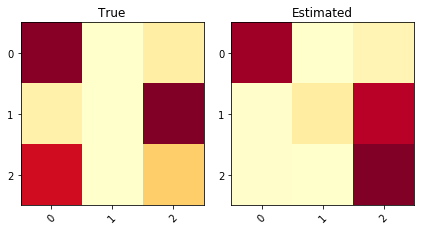

KL divergence: 1.1417	Pearson Correlation between diagonals: 0.6751


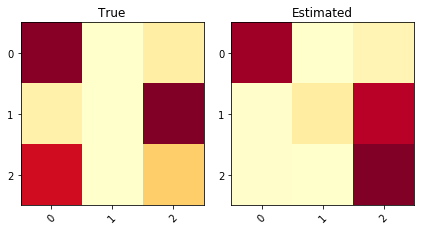

KL divergence: 1.1417	Pearson Correlation between diagonals: 0.6751


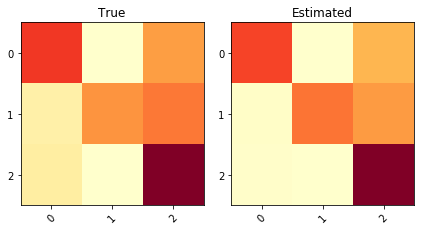

KL divergence: 0.0853	Pearson Correlation between diagonals: 0.9847


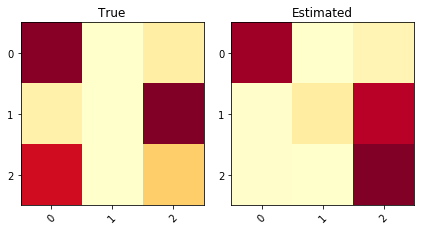

KL divergence: 1.1417	Pearson Correlation between diagonals: 0.6751


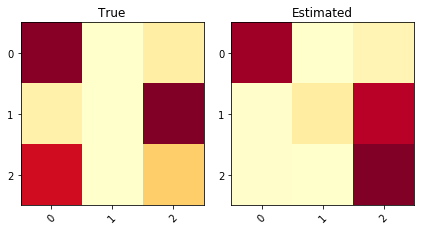

KL divergence: 1.1417	Pearson Correlation between diagonals: 0.6751
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.628002      0.628002      0.647274               0.677032        0.201597
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.696166                0.661289
====  =======================  ======================
Test


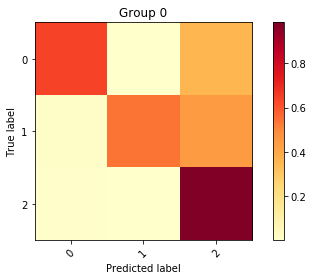

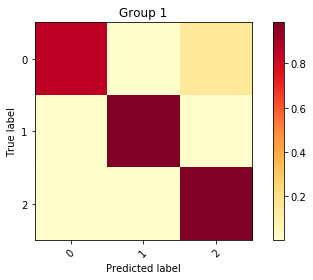

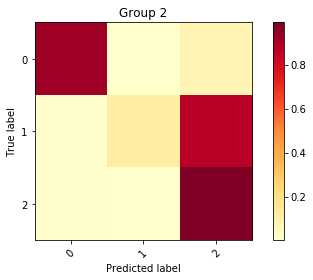

Inertia: 0.09510827002425988
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.245929      24   0.503901     0.721875  0.358759             0.834646    0.642247      0.642247
   1         1  0.359744      35   0.205268     0.940817  0.0630502            0.96905     0.76801       0.76801
   2         2  0.394327      39   0.247096     0.678903  0.737331             0.74386     0.528694      0.528694
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.634921      0.63492

In [41]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [57]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7566137566137566


*** Soft-Majority (Train with softMV) ***
Train


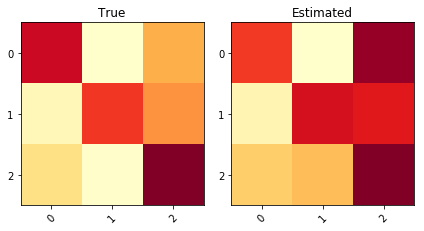

KL divergence: 0.1282	Pearson Correlation between diagonals: 0.6535


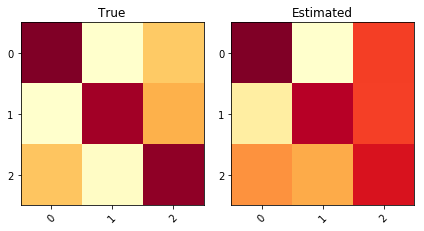

KL divergence: 0.1085	Pearson Correlation between diagonals: 0.5067


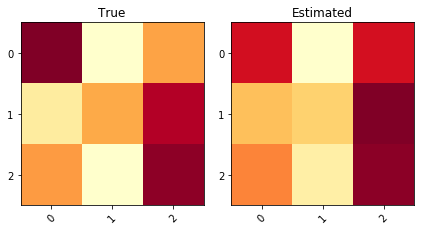

KL divergence: 0.0905	Pearson Correlation between diagonals: 0.9609


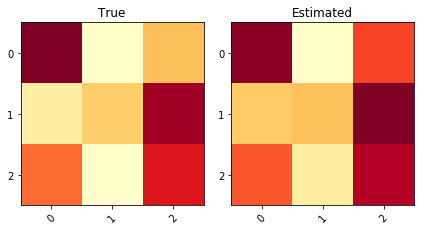

KL divergence: 0.0701	Pearson Correlation between diagonals: 0.9788


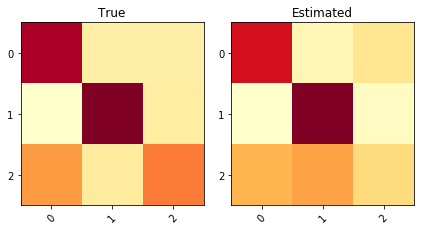

KL divergence: 0.1522	Pearson Correlation between diagonals: 0.9976


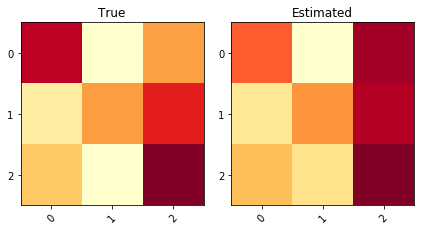

KL divergence: 0.1154	Pearson Correlation between diagonals: 0.8290


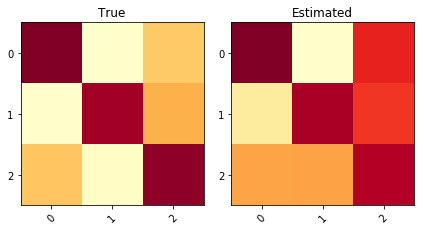

KL divergence: 0.1065	Pearson Correlation between diagonals: 0.7186


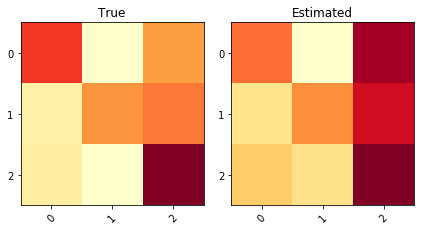

KL divergence: 0.1340	Pearson Correlation between diagonals: 0.9637


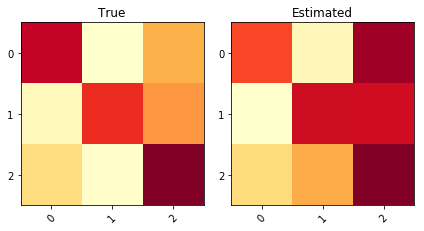

KL divergence: 0.1372	Pearson Correlation between diagonals: 0.5179


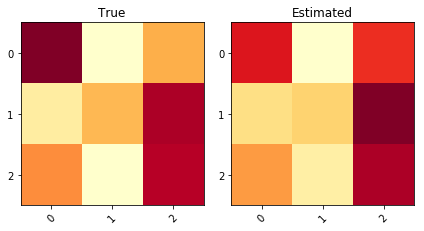

KL divergence: 0.0721	Pearson Correlation between diagonals: 0.9327


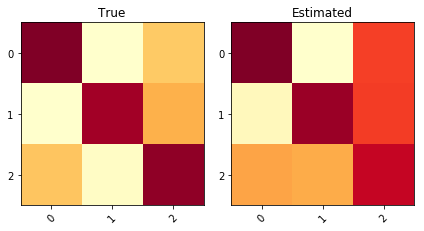

KL divergence: 0.0909	Pearson Correlation between diagonals: 0.3380


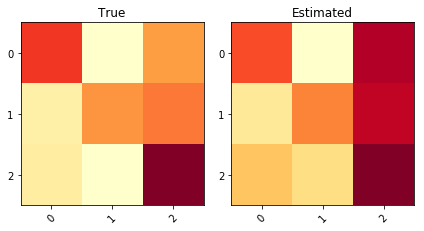

KL divergence: 0.1237	Pearson Correlation between diagonals: 0.9851


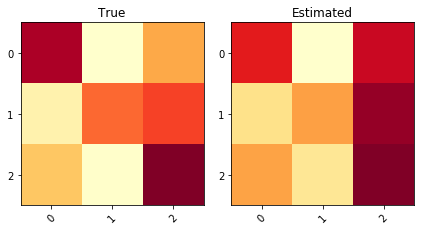

KL divergence: 0.0889	Pearson Correlation between diagonals: 0.9671


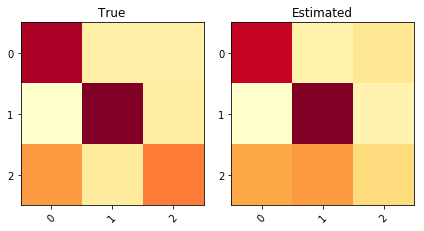

KL divergence: 0.1458	Pearson Correlation between diagonals: 1.0000


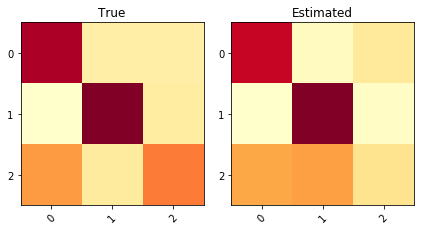

KL divergence: 0.1458	Pearson Correlation between diagonals: 0.9999
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.670737 |     0.670737 |    0.0990895 |              0.825365 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.676435 |     0.676435 |
+----+--------+------------+--------------+


In [58]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


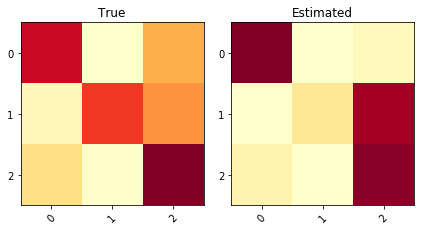

KL divergence: 0.3816	Pearson Correlation between diagonals: 0.8350


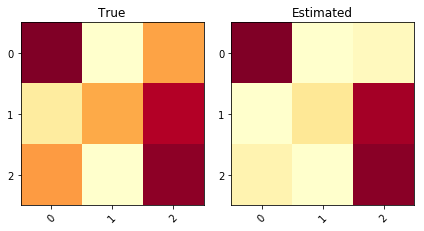

KL divergence: 0.1288	Pearson Correlation between diagonals: 0.9998


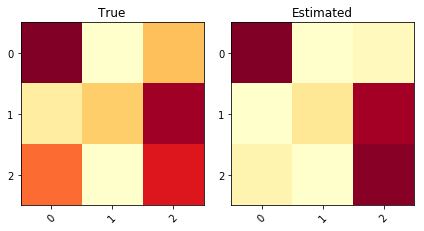

KL divergence: 0.1495	Pearson Correlation between diagonals: 0.9551


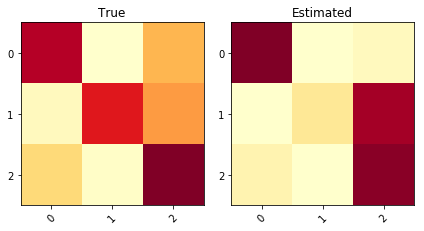

KL divergence: 0.4644	Pearson Correlation between diagonals: 0.8770


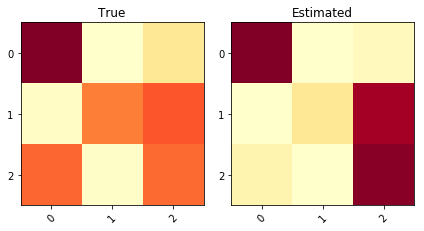

KL divergence: 0.5245	Pearson Correlation between diagonals: 0.5813


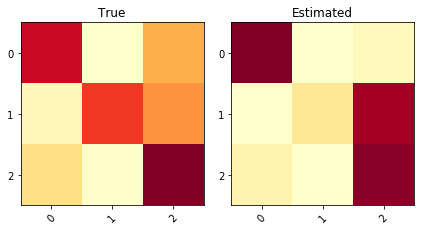

KL divergence: 0.3816	Pearson Correlation between diagonals: 0.8350


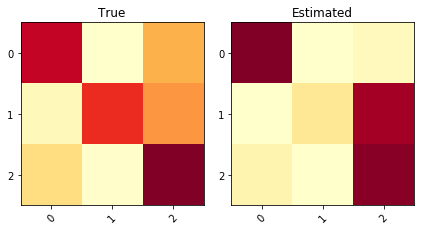

KL divergence: 0.4163	Pearson Correlation between diagonals: 0.8501


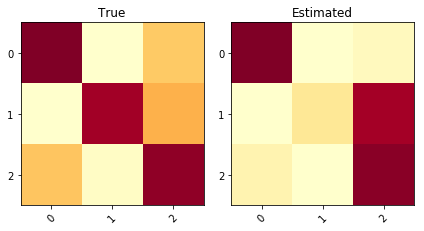

KL divergence: 0.6479	Pearson Correlation between diagonals: 0.8921


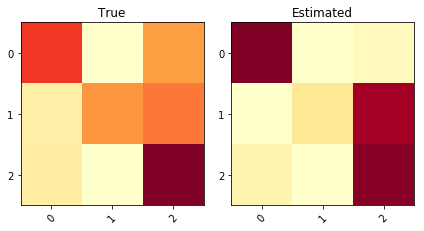

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7823


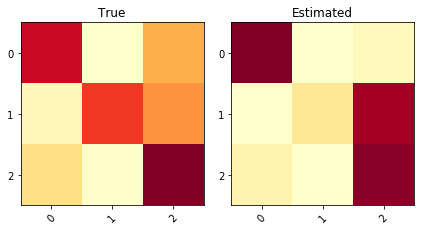

KL divergence: 0.3816	Pearson Correlation between diagonals: 0.8350


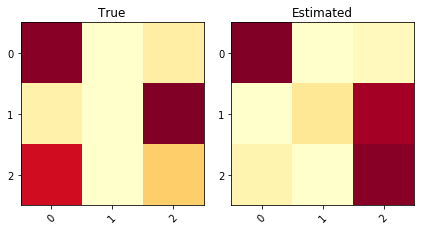

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7379


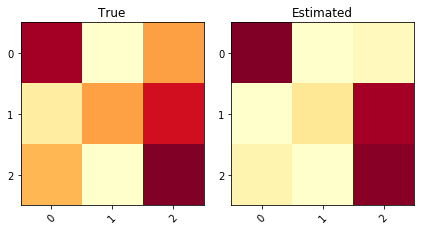

KL divergence: 0.1295	Pearson Correlation between diagonals: 0.9892


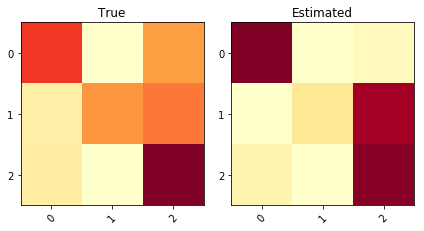

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7823


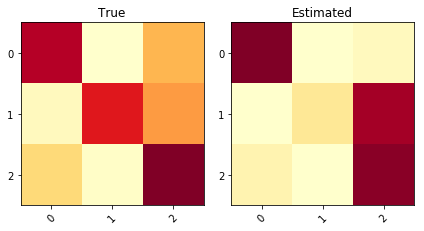

KL divergence: 0.4644	Pearson Correlation between diagonals: 0.8770


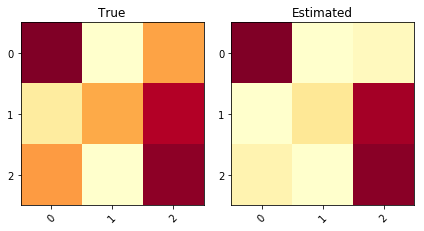

KL divergence: 0.1288	Pearson Correlation between diagonals: 0.9998
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.670737 |     0.670737 |     0.423141 |              0.710199 |
+----+--------+------------+--------------+--------------+-----------------------+


In [59]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


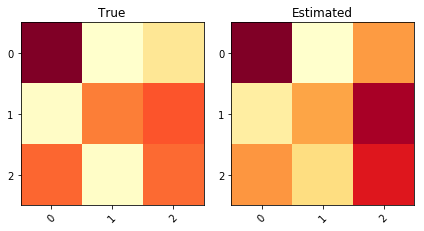

KL divergence: 0.0832	Pearson Correlation between diagonals: 0.8469


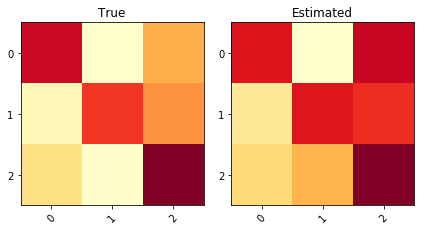

KL divergence: 0.1027	Pearson Correlation between diagonals: 0.8901


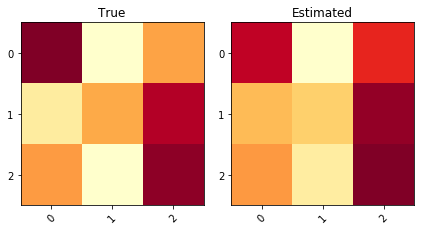

KL divergence: 0.0789	Pearson Correlation between diagonals: 0.9746


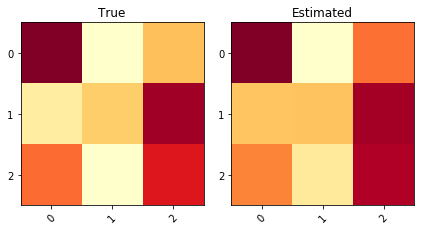

KL divergence: 0.0637	Pearson Correlation between diagonals: 0.9837


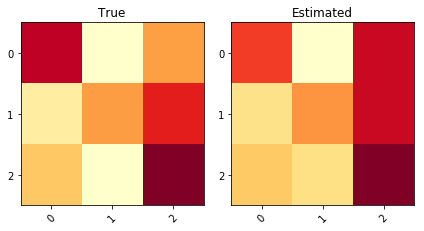

KL divergence: 0.0916	Pearson Correlation between diagonals: 0.9018


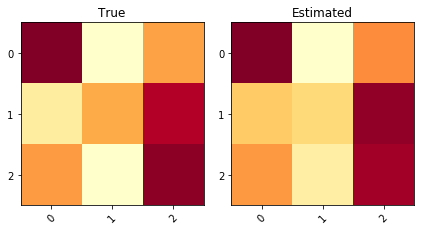

KL divergence: 0.0551	Pearson Correlation between diagonals: 0.9990


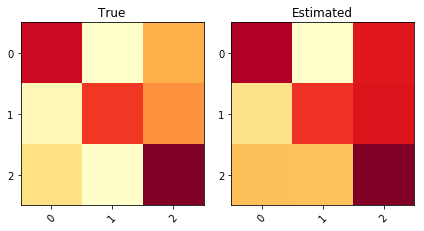

KL divergence: 0.0828	Pearson Correlation between diagonals: 0.9734


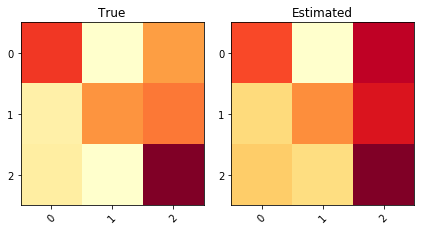

KL divergence: 0.1058	Pearson Correlation between diagonals: 0.9930


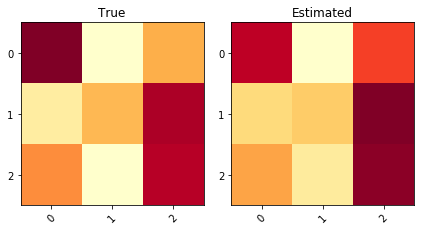

KL divergence: 0.0604	Pearson Correlation between diagonals: 0.9526


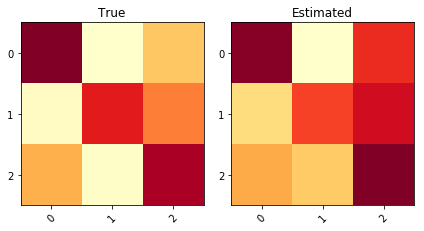

KL divergence: 0.0851	Pearson Correlation between diagonals: 0.9195


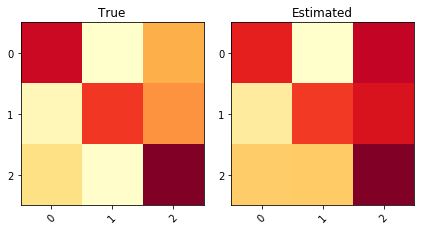

KL divergence: 0.0906	Pearson Correlation between diagonals: 0.9531


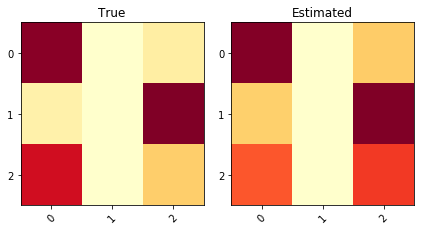

KL divergence: 0.0871	Pearson Correlation between diagonals: 0.9028


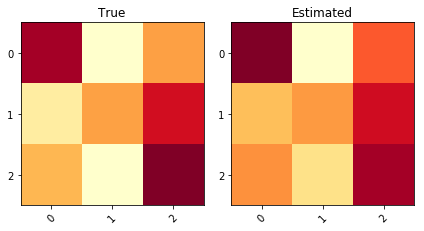

KL divergence: 0.0750	Pearson Correlation between diagonals: 0.9678


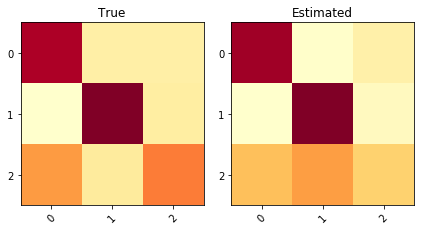

KL divergence: 0.1238	Pearson Correlation between diagonals: 0.9939


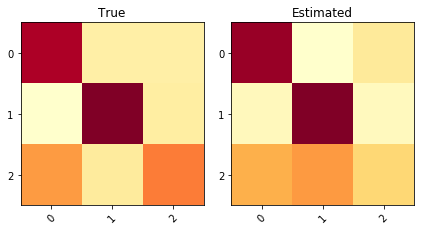

KL divergence: 0.1259	Pearson Correlation between diagonals: 0.9914
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.773708 |     0.773708 |     0.081633 |              0.901475 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.765568 |     0.765568 |
+----+--------+------------+--------------+


In [60]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


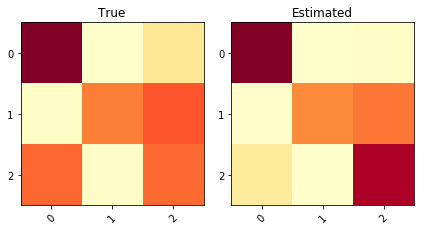

KL divergence: 0.3991	Pearson Correlation between diagonals: 0.7003


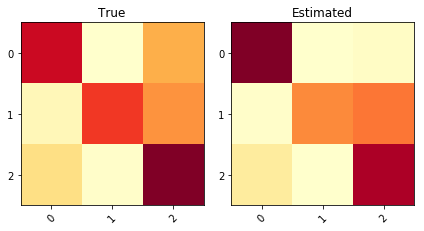

KL divergence: 0.3539	Pearson Correlation between diagonals: 0.7397


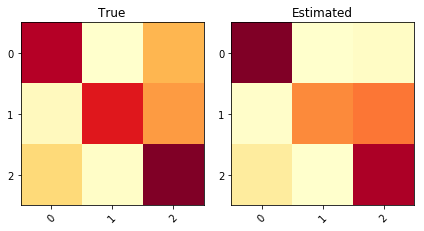

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.7920


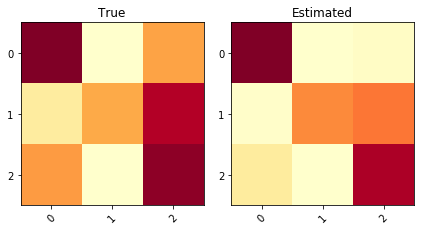

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9910


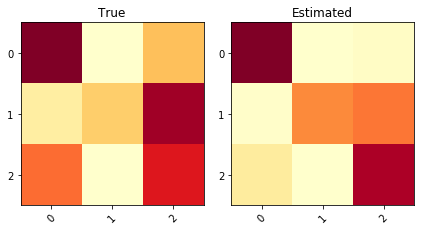

KL divergence: 0.2847	Pearson Correlation between diagonals: 0.9895


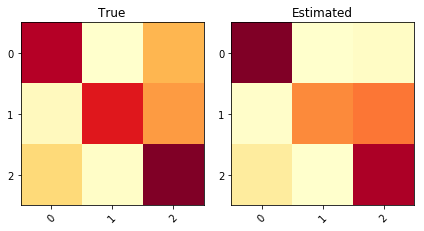

KL divergence: 0.3824	Pearson Correlation between diagonals: 0.7920


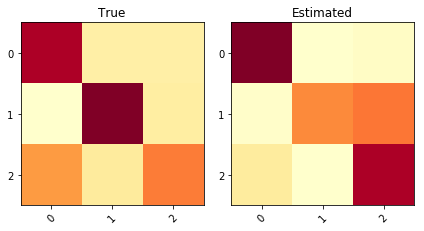

KL divergence: 0.8315	Pearson Correlation between diagonals: -0.5144


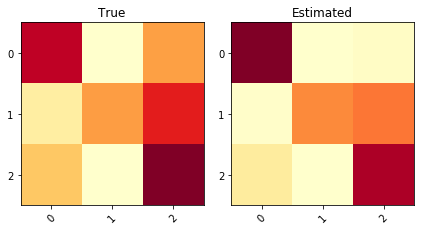

KL divergence: 0.2688	Pearson Correlation between diagonals: 0.9175


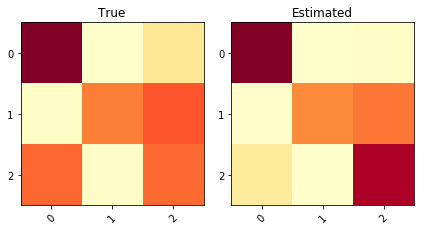

KL divergence: 0.3991	Pearson Correlation between diagonals: 0.7003


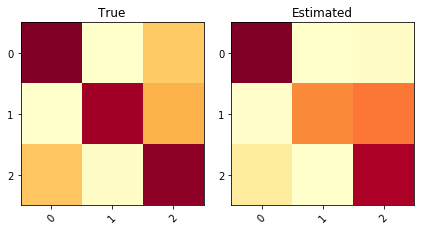

KL divergence: 0.4573	Pearson Correlation between diagonals: 0.9513


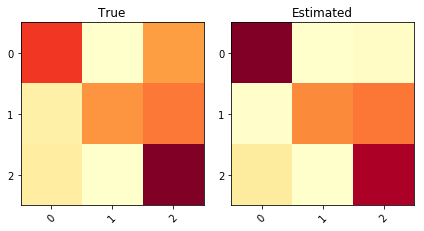

KL divergence: 0.3169	Pearson Correlation between diagonals: 0.6764


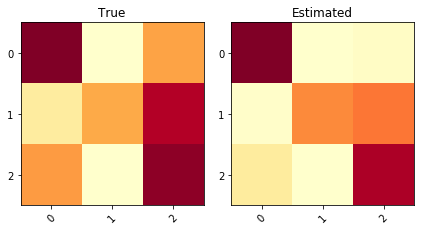

KL divergence: 0.2640	Pearson Correlation between diagonals: 0.9910


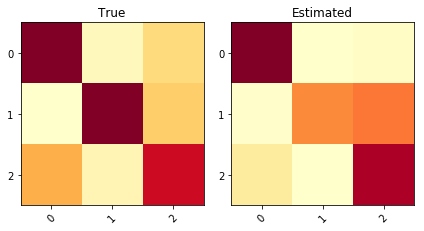

KL divergence: 0.5552	Pearson Correlation between diagonals: -0.3118


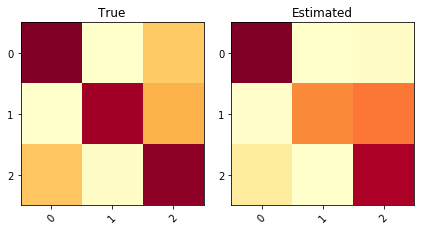

KL divergence: 0.4573	Pearson Correlation between diagonals: 0.9513


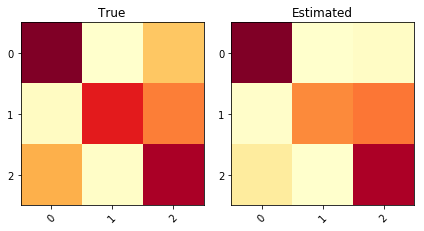

KL divergence: 0.3767	Pearson Correlation between diagonals: 0.9837
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.773708 |     0.773708 |     0.388119 |              0.731978 |
+----+--------+------------+--------------+--------------+-----------------------+


In [61]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


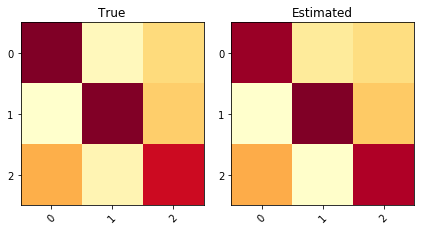

KL divergence: 0.1780	Pearson Correlation between diagonals: 0.8210


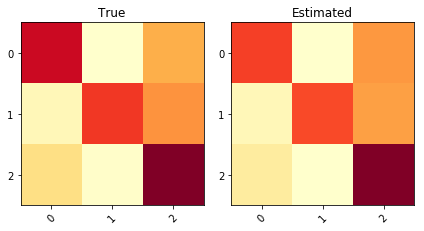

KL divergence: 0.0098	Pearson Correlation between diagonals: 0.9113


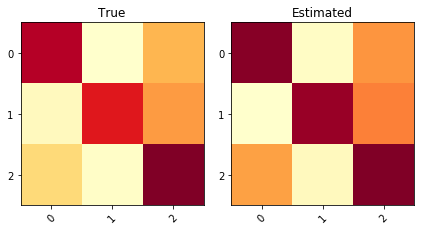

KL divergence: 0.0174	Pearson Correlation between diagonals: 0.9875


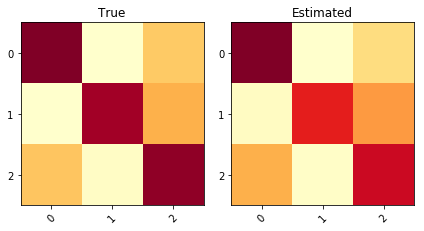

KL divergence: 0.0123	Pearson Correlation between diagonals: 0.9768


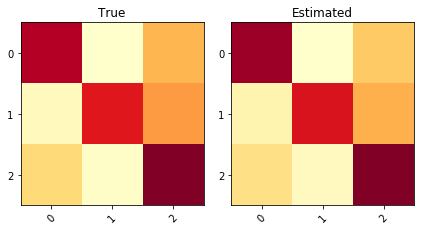

KL divergence: 0.0064	Pearson Correlation between diagonals: 0.9766


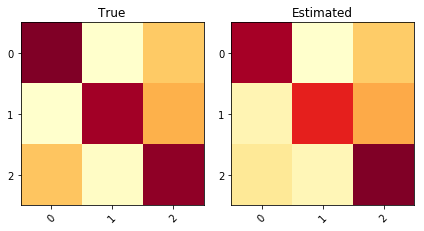

KL divergence: 0.0227	Pearson Correlation between diagonals: 0.7005


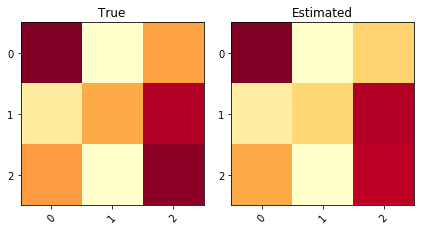

KL divergence: 0.0138	Pearson Correlation between diagonals: 0.9926


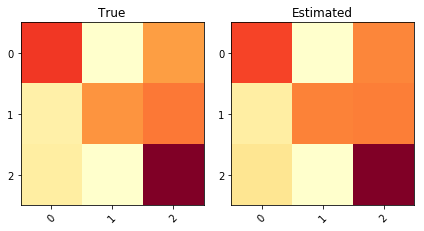

KL divergence: 0.0042	Pearson Correlation between diagonals: 0.9913


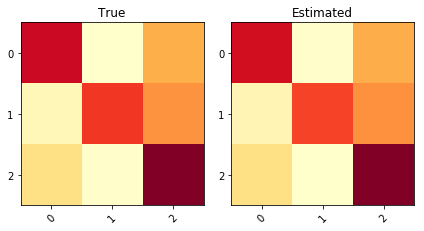

KL divergence: 0.0029	Pearson Correlation between diagonals: 0.9998


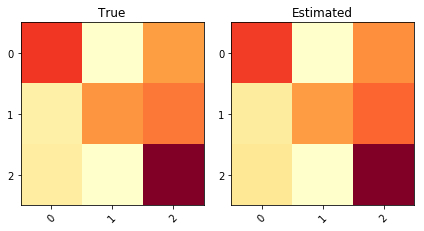

KL divergence: 0.0034	Pearson Correlation between diagonals: 1.0000


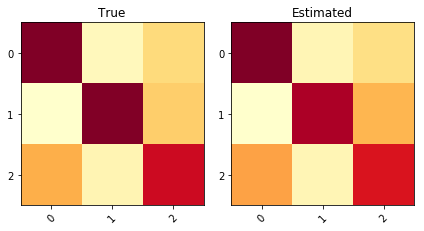

KL divergence: 0.0062	Pearson Correlation between diagonals: 0.9207


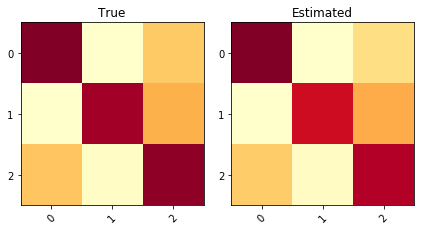

KL divergence: 0.0272	Pearson Correlation between diagonals: 0.9926


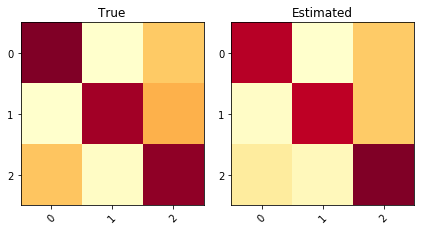

KL divergence: 0.0193	Pearson Correlation between diagonals: 0.1409


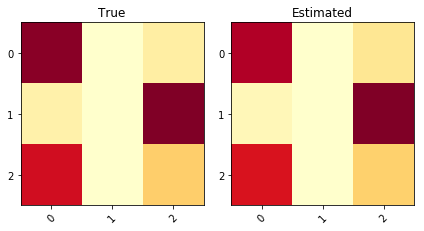

KL divergence: 0.0058	Pearson Correlation between diagonals: 0.9998


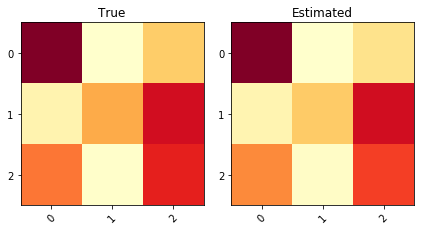

KL divergence: 0.0083	Pearson Correlation between diagonals: 0.9989
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.936508 |     0.936508 |    0.0237701 |              0.929587 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.953602 |     0.953602 |
+----+--------+------------+--------------+


In [62]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


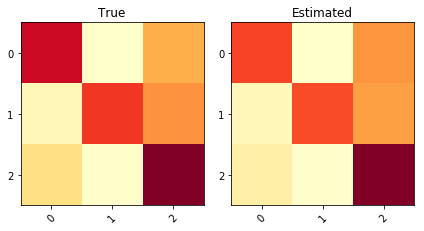

KL divergence: 0.0148	Pearson Correlation between diagonals: 0.9000


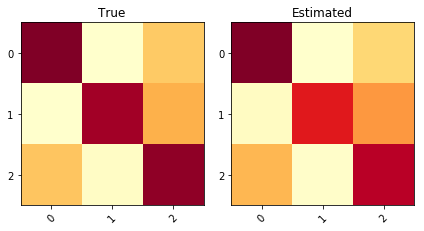

KL divergence: 0.0078	Pearson Correlation between diagonals: 0.9997


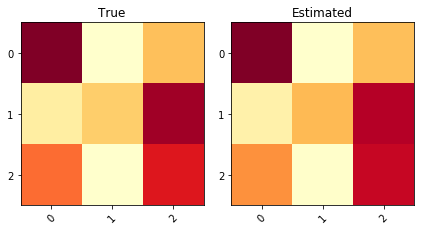

KL divergence: 0.0127	Pearson Correlation between diagonals: 0.9962


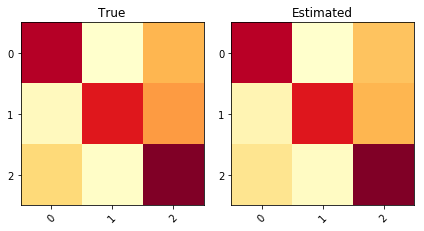

KL divergence: 0.0075	Pearson Correlation between diagonals: 0.9981


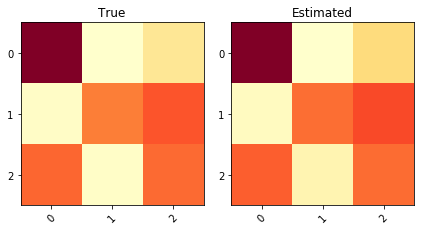

KL divergence: 0.0090	Pearson Correlation between diagonals: 0.9974


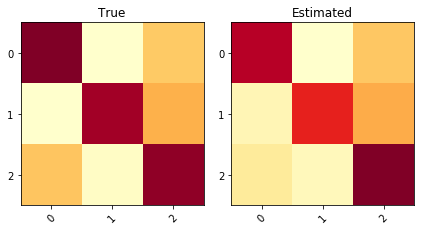

KL divergence: 0.0214	Pearson Correlation between diagonals: 0.5907


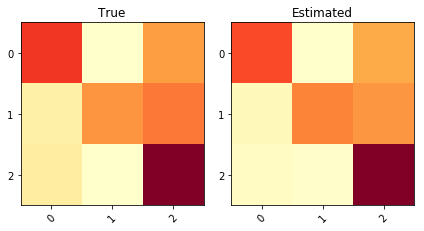

KL divergence: 0.0285	Pearson Correlation between diagonals: 0.9875


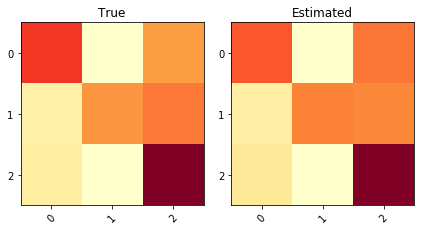

KL divergence: 0.0154	Pearson Correlation between diagonals: 0.9733


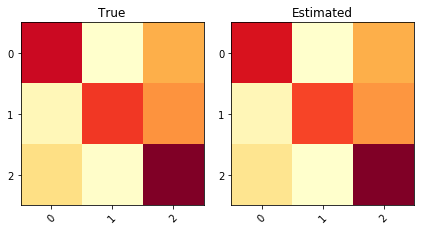

KL divergence: 0.0009	Pearson Correlation between diagonals: 0.9955


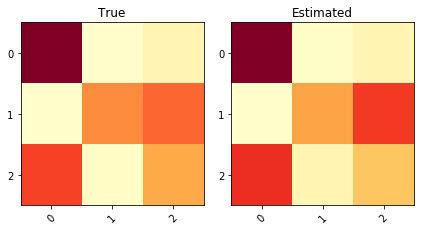

KL divergence: 0.0104	Pearson Correlation between diagonals: 0.9999


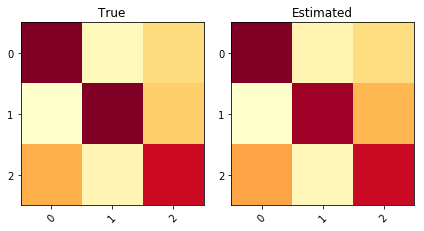

KL divergence: 0.0041	Pearson Correlation between diagonals: 0.9338


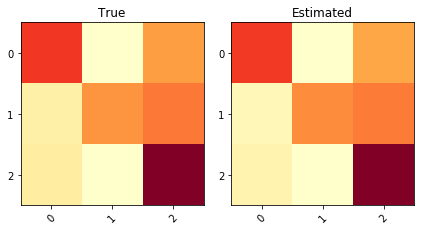

KL divergence: 0.0109	Pearson Correlation between diagonals: 0.9992


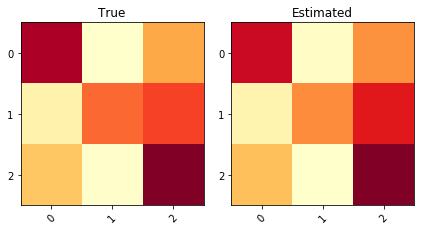

KL divergence: 0.0081	Pearson Correlation between diagonals: 0.9911


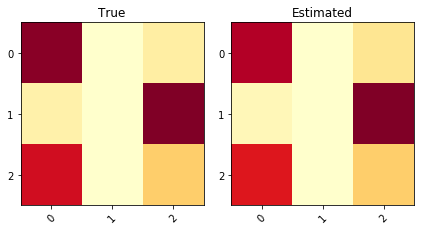

KL divergence: 0.0175	Pearson Correlation between diagonals: 0.9995


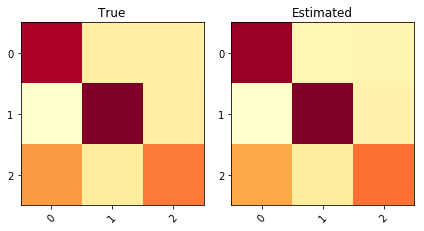

KL divergence: 0.0068	Pearson Correlation between diagonals: 0.9971
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.897436 |     0.897436 |    0.0132945 |              0.918457 |      0.0835597 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.620843 |               0.830982 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [63]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


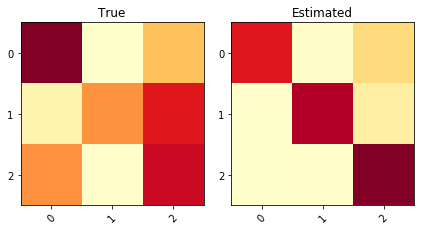

KL divergence: 0.7295	Pearson Correlation between diagonals: -0.3625


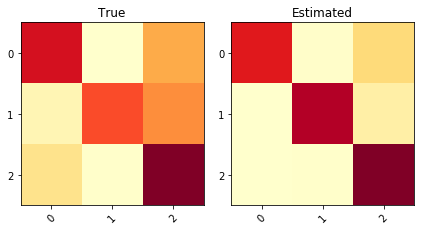

KL divergence: 0.3258	Pearson Correlation between diagonals: 0.4932


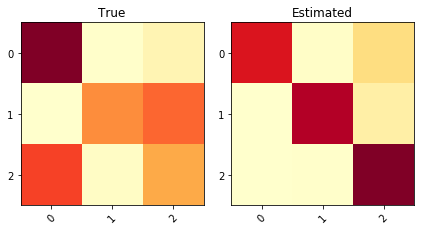

KL divergence: 1.0836	Pearson Correlation between diagonals: -0.9459


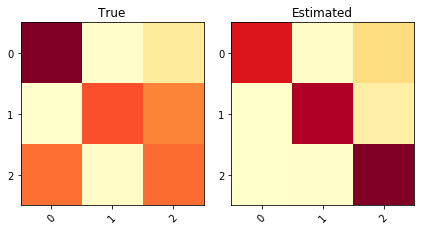

KL divergence: 0.8282	Pearson Correlation between diagonals: -0.9428


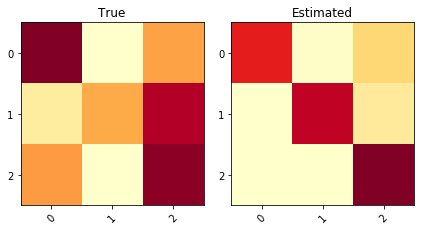

KL divergence: 0.6809	Pearson Correlation between diagonals: -0.0031


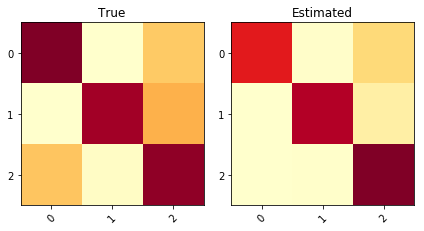

KL divergence: 0.3905	Pearson Correlation between diagonals: -0.5300


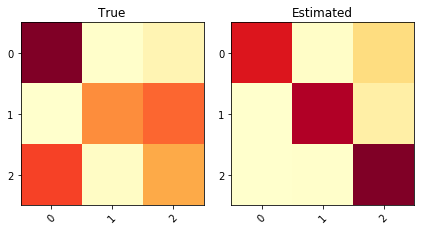

KL divergence: 1.0862	Pearson Correlation between diagonals: -0.9480


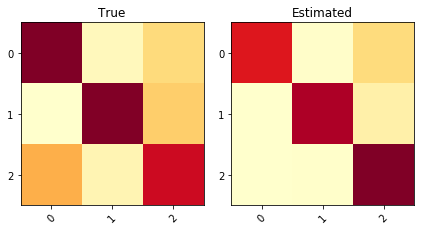

KL divergence: 0.4627	Pearson Correlation between diagonals: -0.8312


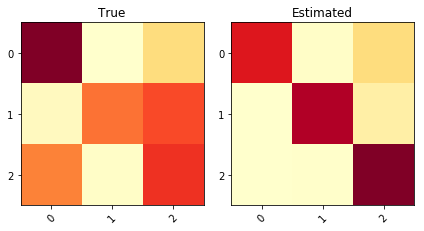

KL divergence: 0.7678	Pearson Correlation between diagonals: -0.7080


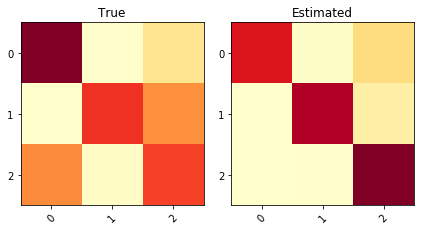

KL divergence: 0.7054	Pearson Correlation between diagonals: -0.9307


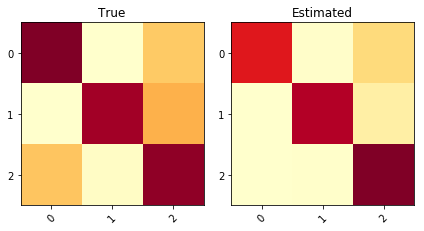

KL divergence: 0.3893	Pearson Correlation between diagonals: -0.5249


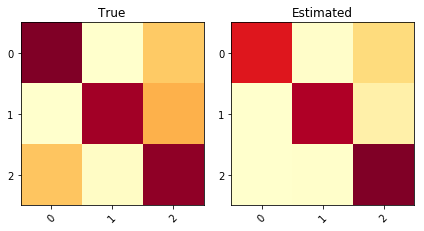

KL divergence: 0.3965	Pearson Correlation between diagonals: -0.5541


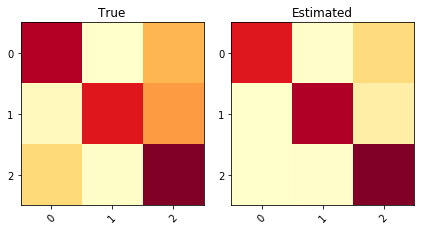

KL divergence: 0.3476	Pearson Correlation between diagonals: 0.3922


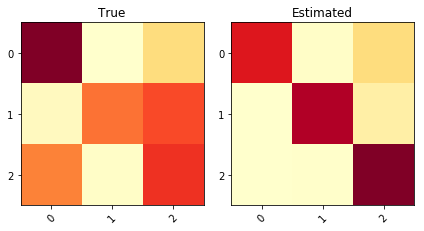

KL divergence: 0.7711	Pearson Correlation between diagonals: -0.7143


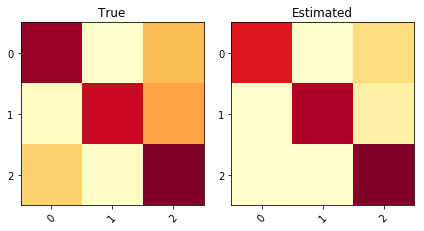

KL divergence: 0.3637	Pearson Correlation between diagonals: 0.2599
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.835572      0.835572      0.601303              -0.215989        0.077663
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.609878                 0.80208
====  =======================  ======================
Test


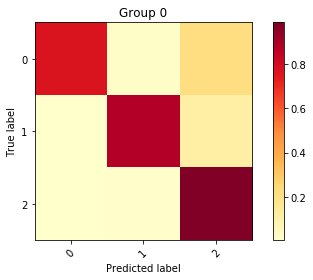

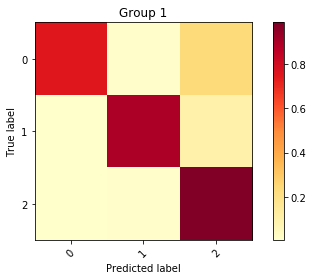

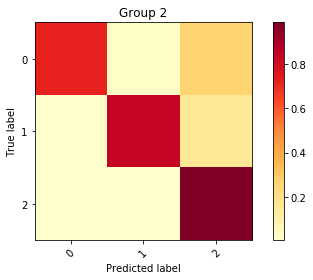

Inertia: 0.0010290469629884076
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.318627      31   0.35217      0.87944    0.133715            0.935167    0.693529      0.693529
   1         1  0.360529      36   0.34347      0.879687   0.134566            0.934933    0.713065      0.713065
   2         2  0.320844      32   0.394719     0.849438   0.171539            0.91753     0.666667      0.666667
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.831502      0.83

In [18]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


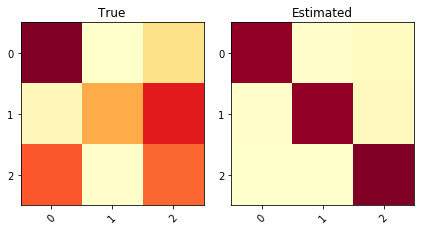

KL divergence: 1.1493	Pearson Correlation between diagonals: -0.2216


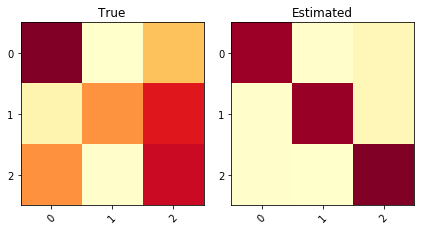

KL divergence: 0.8068	Pearson Correlation between diagonals: 0.0874


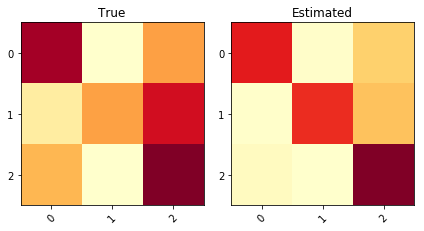

KL divergence: 0.2191	Pearson Correlation between diagonals: 0.7007


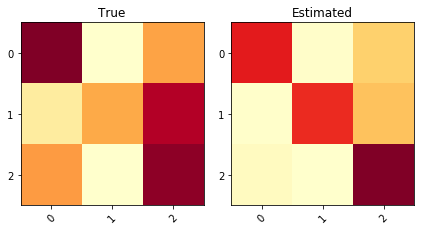

KL divergence: 0.2763	Pearson Correlation between diagonals: 0.5710


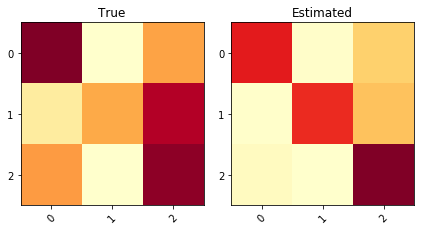

KL divergence: 0.2763	Pearson Correlation between diagonals: 0.5710


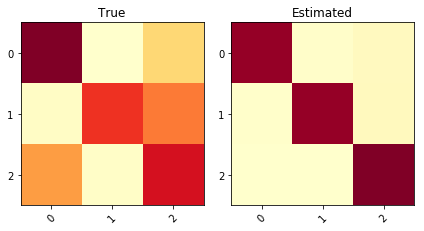

KL divergence: 0.7217	Pearson Correlation between diagonals: -0.2176


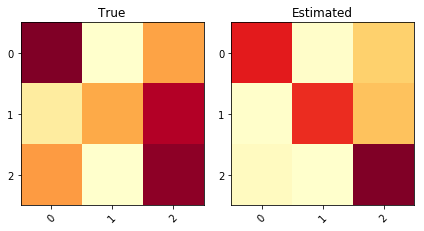

KL divergence: 0.2757	Pearson Correlation between diagonals: 0.5713


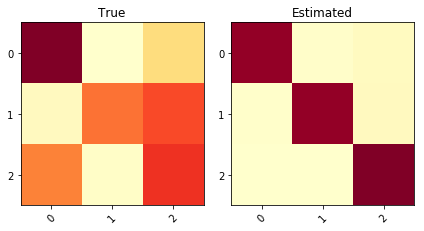

KL divergence: 0.9149	Pearson Correlation between diagonals: -0.2096


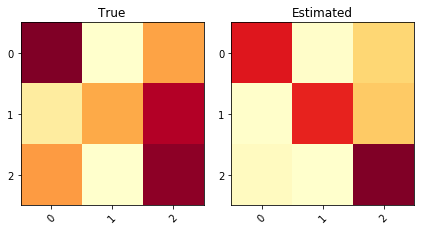

KL divergence: 0.2969	Pearson Correlation between diagonals: 0.5618


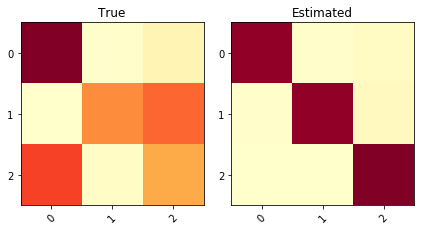

KL divergence: 1.1763	Pearson Correlation between diagonals: -0.6059


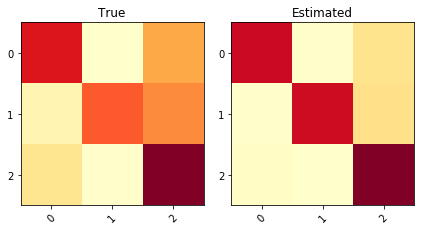

KL divergence: 0.1649	Pearson Correlation between diagonals: 0.9211


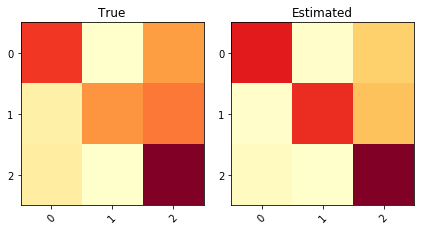

KL divergence: 0.0996	Pearson Correlation between diagonals: 0.9640


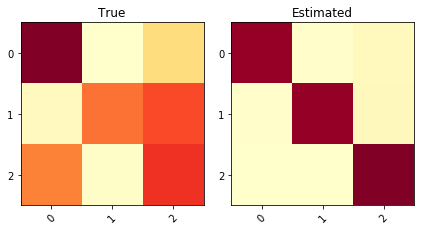

KL divergence: 0.8618	Pearson Correlation between diagonals: -0.2615


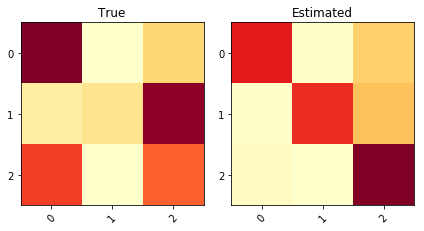

KL divergence: 0.5761	Pearson Correlation between diagonals: 0.1281


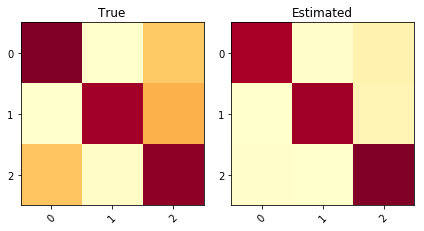

KL divergence: 0.3765	Pearson Correlation between diagonals: -0.1344
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.867318      0.867318      0.494691               0.177758       0.0633645
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.620278                0.795956
====  =======================  ======================
Test


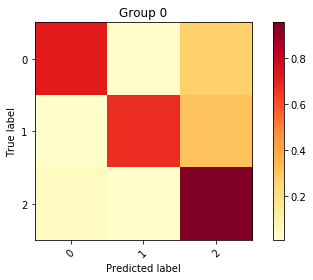

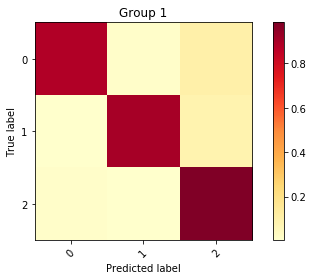

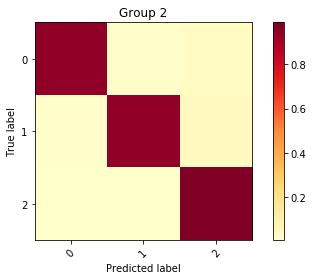

Inertia: 0.025256437249481678
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.278825      27   0.517205     0.781713  0.257974             0.877436    0.625153      0.625153
   1         1  0.367299      36   0.279537     0.923779  0.0803484            0.96043     0.741148      0.741148
   2         2  0.353876      35   0.161833     0.965909  0.0348412            0.982687    0.833944      0.833944
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.876679      0.876

In [19]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


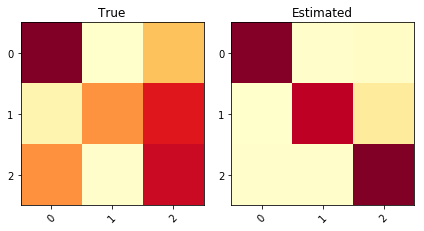

KL divergence: 0.7958	Pearson Correlation between diagonals: 0.9114


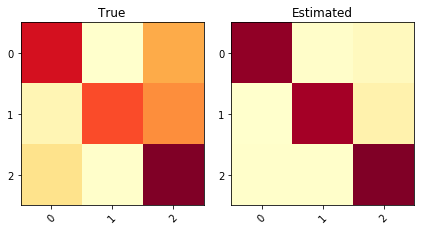

KL divergence: 0.4465	Pearson Correlation between diagonals: 0.9981


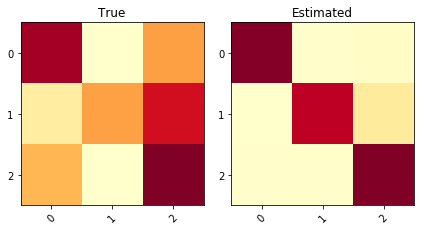

KL divergence: 0.7637	Pearson Correlation between diagonals: 0.9995


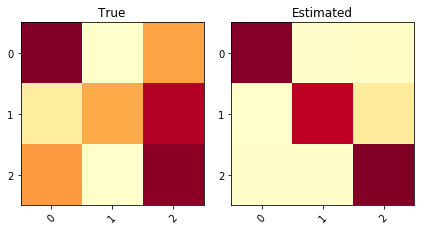

KL divergence: 0.8424	Pearson Correlation between diagonals: 0.9910


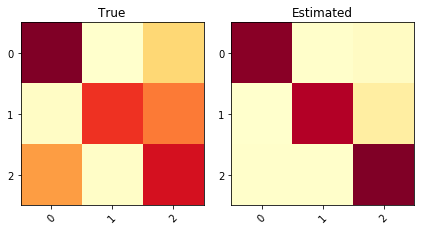

KL divergence: 0.6238	Pearson Correlation between diagonals: 0.6092


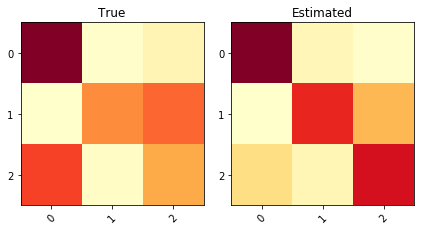

KL divergence: 0.1335	Pearson Correlation between diagonals: 0.9135


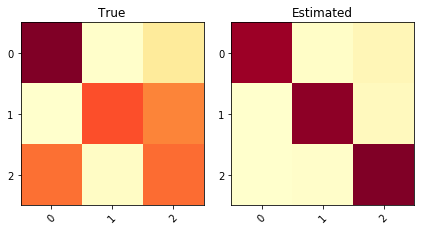

KL divergence: 0.7918	Pearson Correlation between diagonals: -0.9357


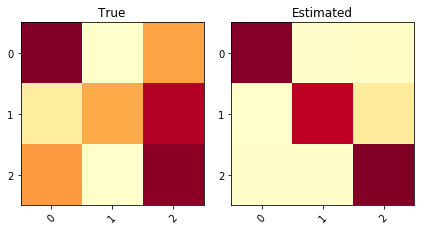

KL divergence: 0.8423	Pearson Correlation between diagonals: 0.9909


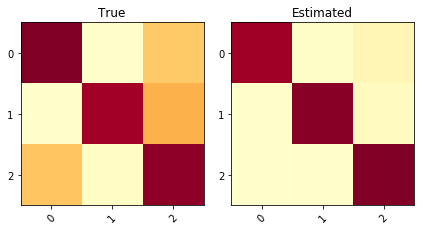

KL divergence: 0.4267	Pearson Correlation between diagonals: -0.6394


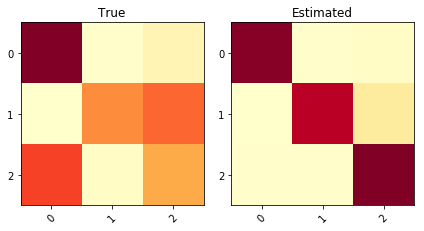

KL divergence: 0.9856	Pearson Correlation between diagonals: 0.2445


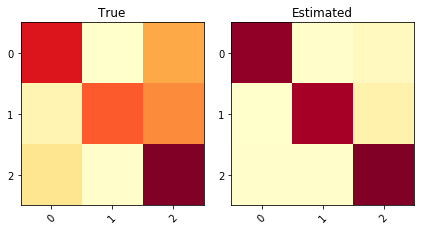

KL divergence: 0.4561	Pearson Correlation between diagonals: 0.9889


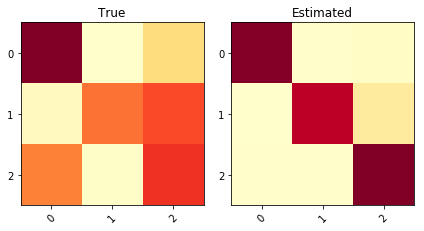

KL divergence: 0.7817	Pearson Correlation between diagonals: 0.6678


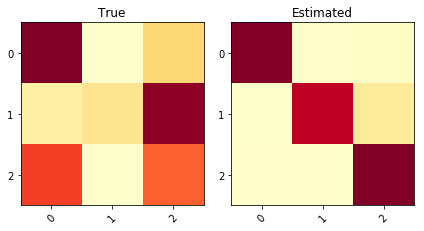

KL divergence: 1.2280	Pearson Correlation between diagonals: 0.8173


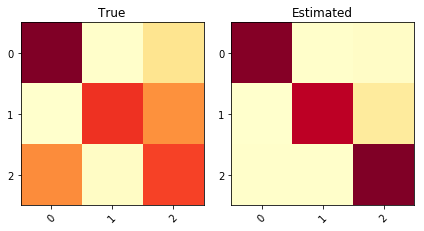

KL divergence: 0.7067	Pearson Correlation between diagonals: 0.3134


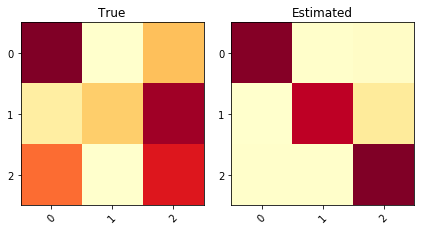

KL divergence: 1.0201	Pearson Correlation between diagonals: 0.9155
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global     0.86569       0.86569      0.662176               0.495112       0.0678795
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                   0.6247                0.802194
====  =======================  ======================
Test


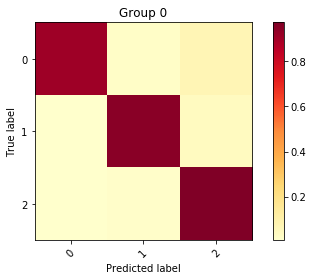

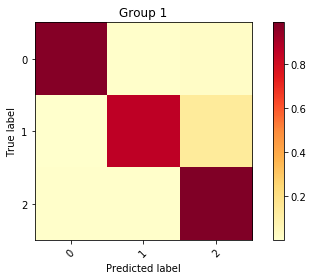

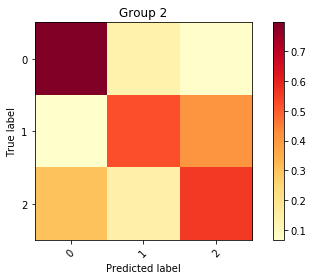

Inertia: 0.06821046412612002
A result
 ====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.256121       25   0.22889      0.946644  0.055188             0.972671    0.81685       0.81685
   1         1  0.721068       72   0.210147     0.939943  0.0638978            0.968622    0.655678      0.655678
   2         2  0.0228111       2   0.826793     0.625472  0.487204             0.77627     0.420024      0.420024
====  ========  =========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.862027      

In [20]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 20 )

In [82]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7993487993487993


*** Soft-Majority (Train with softMV) ***
Train


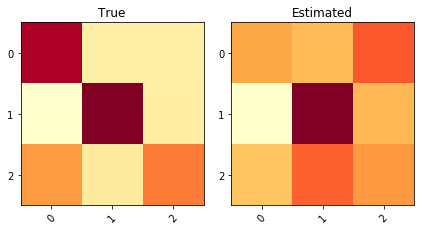

KL divergence: 0.3147	Pearson Correlation between diagonals: 0.5933


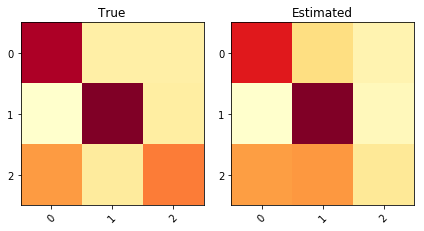

KL divergence: 0.1707	Pearson Correlation between diagonals: 0.9963


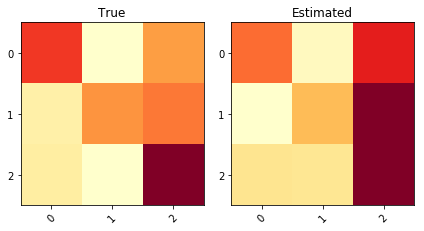

KL divergence: 0.1367	Pearson Correlation between diagonals: 0.9983


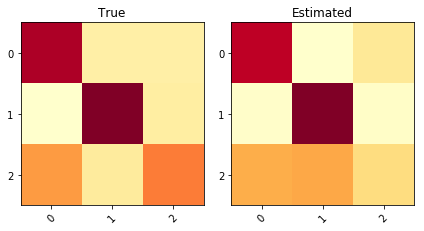

KL divergence: 0.1467	Pearson Correlation between diagonals: 0.9993


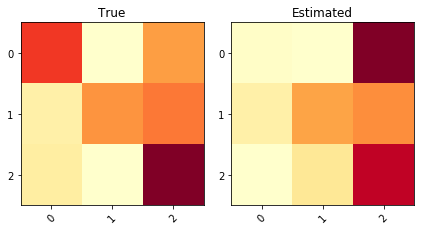

KL divergence: 0.3724	Pearson Correlation between diagonals: 0.6253


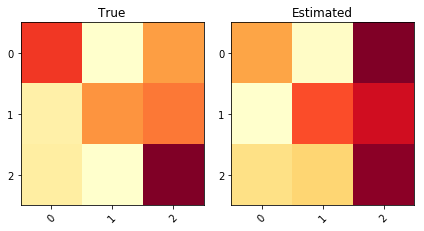

KL divergence: 0.1797	Pearson Correlation between diagonals: 0.7119


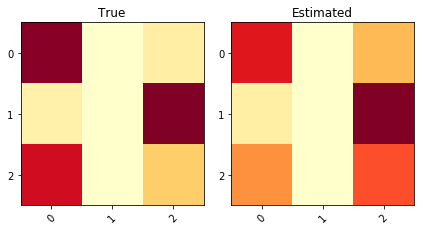

KL divergence: 0.1044	Pearson Correlation between diagonals: 0.8295


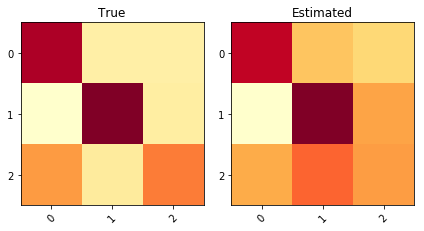

KL divergence: 0.1775	Pearson Correlation between diagonals: 0.9983


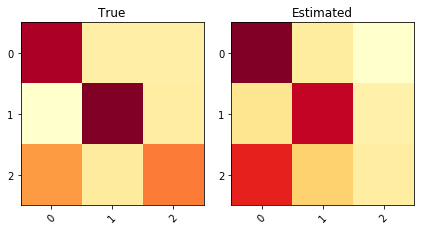

KL divergence: 0.1914	Pearson Correlation between diagonals: 0.9403


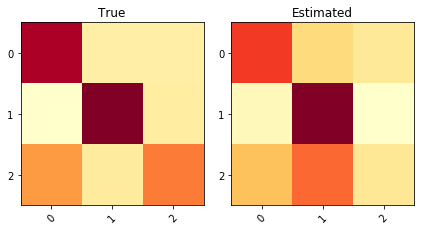

KL divergence: 0.2124	Pearson Correlation between diagonals: 0.9806


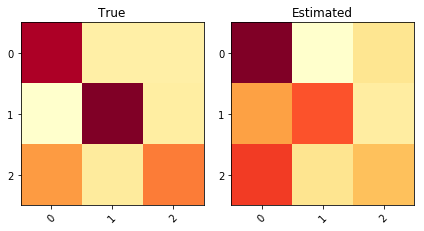

KL divergence: 0.2064	Pearson Correlation between diagonals: 0.6969


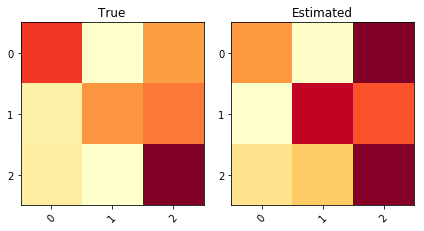

KL divergence: 0.1760	Pearson Correlation between diagonals: 0.3574


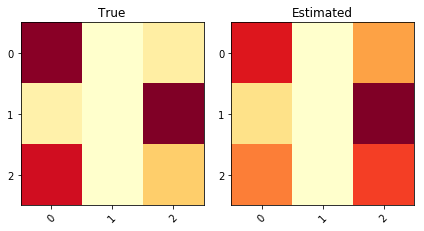

KL divergence: 0.1247	Pearson Correlation between diagonals: 0.8034


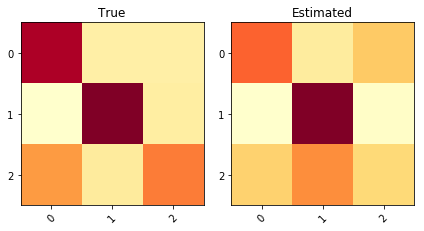

KL divergence: 0.1857	Pearson Correlation between diagonals: 0.9262


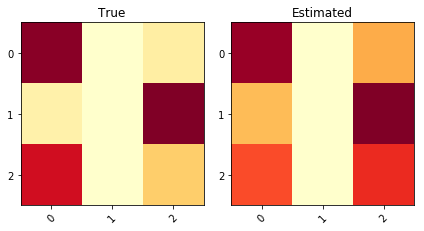

KL divergence: 0.1159	Pearson Correlation between diagonals: 0.8680
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.645096 |     0.645096 |     0.206272 |              0.810746 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.664225 |     0.664225 |
+----+--------+------------+--------------+


In [83]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


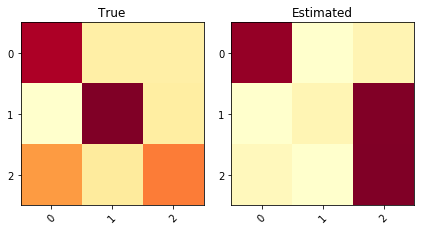

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


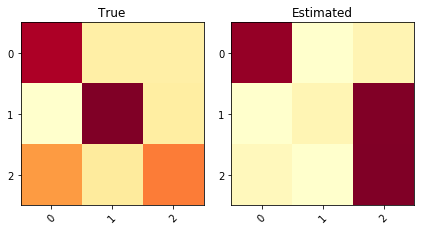

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


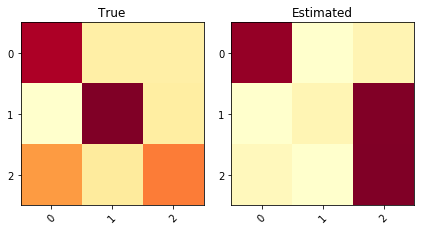

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


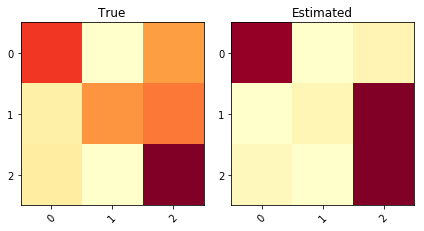

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


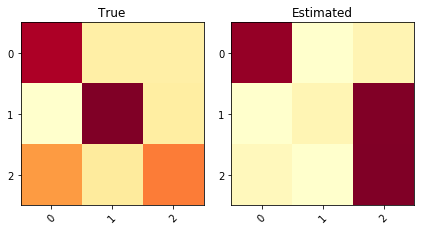

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


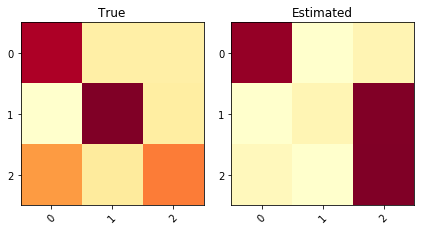

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


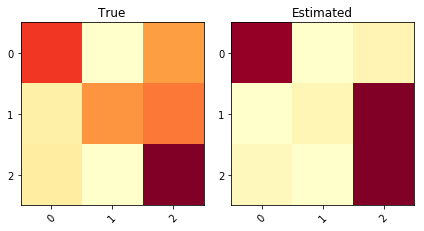

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


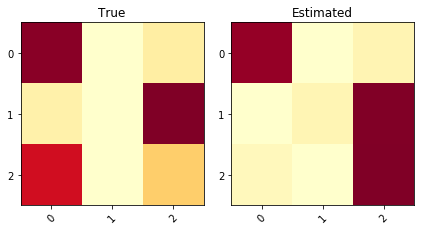

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.6941


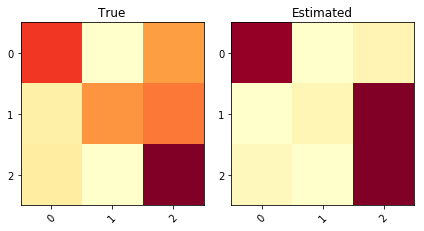

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


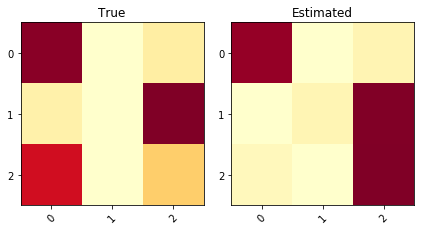

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.6941


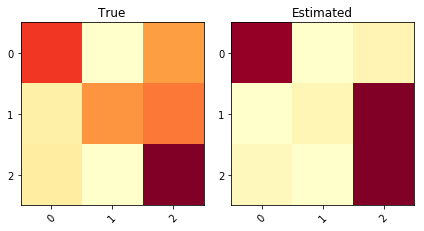

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


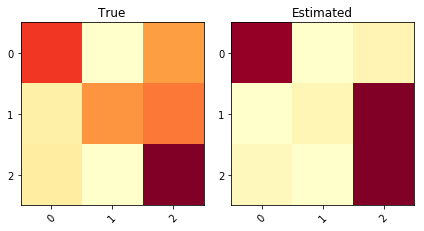

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8198


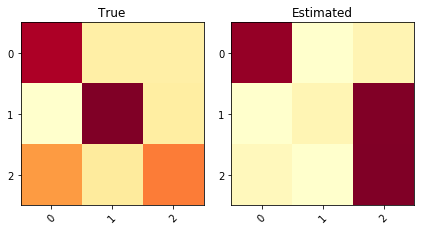

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


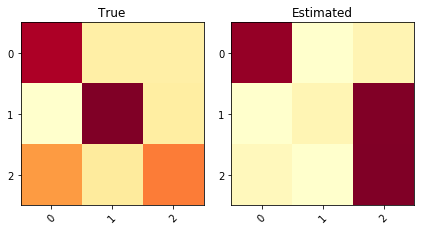

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6878


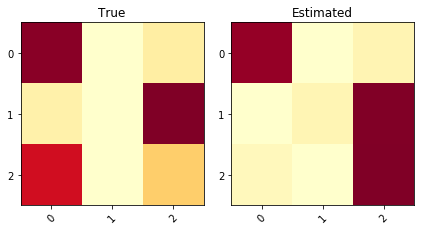

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.6941
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.645096 |     0.645096 |     0.492097 |              0.457903 |
+----+--------+------------+--------------+--------------+-----------------------+


In [84]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


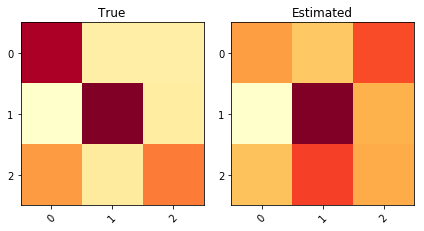

KL divergence: 0.3050	Pearson Correlation between diagonals: 0.7102


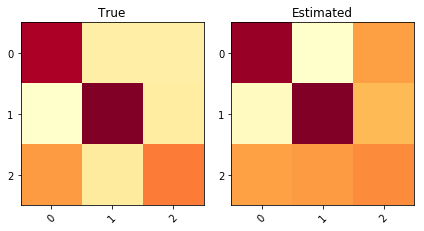

KL divergence: 0.1441	Pearson Correlation between diagonals: 0.9956


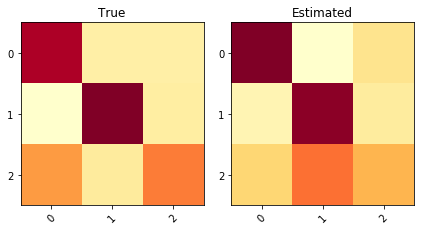

KL divergence: 0.1393	Pearson Correlation between diagonals: 0.9735


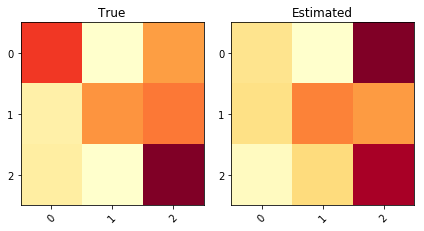

KL divergence: 0.2678	Pearson Correlation between diagonals: 0.6346


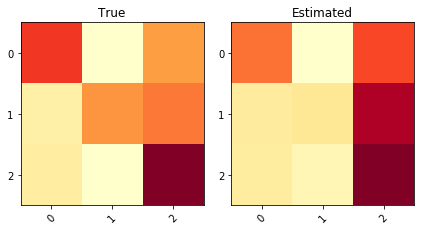

KL divergence: 0.1202	Pearson Correlation between diagonals: 0.9960


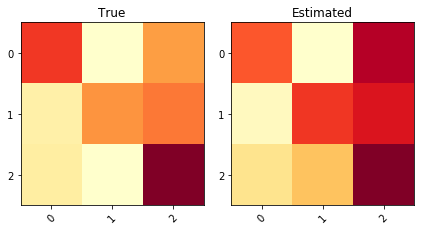

KL divergence: 0.1294	Pearson Correlation between diagonals: 0.8393


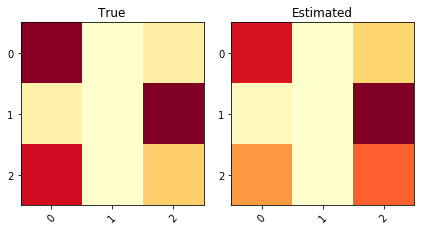

KL divergence: 0.0938	Pearson Correlation between diagonals: 0.8643


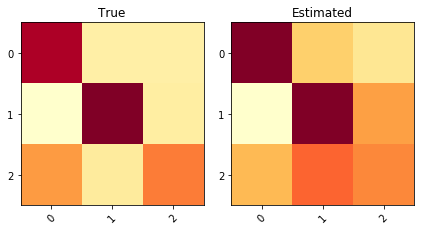

KL divergence: 0.1399	Pearson Correlation between diagonals: 0.9828


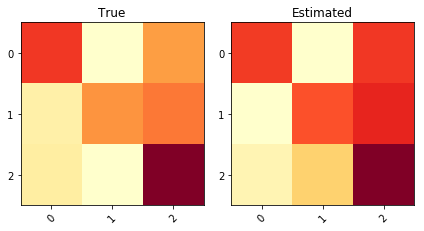

KL divergence: 0.1323	Pearson Correlation between diagonals: 0.9625


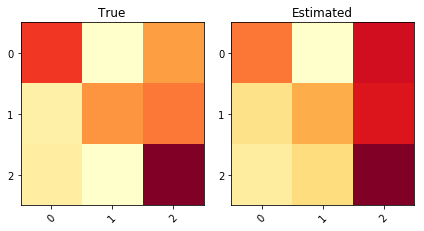

KL divergence: 0.1104	Pearson Correlation between diagonals: 0.9891


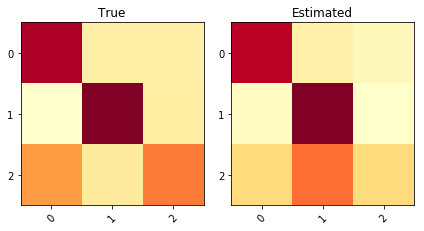

KL divergence: 0.1920	Pearson Correlation between diagonals: 0.9990


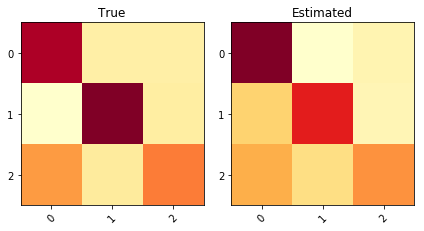

KL divergence: 0.1421	Pearson Correlation between diagonals: 0.7600


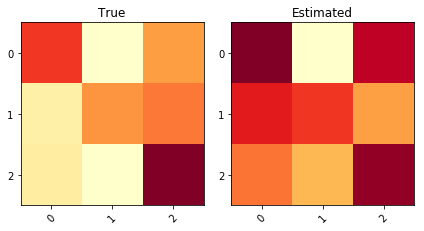

KL divergence: 0.2294	Pearson Correlation between diagonals: 0.7217


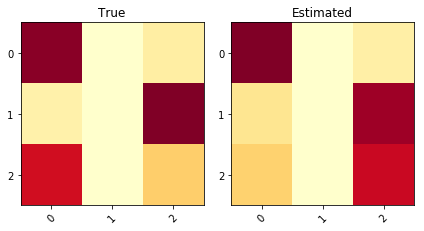

KL divergence: 0.1872	Pearson Correlation between diagonals: 0.8215


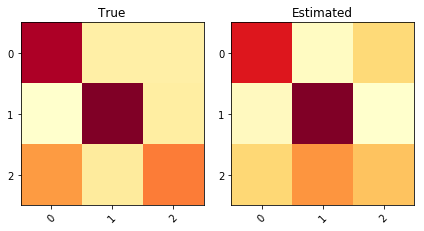

KL divergence: 0.1432	Pearson Correlation between diagonals: 0.9889
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.685389 |     0.685389 |     0.181859 |              0.810482 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.693529 |     0.693529 |
+----+--------+------------+--------------+


In [85]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


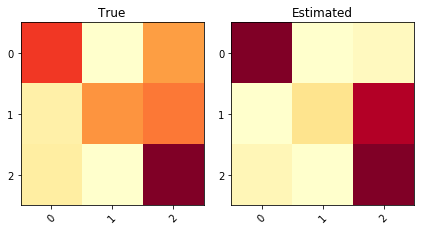

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


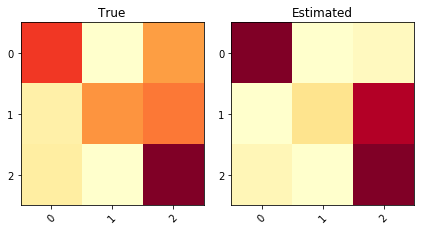

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


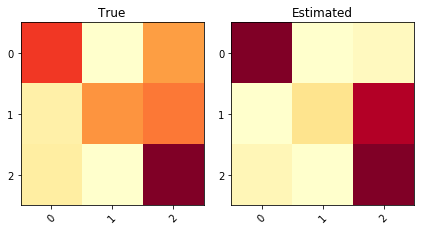

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


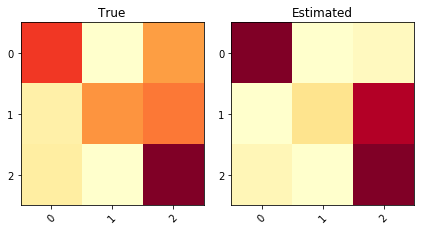

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


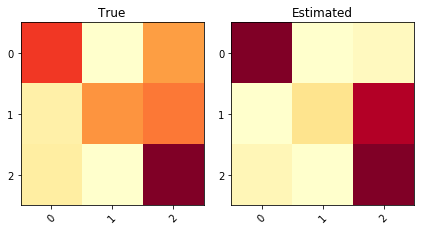

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


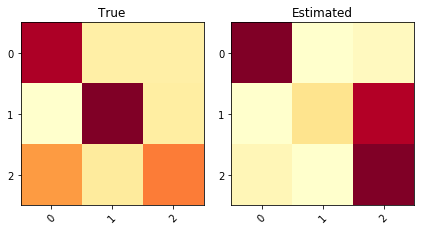

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


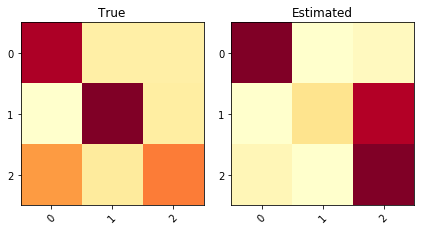

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


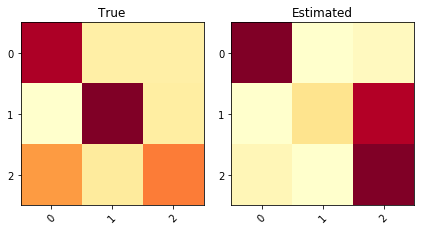

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


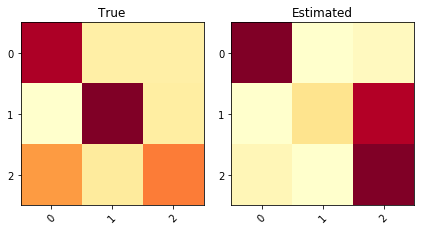

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


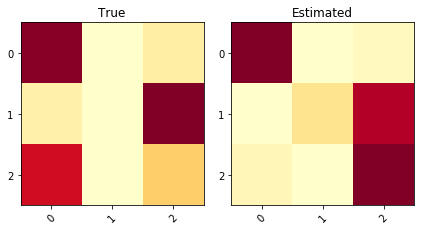

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7260


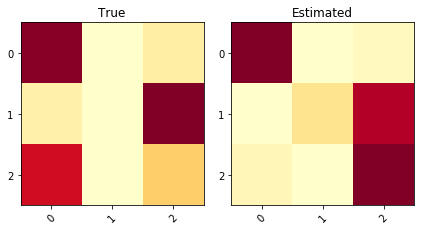

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7260


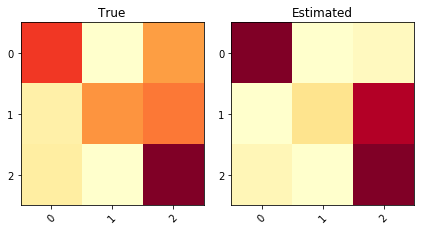

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


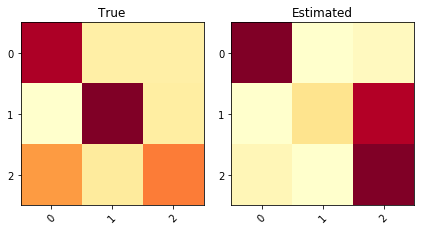

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542


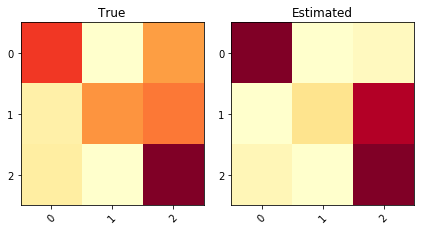

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7930


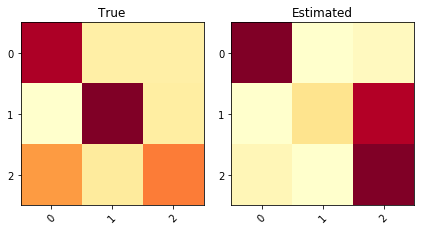

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6542
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.685389 |     0.685389 |     0.492097 |              0.456583 |
+----+--------+------------+--------------+--------------+-----------------------+


In [86]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


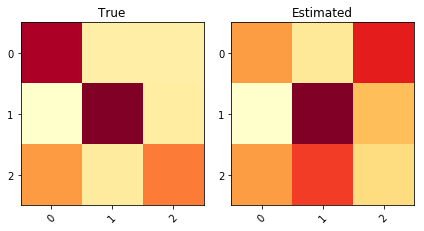

KL divergence: 0.3354	Pearson Correlation between diagonals: 0.8405


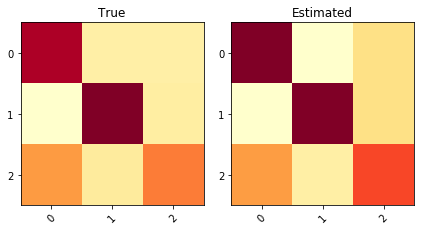

KL divergence: 0.4197	Pearson Correlation between diagonals: 0.9821


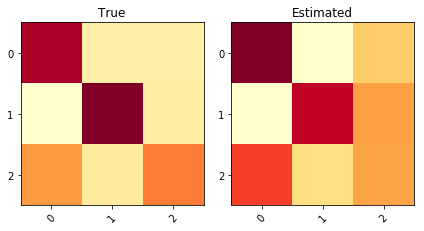

KL divergence: 0.3343	Pearson Correlation between diagonals: 0.9105


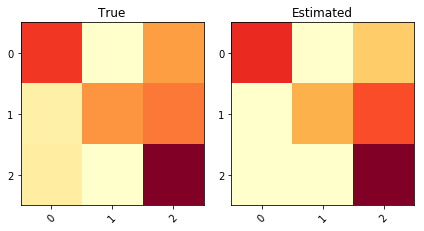

KL divergence: 0.8559	Pearson Correlation between diagonals: 0.9844


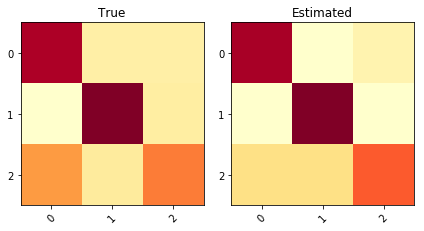

KL divergence: 0.8982	Pearson Correlation between diagonals: 1.0000


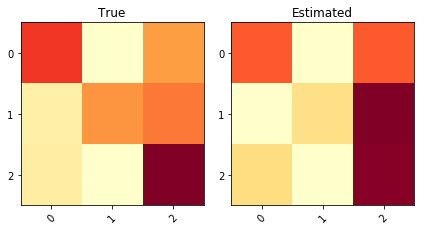

KL divergence: 0.4771	Pearson Correlation between diagonals: 0.9901


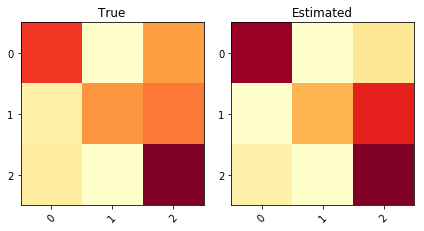

KL divergence: 0.4622	Pearson Correlation between diagonals: 0.8433


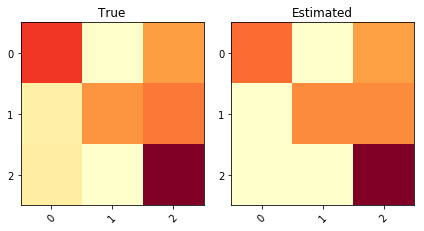

KL divergence: 0.8437	Pearson Correlation between diagonals: 0.9619


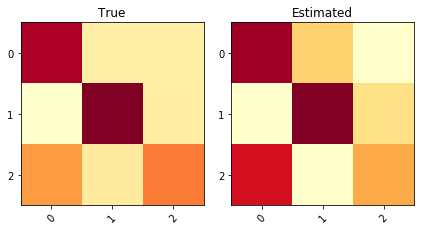

KL divergence: 0.9811	Pearson Correlation between diagonals: 0.9958


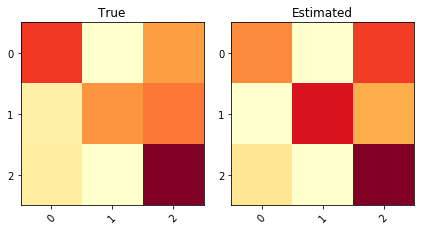

KL divergence: 0.4375	Pearson Correlation between diagonals: 0.5539


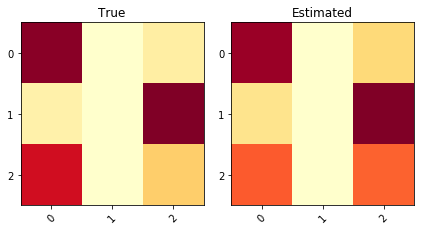

KL divergence: 0.0564	Pearson Correlation between diagonals: 0.9308


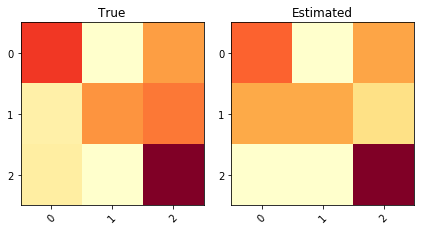

KL divergence: 0.5601	Pearson Correlation between diagonals: 0.9956


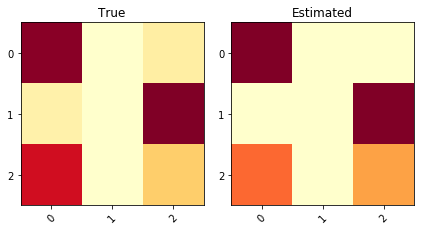

KL divergence: 0.8386	Pearson Correlation between diagonals: 0.9878


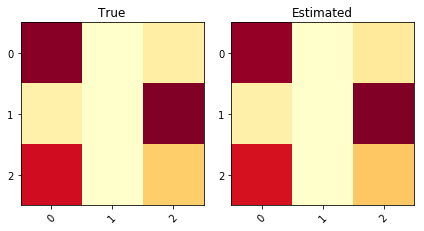

KL divergence: 0.0015	Pearson Correlation between diagonals: 0.9993


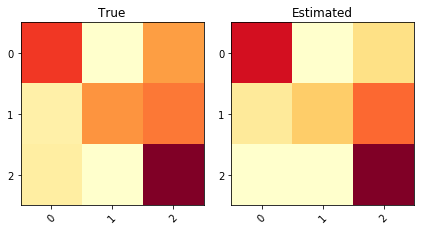

KL divergence: 0.5015	Pearson Correlation between diagonals: 0.9301
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.928368 |     0.928368 |     0.682856 |              0.871992 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.942613 |     0.942613 |
+----+--------+------------+--------------+


In [87]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


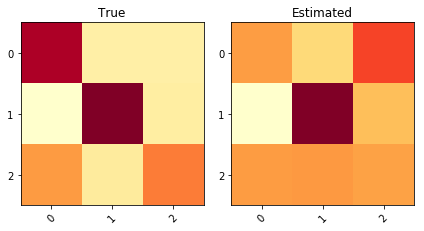

KL divergence: 0.3046	Pearson Correlation between diagonals: 0.6738


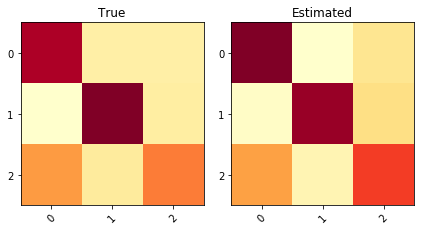

KL divergence: 0.0776	Pearson Correlation between diagonals: 0.9407


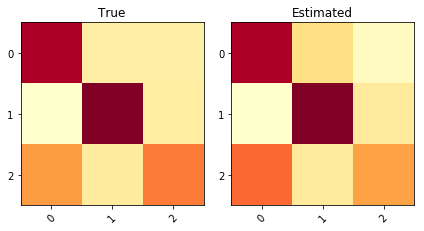

KL divergence: 0.0735	Pearson Correlation between diagonals: 0.9993


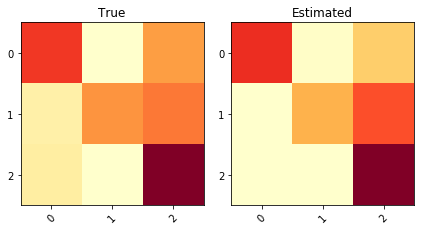

KL divergence: 0.0725	Pearson Correlation between diagonals: 0.9882


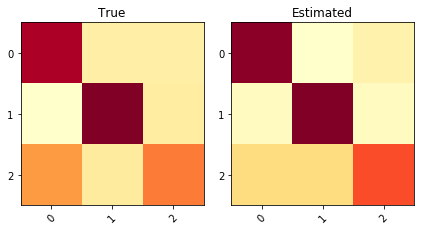

KL divergence: 0.0649	Pearson Correlation between diagonals: 0.9912


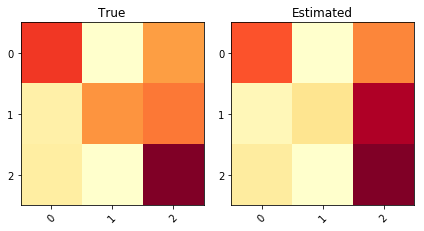

KL divergence: 0.1059	Pearson Correlation between diagonals: 0.9861


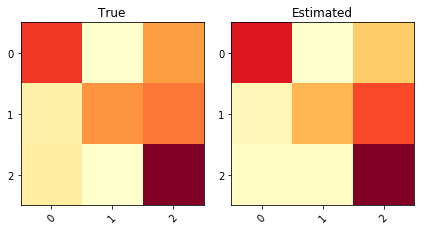

KL divergence: 0.0669	Pearson Correlation between diagonals: 0.9617


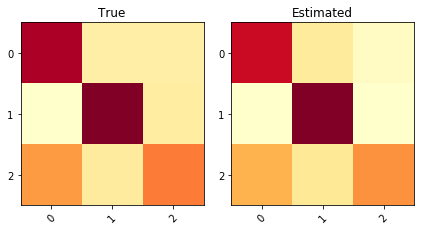

KL divergence: 0.0398	Pearson Correlation between diagonals: 0.9917


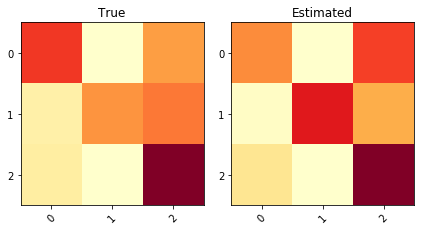

KL divergence: 0.1187	Pearson Correlation between diagonals: 0.5968


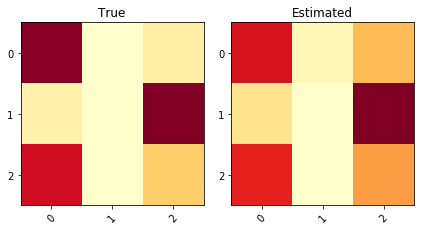

KL divergence: 0.1548	Pearson Correlation between diagonals: 0.9491


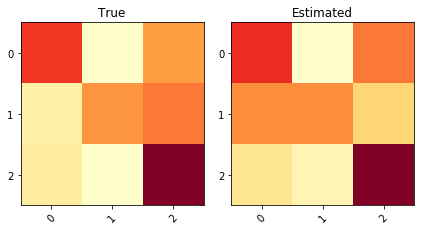

KL divergence: 0.1681	Pearson Correlation between diagonals: 0.9996


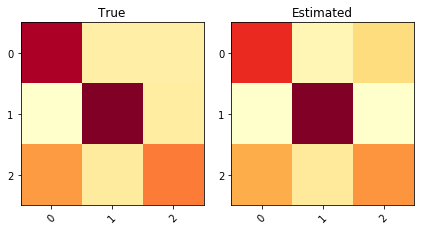

KL divergence: 0.0636	Pearson Correlation between diagonals: 0.9293


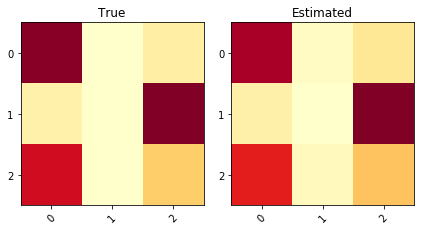

KL divergence: 0.1137	Pearson Correlation between diagonals: 0.9979


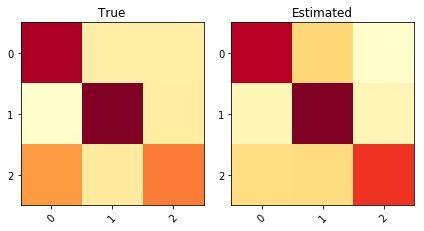

KL divergence: 0.1029	Pearson Correlation between diagonals: 0.9773


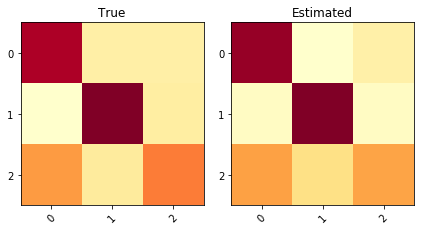

KL divergence: 0.0537	Pearson Correlation between diagonals: 0.9931
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.893366 |     0.893366 |     0.124229 |              0.879509 |       0.148146 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.686313 |               0.774009 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [88]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


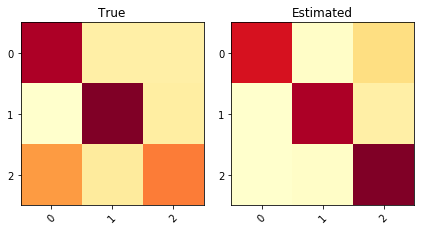

KL divergence: 0.6672	Pearson Correlation between diagonals: -0.7089


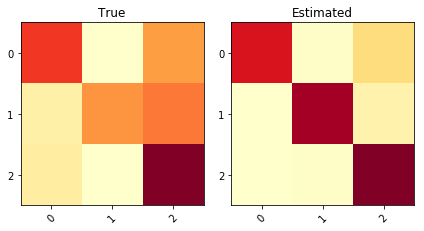

KL divergence: 0.4263	Pearson Correlation between diagonals: 0.4493


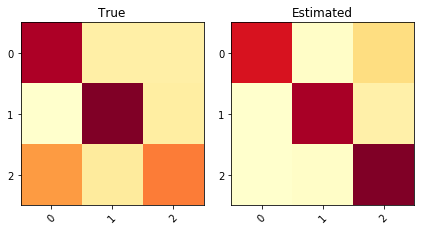

KL divergence: 0.6703	Pearson Correlation between diagonals: -0.6644


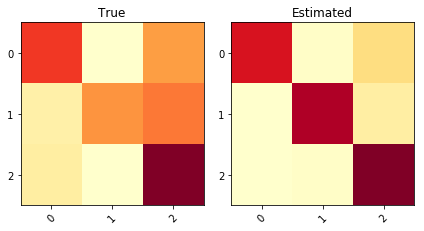

KL divergence: 0.3918	Pearson Correlation between diagonals: 0.5734


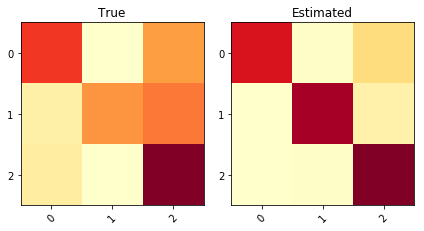

KL divergence: 0.4176	Pearson Correlation between diagonals: 0.4792


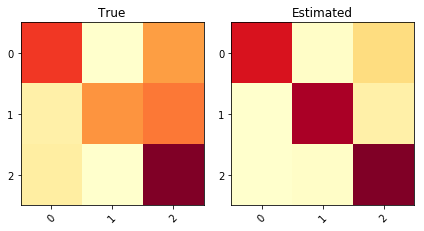

KL divergence: 0.4074	Pearson Correlation between diagonals: 0.5132


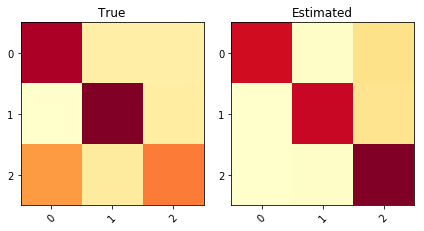

KL divergence: 0.6551	Pearson Correlation between diagonals: -0.9460


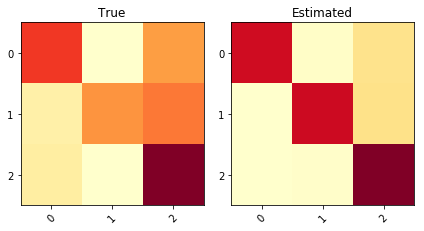

KL divergence: 0.3213	Pearson Correlation between diagonals: 0.9043


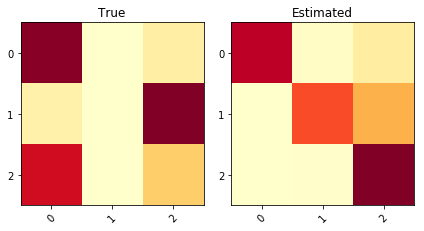

KL divergence: 1.5073	Pearson Correlation between diagonals: 0.4493


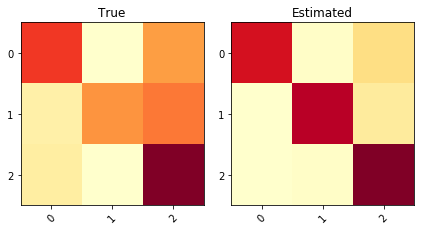

KL divergence: 0.3676	Pearson Correlation between diagonals: 0.6800


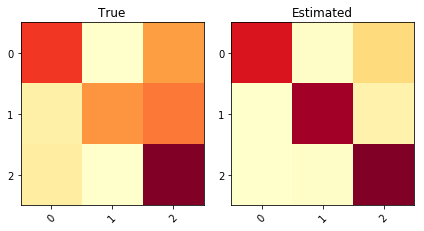

KL divergence: 0.4309	Pearson Correlation between diagonals: 0.4389


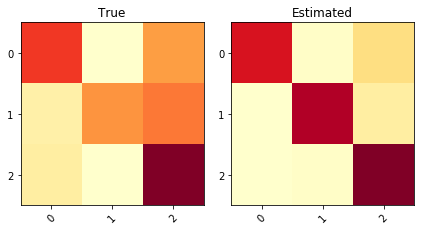

KL divergence: 0.3856	Pearson Correlation between diagonals: 0.6000


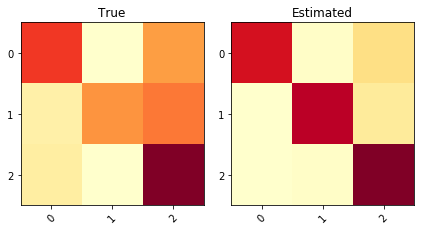

KL divergence: 0.3626	Pearson Correlation between diagonals: 0.7032


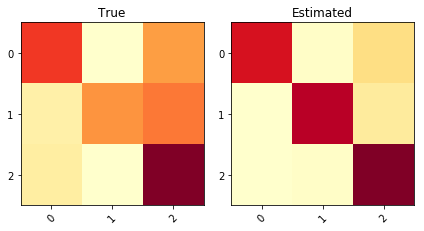

KL divergence: 0.3704	Pearson Correlation between diagonals: 0.6668


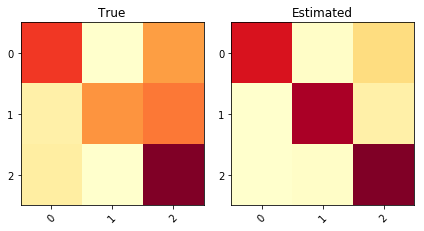

KL divergence: 0.4065	Pearson Correlation between diagonals: 0.5169
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.885633      0.885633      0.681191               0.285368        0.151039
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.641614                 0.77836
====  =======================  ======================
Test


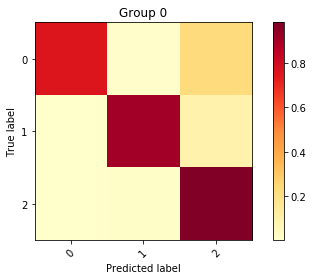

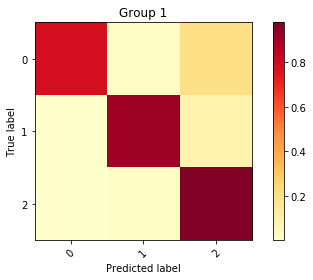

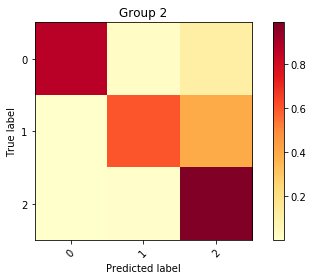

Inertia: 0.01795592573277342
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.505745    1011   0.33249      0.884041   0.129105            0.937487    0.781441      0.781441
   1         1  0.25079      501   0.334497     0.891974   0.118614            0.942314    0.814408      0.814408
   2         2  0.243465     486   0.399475     0.820174   0.219063            0.897094    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.882784      0.8827

In [40]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


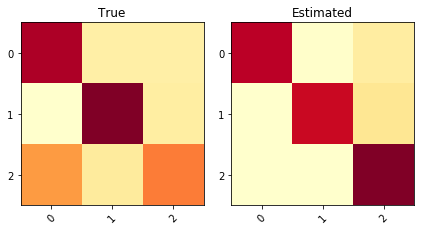

KL divergence: 0.7430	Pearson Correlation between diagonals: -0.9992


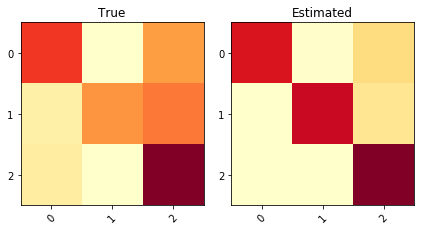

KL divergence: 0.2764	Pearson Correlation between diagonals: 0.7976


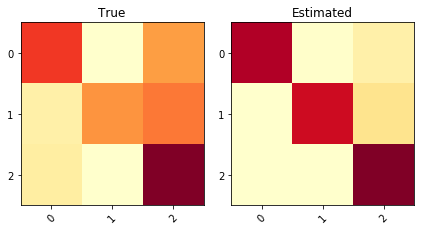

KL divergence: 0.3405	Pearson Correlation between diagonals: 0.9994


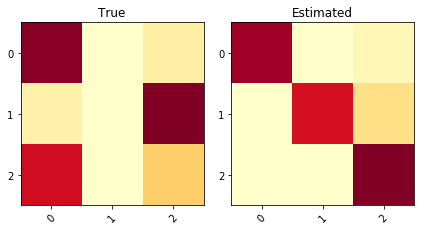

KL divergence: 1.7291	Pearson Correlation between diagonals: 0.4784


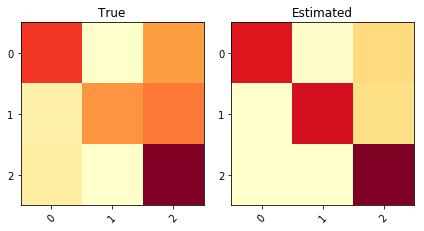

KL divergence: 0.2401	Pearson Correlation between diagonals: 0.8675


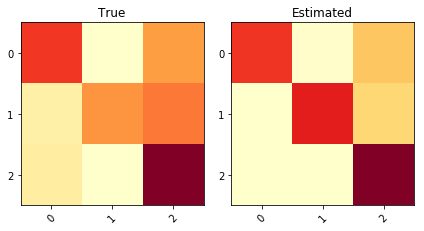

KL divergence: 0.1791	Pearson Correlation between diagonals: 0.8397


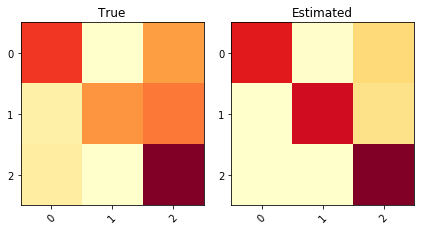

KL divergence: 0.2434	Pearson Correlation between diagonals: 0.8153


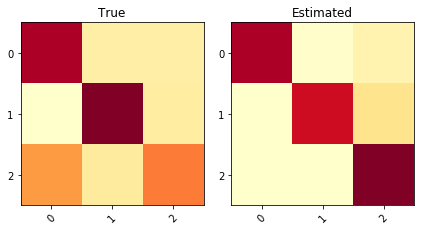

KL divergence: 0.7320	Pearson Correlation between diagonals: -0.9434


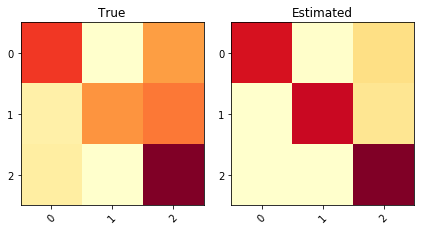

KL divergence: 0.2815	Pearson Correlation between diagonals: 0.8342


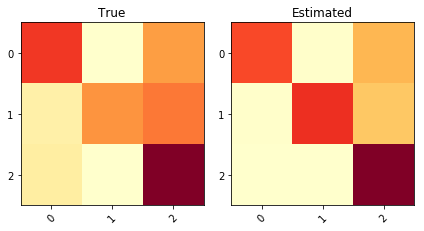

KL divergence: 0.1471	Pearson Correlation between diagonals: 0.8544


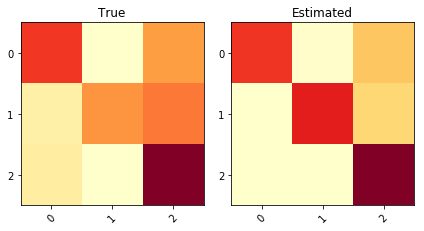

KL divergence: 0.1792	Pearson Correlation between diagonals: 0.8414


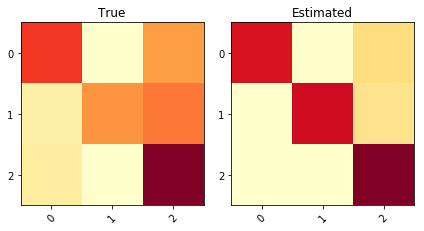

KL divergence: 0.2555	Pearson Correlation between diagonals: 0.8443


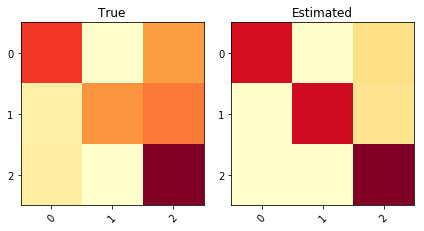

KL divergence: 0.2709	Pearson Correlation between diagonals: 0.8792


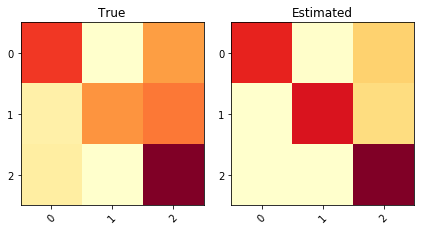

KL divergence: 0.2104	Pearson Correlation between diagonals: 0.8398


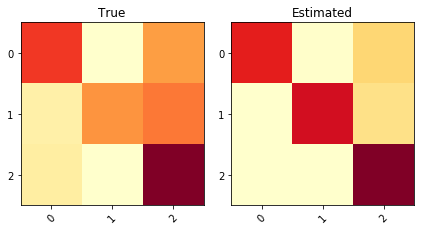

KL divergence: 0.2329	Pearson Correlation between diagonals: 0.8157
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.882784      0.882784      0.657543               0.317836        0.161282
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.624604                0.771551
====  =======================  ======================
Test


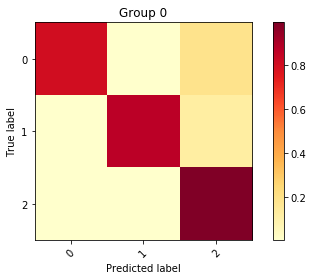

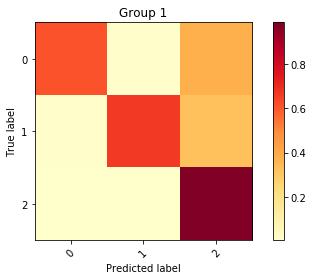

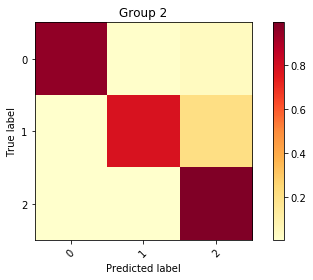

Inertia: 0.023236392841984827
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.500325    1000   0.313571     0.892594  0.11733              0.942833    0.752137      0.752137
   1         1  0.214898     429   0.491921     0.754684  0.304182             0.857785    0.579976      0.579976
   2         2  0.284777     569   0.266467     0.910726  0.0988627            0.952045    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.879121      0.879

In [20]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


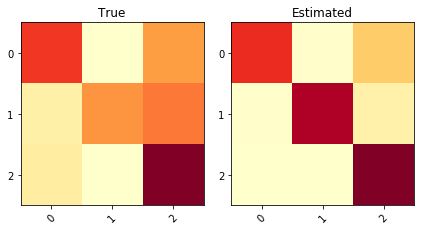

KL divergence: 0.3303	Pearson Correlation between diagonals: 0.4576


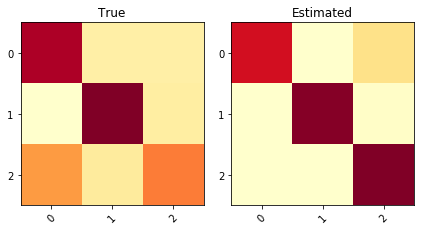

KL divergence: 0.8789	Pearson Correlation between diagonals: -0.3843


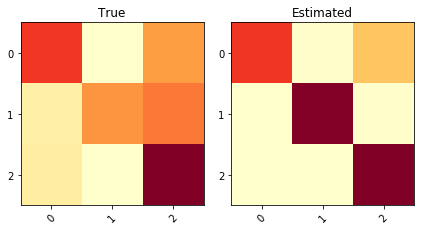

KL divergence: 0.6465	Pearson Correlation between diagonals: 0.1591


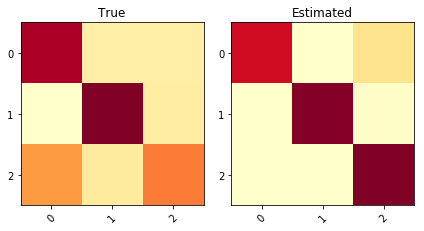

KL divergence: 0.8939	Pearson Correlation between diagonals: -0.3892


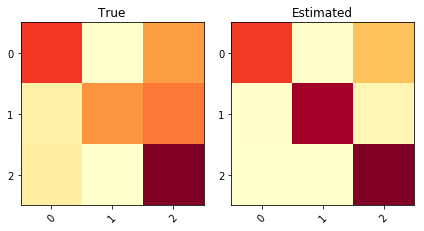

KL divergence: 0.3662	Pearson Correlation between diagonals: 0.3352


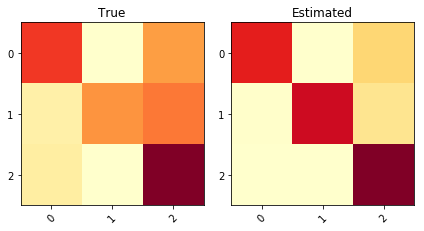

KL divergence: 0.2546	Pearson Correlation between diagonals: 0.7655


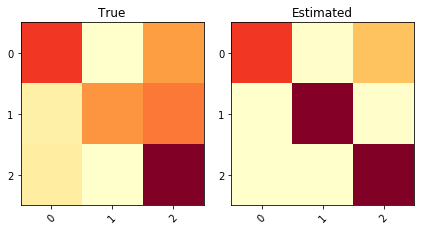

KL divergence: 0.6446	Pearson Correlation between diagonals: 0.1590


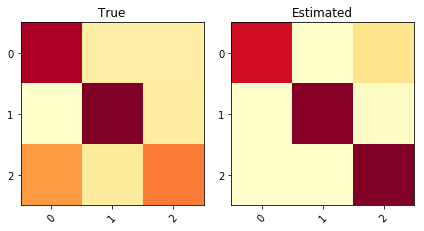

KL divergence: 0.8885	Pearson Correlation between diagonals: -0.4032


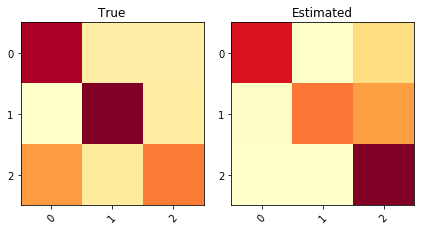

KL divergence: 0.9118	Pearson Correlation between diagonals: -0.9400


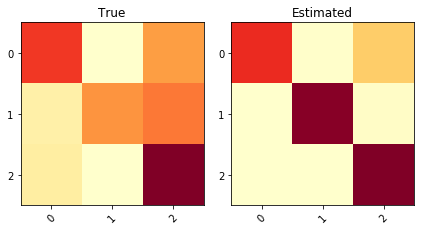

KL divergence: 0.5951	Pearson Correlation between diagonals: 0.1808


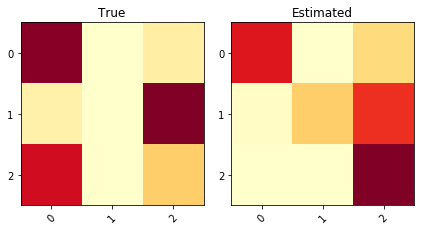

KL divergence: 1.4306	Pearson Correlation between diagonals: 0.4677


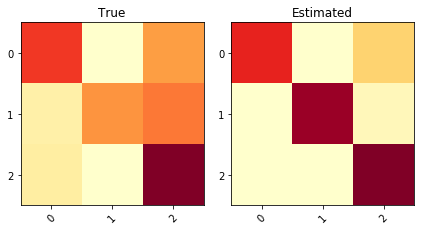

KL divergence: 0.4281	Pearson Correlation between diagonals: 0.3181


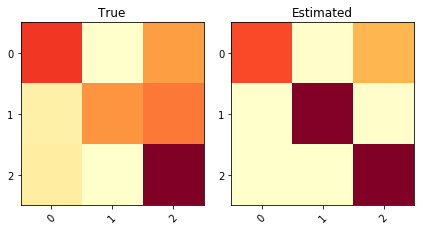

KL divergence: 0.6455	Pearson Correlation between diagonals: 0.1526


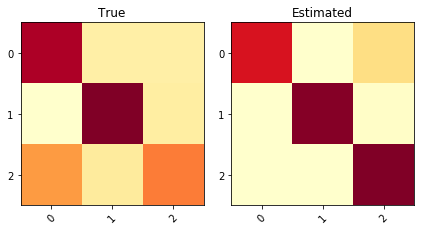

KL divergence: 0.8648	Pearson Correlation between diagonals: -0.3787


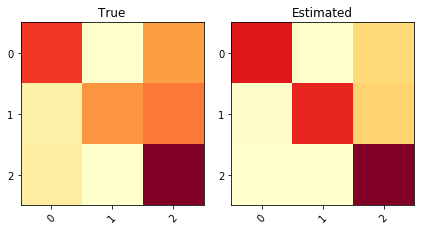

KL divergence: 0.2032	Pearson Correlation between diagonals: 0.9584
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.876272      0.876272      0.712917               0.297452        0.122832
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.673152                0.738386
====  =======================  ======================
Test


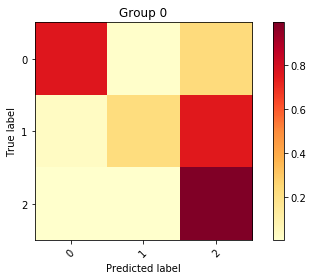

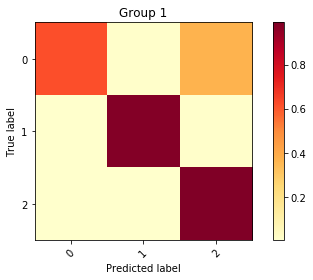

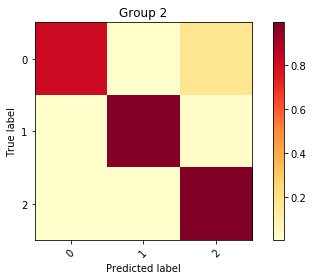

Inertia: 0.08536398534973462
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.283922     567   0.41873      0.659798   0.592301            0.761909    0.652015      0.652015
   1         1  0.222922     445   0.291329     0.864086   0.168514            0.921248    0.871795      0.871795
   2         2  0.493156     986   0.205484     0.932671   0.073541            0.96417     0.90232       0.90232
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.884005      0.88400

In [21]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T=5000, T_{data}=40$)

In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8131868131868132


*** Soft-Majority (Train with softMV) ***
Train


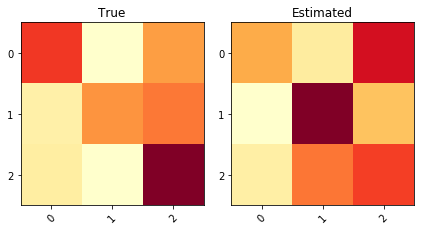

KL divergence: 0.3518	Pearson Correlation between diagonals: -0.4456


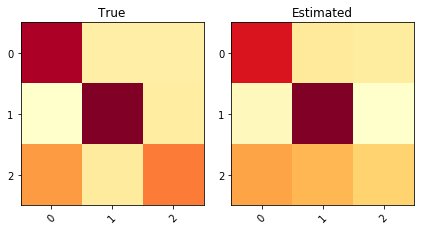

KL divergence: 0.1048	Pearson Correlation between diagonals: 0.9942


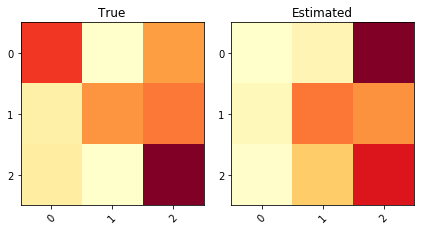

KL divergence: 0.4201	Pearson Correlation between diagonals: 0.4068


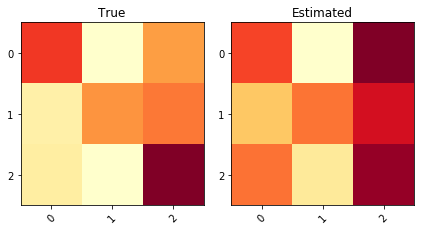

KL divergence: 0.1523	Pearson Correlation between diagonals: 0.9883


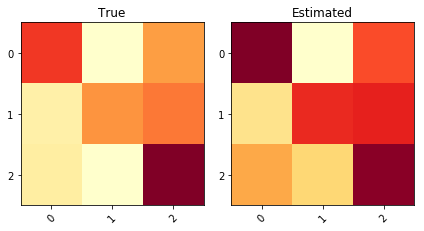

KL divergence: 0.1499	Pearson Correlation between diagonals: 0.7495


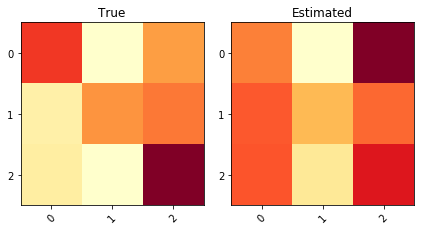

KL divergence: 0.2750	Pearson Correlation between diagonals: 0.9993


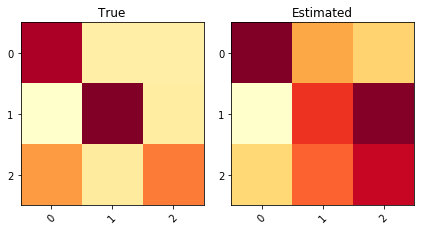

KL divergence: 0.2922	Pearson Correlation between diagonals: -0.1839


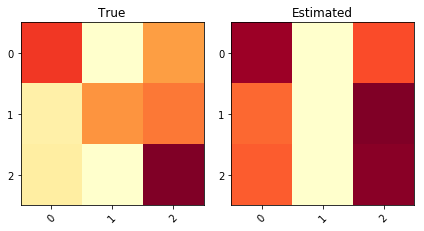

KL divergence: 2.1344	Pearson Correlation between diagonals: 0.8157


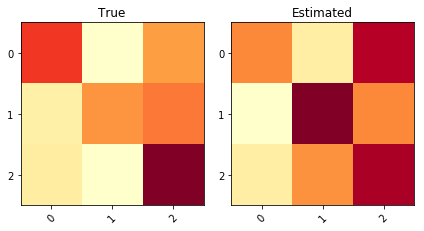

KL divergence: 0.2367	Pearson Correlation between diagonals: -0.0405


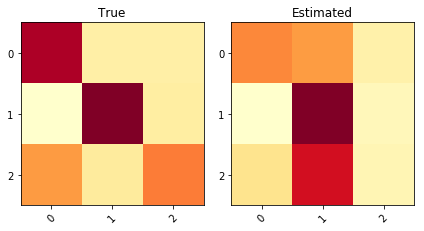

KL divergence: 0.3998	Pearson Correlation between diagonals: 0.9350


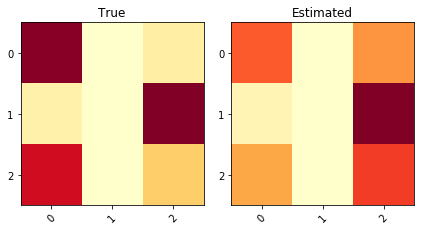

KL divergence: 0.1809	Pearson Correlation between diagonals: 0.6578


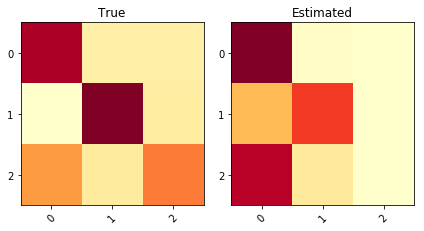

KL divergence: 3.3401	Pearson Correlation between diagonals: 0.8688


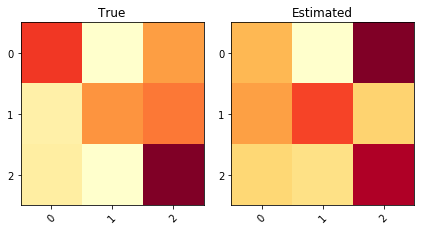

KL divergence: 0.2596	Pearson Correlation between diagonals: 0.5642


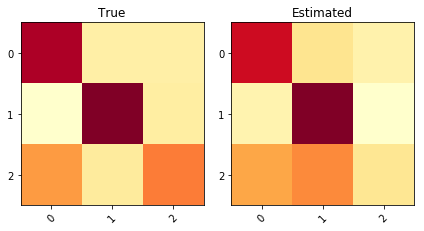

KL divergence: 0.1707	Pearson Correlation between diagonals: 0.9999


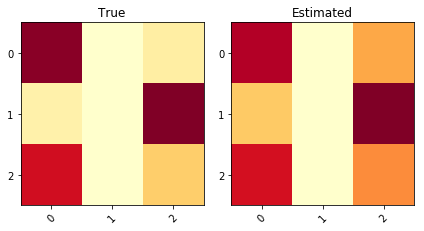

KL divergence: 0.0768	Pearson Correlation between diagonals: 0.9522
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.679691 |     0.679691 |     0.583063 |                0.6921 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.69475 |      0.69475 |
+----+--------+------------+--------------+


In [25]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


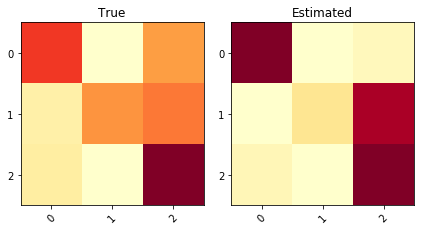

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


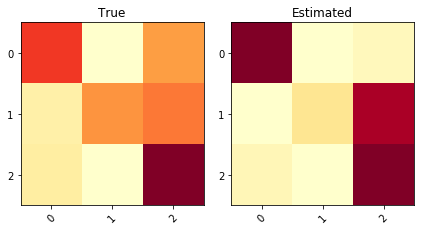

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


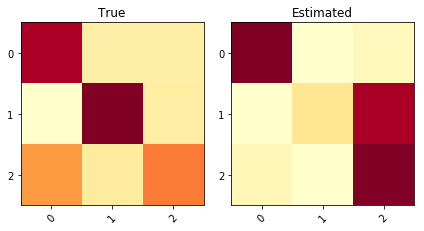

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


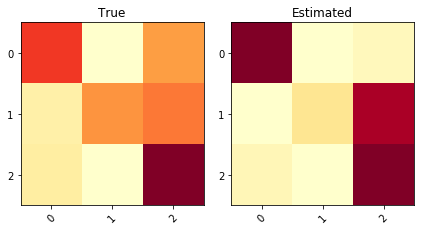

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


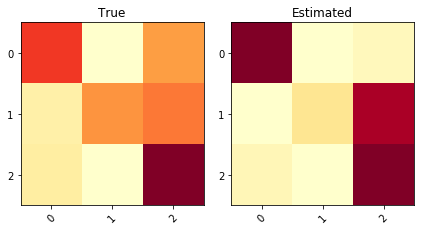

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


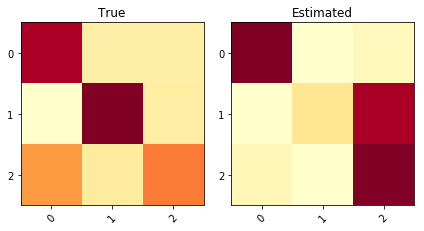

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


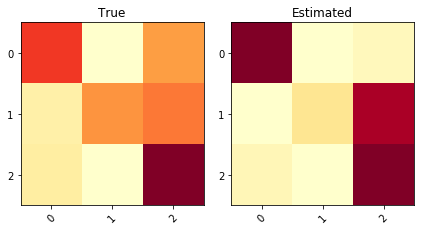

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


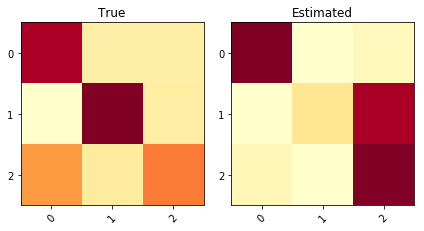

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


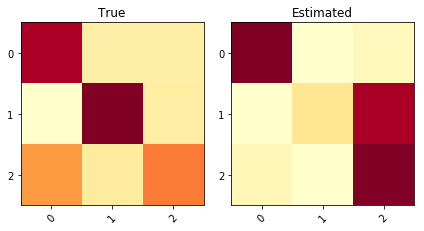

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6583


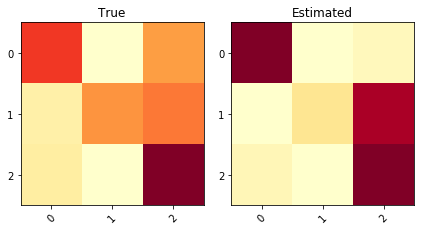

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


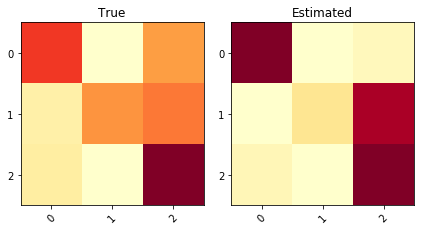

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


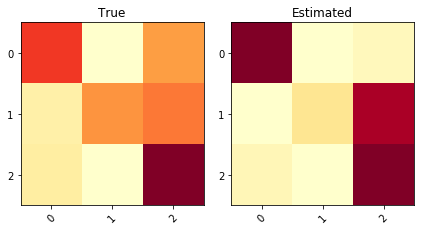

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


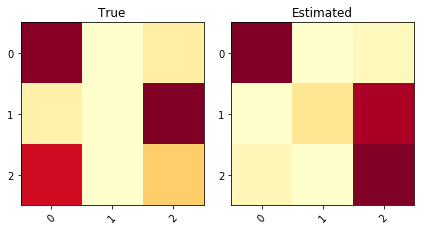

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7222


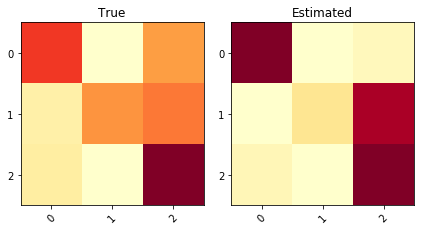

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963


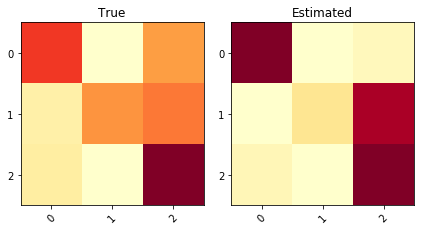

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7963
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.679691 |     0.679691 |     0.515368 |              0.426389 |
+----+--------+------------+--------------+--------------+-----------------------+


In [36]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


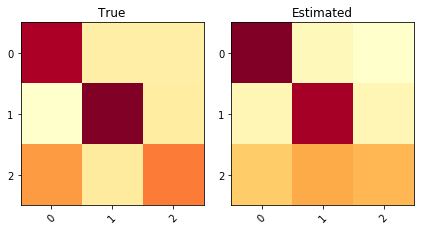

KL divergence: 0.1138	Pearson Correlation between diagonals: 0.9525


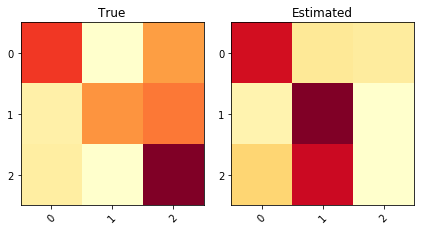

KL divergence: 3.5269	Pearson Correlation between diagonals: -0.9784


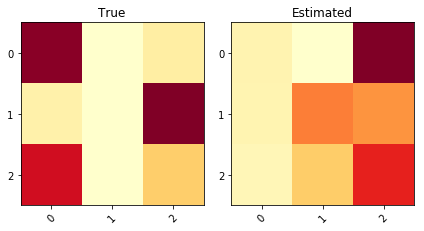

KL divergence: 1.2068	Pearson Correlation between diagonals: -0.8268


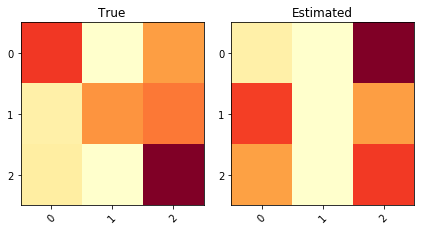

KL divergence: 2.4661	Pearson Correlation between diagonals: 0.9684


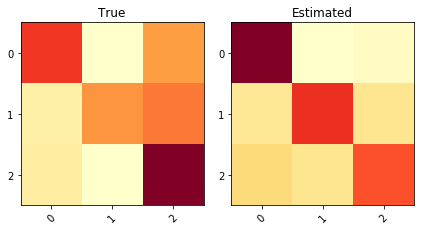

KL divergence: 0.4170	Pearson Correlation between diagonals: -0.3194


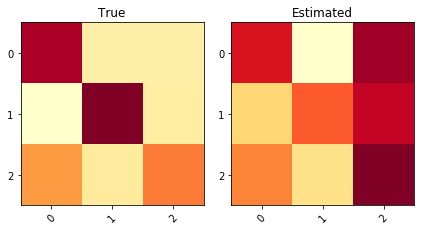

KL divergence: 0.4375	Pearson Correlation between diagonals: -0.9620


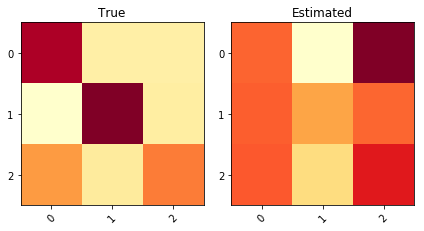

KL divergence: 0.5541	Pearson Correlation between diagonals: -0.9500


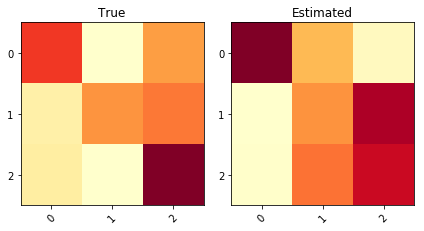

KL divergence: 0.6789	Pearson Correlation between diagonals: 0.5576


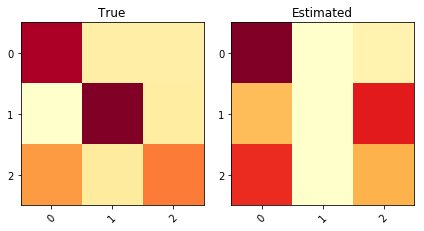

KL divergence: 5.6682	Pearson Correlation between diagonals: -0.0502


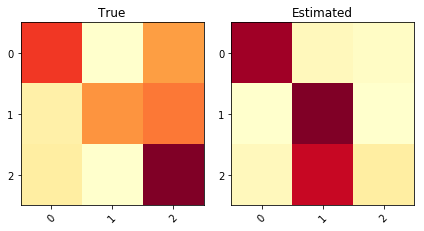

KL divergence: 1.3413	Pearson Correlation between diagonals: -0.9468


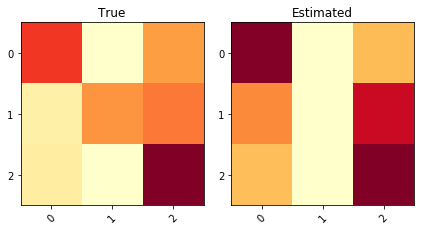

KL divergence: 2.1102	Pearson Correlation between diagonals: 0.8002


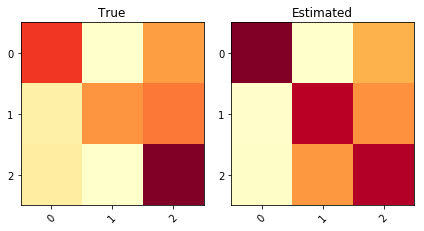

KL divergence: 0.1932	Pearson Correlation between diagonals: -0.0107


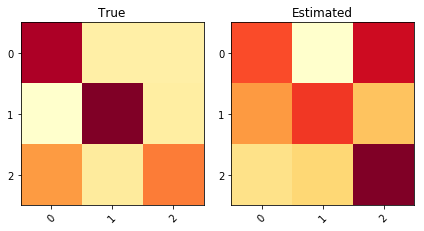

KL divergence: 0.4294	Pearson Correlation between diagonals: -0.9526


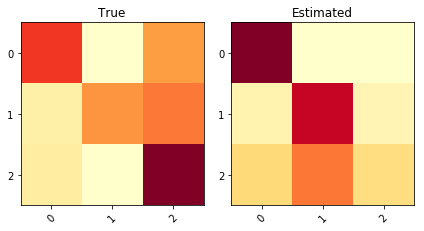

KL divergence: 0.7276	Pearson Correlation between diagonals: -0.8346


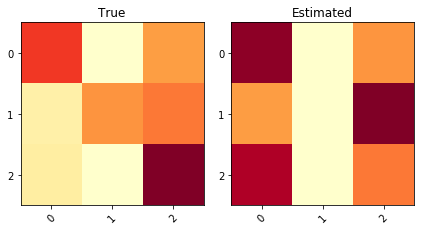

KL divergence: 2.2610	Pearson Correlation between diagonals: 0.4476
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.707367 |     0.707367 |      1.46083 |              0.151015 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.709402 |     0.709402 |
+----+--------+------------+--------------+


In [37]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


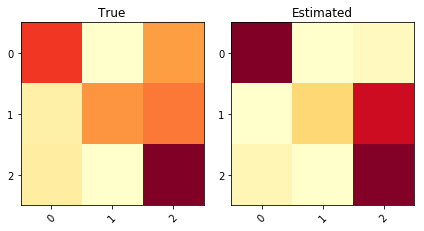

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


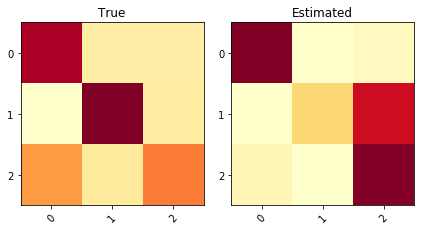

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


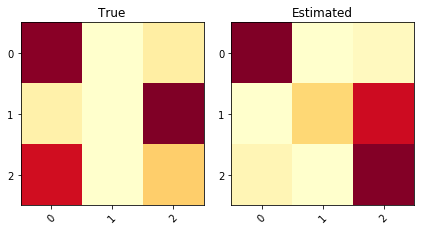

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7314


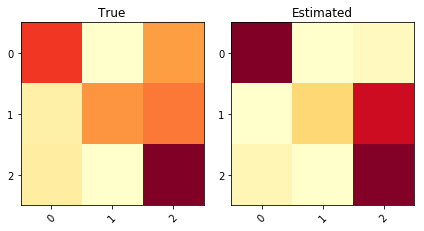

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


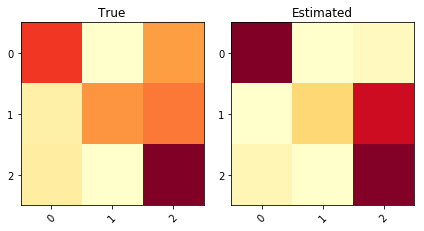

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


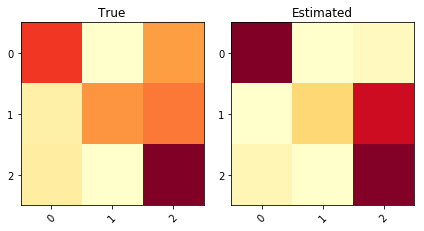

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


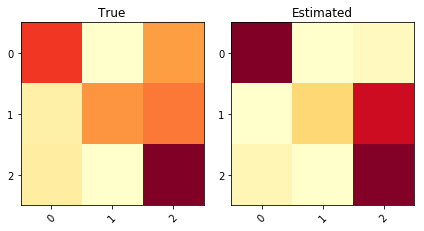

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


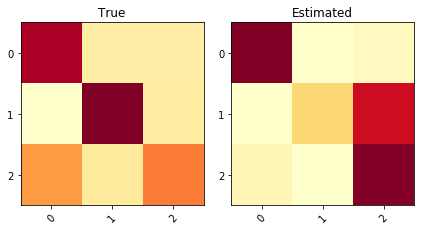

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


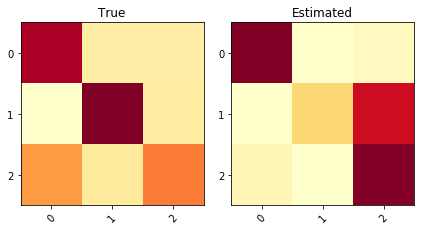

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


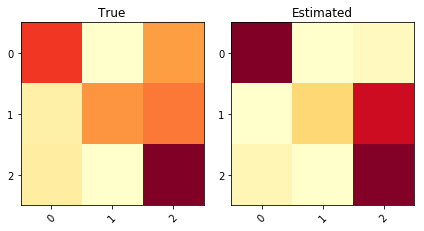

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


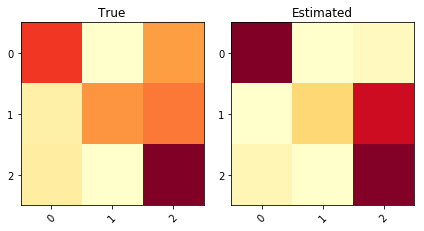

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


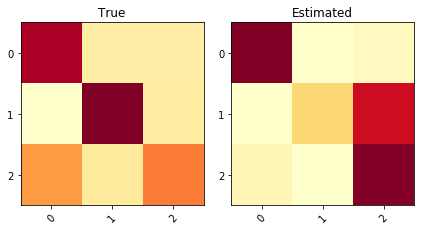

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


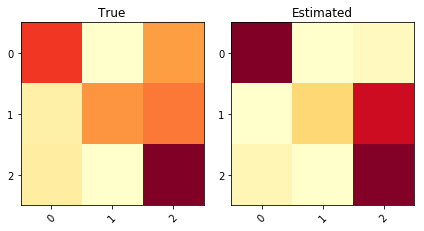

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882


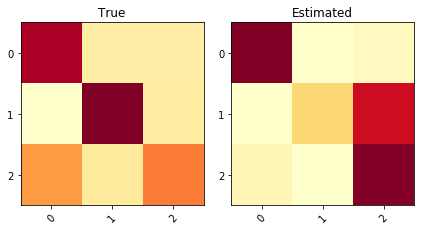

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6482


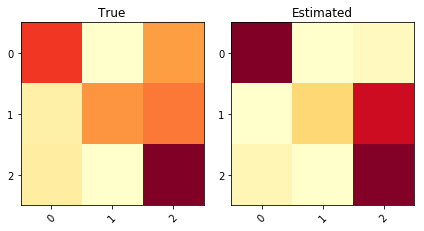

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.7882
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.707367 |     0.707367 |     0.515368 |               0.42614 |
+----+--------+------------+--------------+--------------+-----------------------+


In [38]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


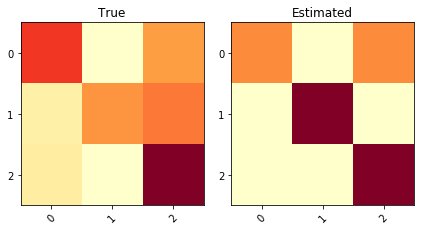

KL divergence: 3.2449	Pearson Correlation between diagonals: 0.1270


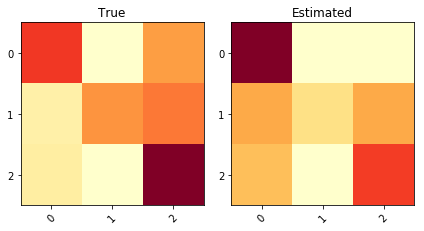

KL divergence: 2.0270	Pearson Correlation between diagonals: 0.4725


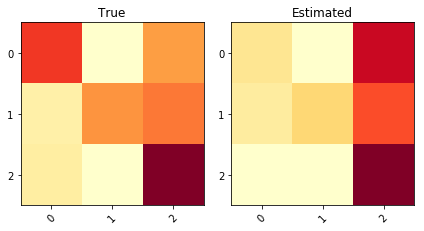

KL divergence: 0.6405	Pearson Correlation between diagonals: 0.8837


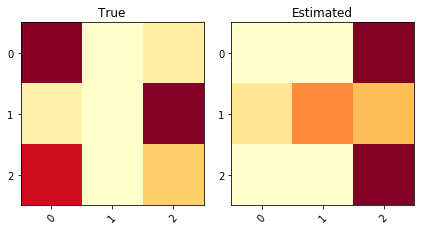

KL divergence: 8.7754	Pearson Correlation between diagonals: -0.6907


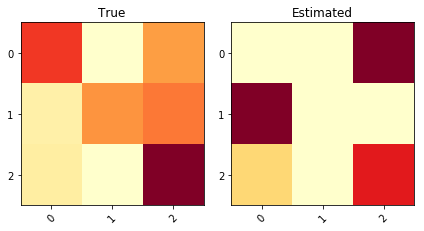

KL divergence: 7.6323	Pearson Correlation between diagonals: 0.9225


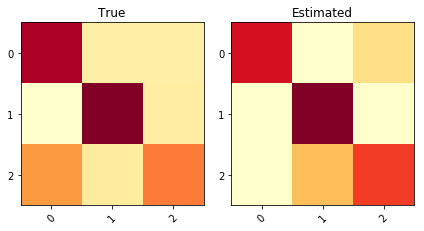

KL divergence: 2.8187	Pearson Correlation between diagonals: 0.9026


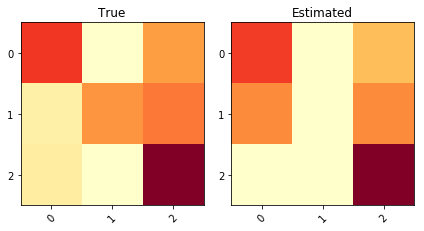

KL divergence: 2.5557	Pearson Correlation between diagonals: 0.9500


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


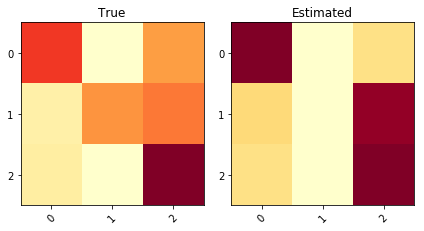

KL divergence: 2.1050	Pearson Correlation between diagonals: 0.7955


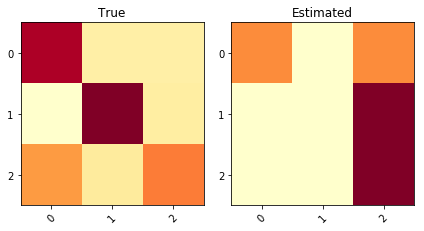

KL divergence: 7.7009	Pearson Correlation between diagonals: -0.9461


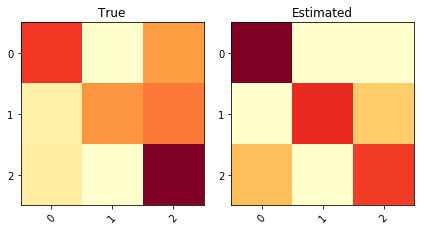

KL divergence: 2.3639	Pearson Correlation between diagonals: -0.2569


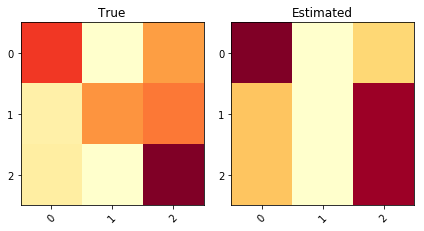

KL divergence: 2.1102	Pearson Correlation between diagonals: 0.7605


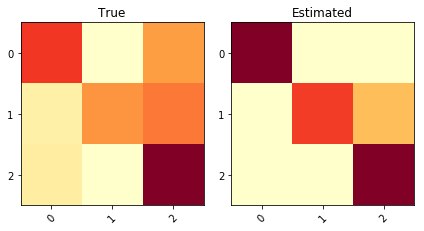

KL divergence: 2.7548	Pearson Correlation between diagonals: 0.7955


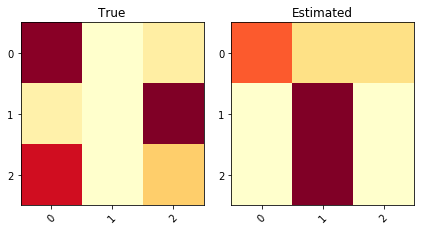

KL divergence: 10.5537	Pearson Correlation between diagonals: -0.1690


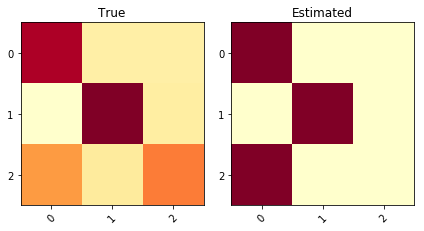

KL divergence: 4.1528	Pearson Correlation between diagonals: 0.9813


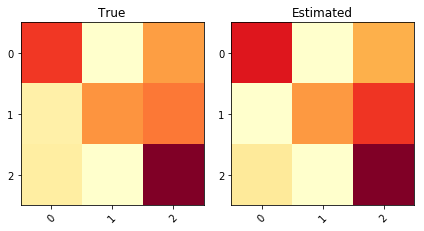

KL divergence: 0.3944	Pearson Correlation between diagonals: 0.9805
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.929996 |     0.929996 |      3.40725 |                   nan |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.945055 |     0.945055 |
+----+--------+------------+--------------+


In [39]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


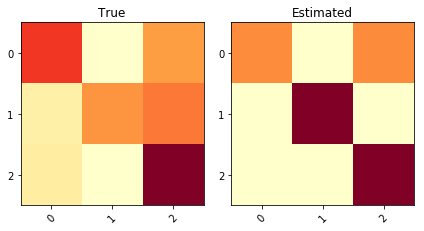

KL divergence: 0.2489	Pearson Correlation between diagonals: 0.1270


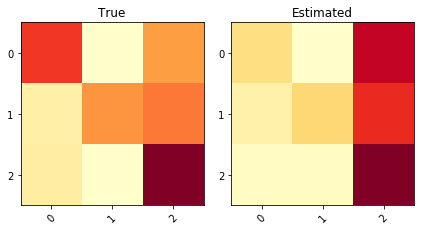

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.9049


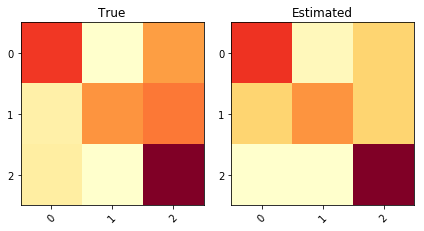

KL divergence: 0.1430	Pearson Correlation between diagonals: 0.9997


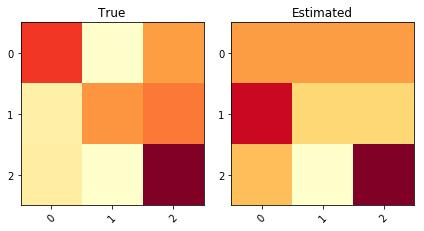

KL divergence: 0.3715	Pearson Correlation between diagonals: 0.9897


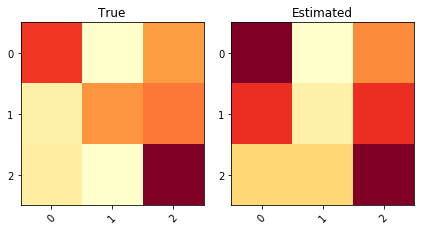

KL divergence: 0.2963	Pearson Correlation between diagonals: 0.7955


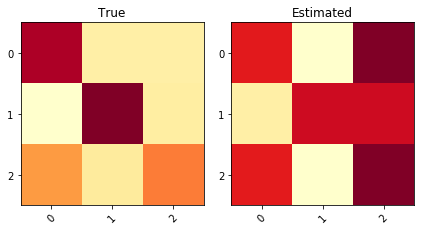

KL divergence: 0.3069	Pearson Correlation between diagonals: -0.8919


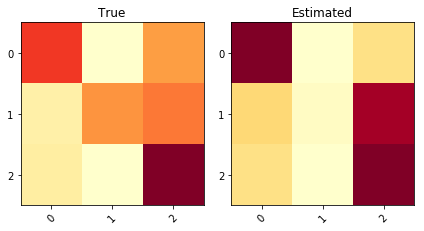

KL divergence: 0.2181	Pearson Correlation between diagonals: 0.7954


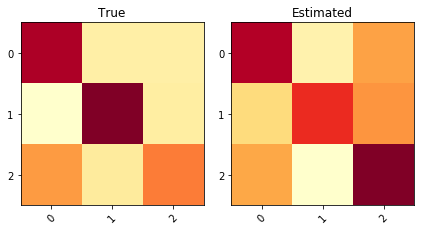

KL divergence: 0.2375	Pearson Correlation between diagonals: -0.8901


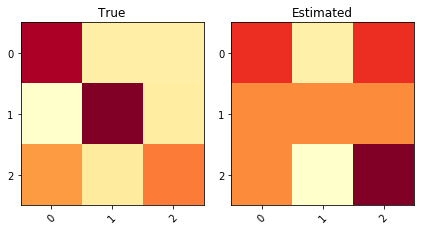

KL divergence: 0.3800	Pearson Correlation between diagonals: -0.9771


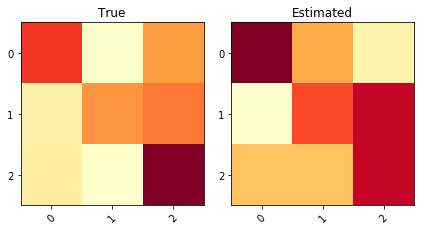

KL divergence: 0.2884	Pearson Correlation between diagonals: 0.4725


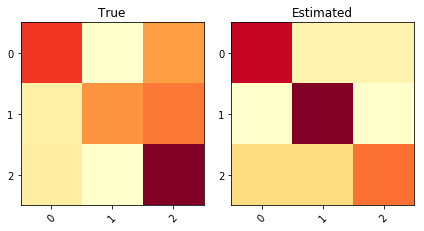

KL divergence: 0.4346	Pearson Correlation between diagonals: -0.9993


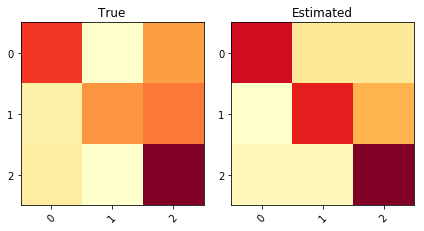

KL divergence: 0.1636	Pearson Correlation between diagonals: 0.9926


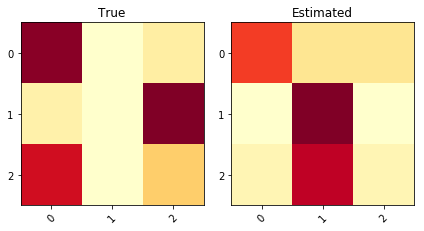

KL divergence: 0.9886	Pearson Correlation between diagonals: -0.1210


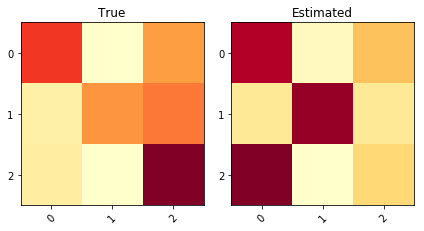

KL divergence: 0.4422	Pearson Correlation between diagonals: -0.9486


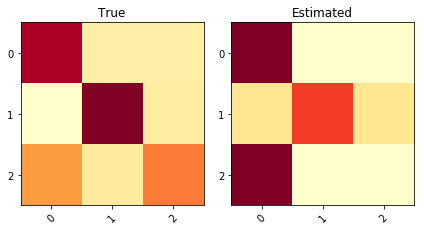

KL divergence: 0.2459	Pearson Correlation between diagonals: 0.8643
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.927961 |     0.927961 |     0.377019 |              0.135643 |       0.234728 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                 0.49585 |                1.01583 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+----

In [40]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


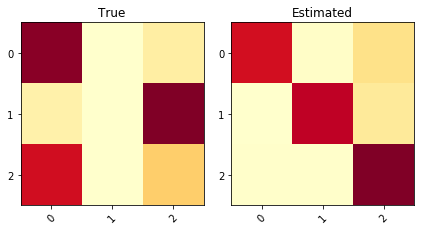

KL divergence: 1.7701	Pearson Correlation between diagonals: -0.5259


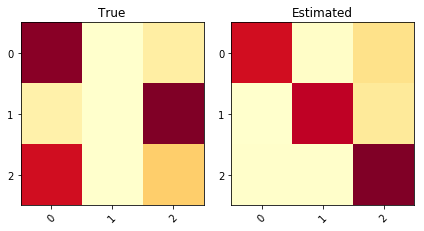

KL divergence: 1.7573	Pearson Correlation between diagonals: -0.5109


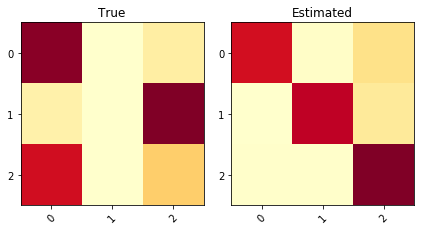

KL divergence: 1.7714	Pearson Correlation between diagonals: -0.5274


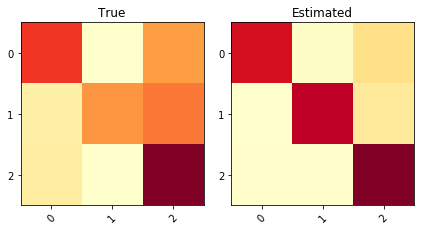

KL divergence: 0.3294	Pearson Correlation between diagonals: 0.7464


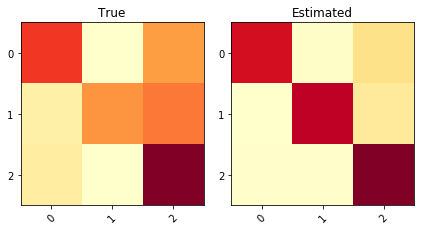

KL divergence: 0.3291	Pearson Correlation between diagonals: 0.7555


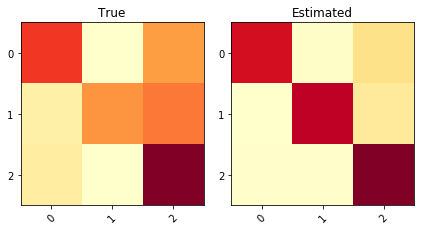

KL divergence: 0.3290	Pearson Correlation between diagonals: 0.7591


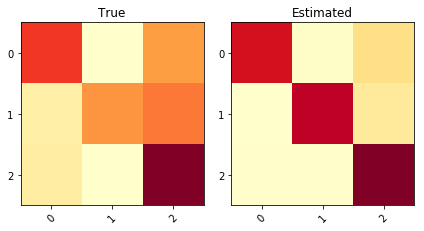

KL divergence: 0.3288	Pearson Correlation between diagonals: 0.7459


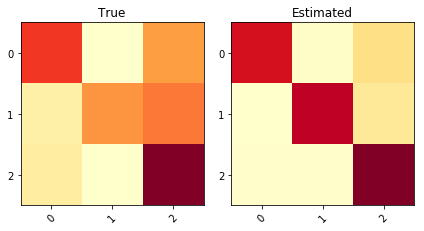

KL divergence: 0.3286	Pearson Correlation between diagonals: 0.7434


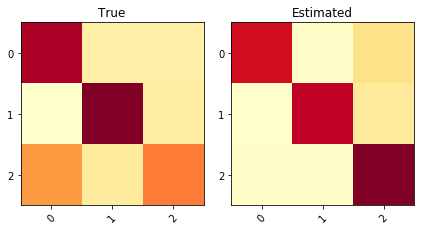

KL divergence: 0.6118	Pearson Correlation between diagonals: -0.8769


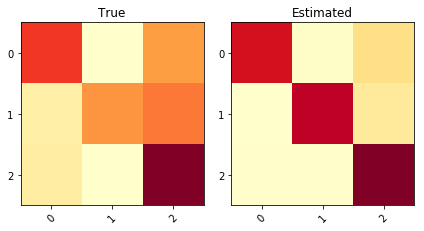

KL divergence: 0.3296	Pearson Correlation between diagonals: 0.7441


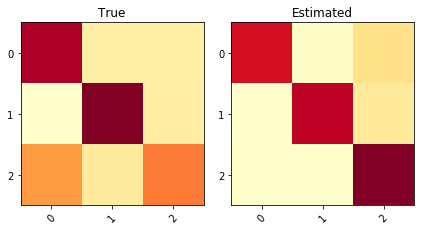

KL divergence: 0.6163	Pearson Correlation between diagonals: -0.8726


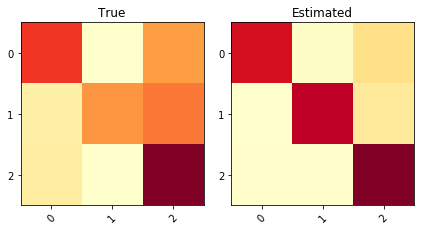

KL divergence: 0.3285	Pearson Correlation between diagonals: 0.7516


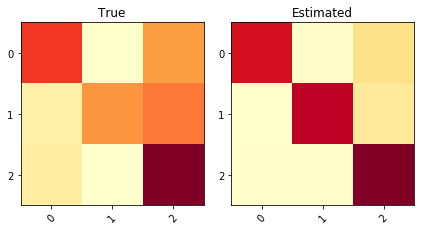

KL divergence: 0.3282	Pearson Correlation between diagonals: 0.7544


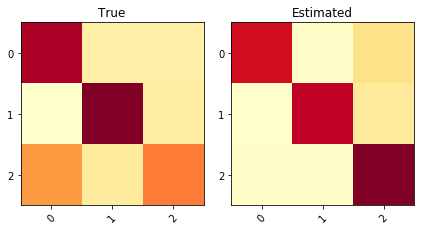

KL divergence: 0.6077	Pearson Correlation between diagonals: -0.8808


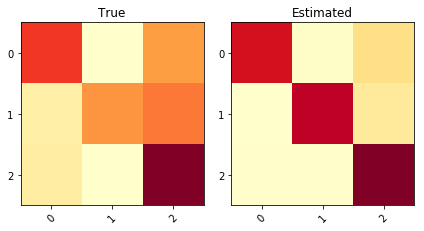

KL divergence: 0.3298	Pearson Correlation between diagonals: 0.7428
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.879121      0.879121      0.684328              0.0714332        0.186488
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.60342                0.802492
====  =======================  ======================
Test


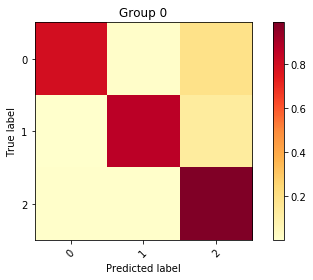

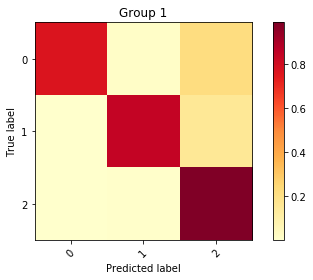

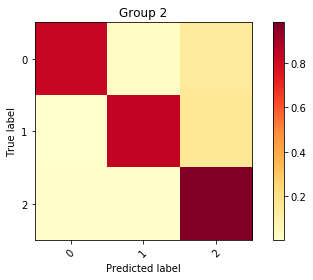

Inertia: 0.0012672375693606834
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.437364    2186   0.339188     0.884192   0.127093            0.938167    0.692308      0.692308
   1         1  0.377181    1885   0.366402     0.867399   0.147747            0.928456    0.672772      0.672772
   2         2  0.185455     927   0.359906     0.885049   0.125066            0.938987    0.675214      0.675214
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.875458      0.87

In [18]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


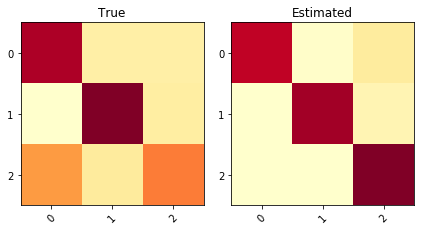

KL divergence: 0.8850	Pearson Correlation between diagonals: -0.7603


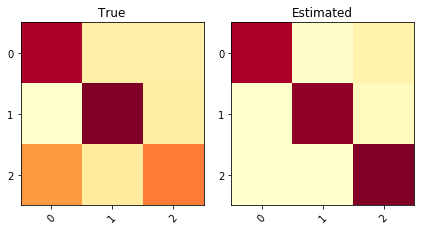

KL divergence: 0.9312	Pearson Correlation between diagonals: -0.6810


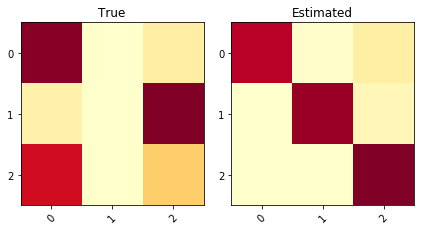

KL divergence: 2.4449	Pearson Correlation between diagonals: -0.7041


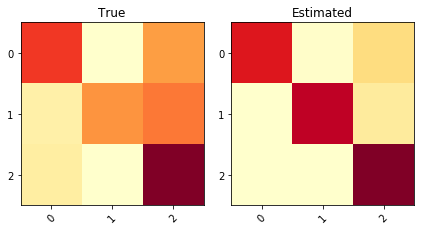

KL divergence: 0.3875	Pearson Correlation between diagonals: 0.6748


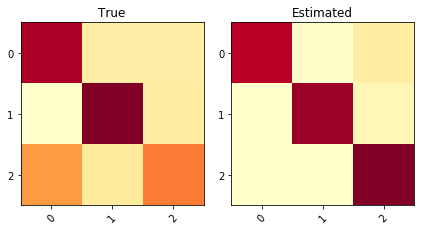

KL divergence: 0.8992	Pearson Correlation between diagonals: -0.7388


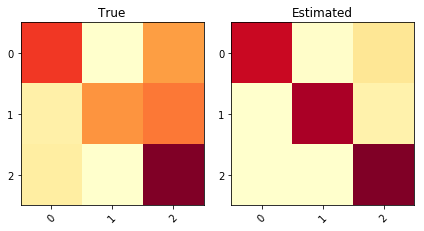

KL divergence: 0.4797	Pearson Correlation between diagonals: 0.6394


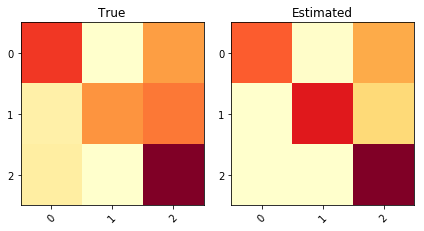

KL divergence: 0.2881	Pearson Correlation between diagonals: 0.6956


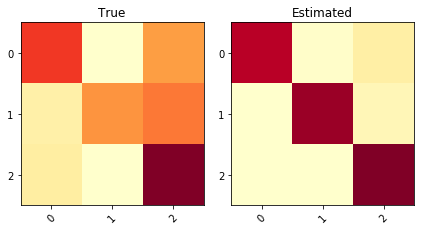

KL divergence: 0.5828	Pearson Correlation between diagonals: 0.5884


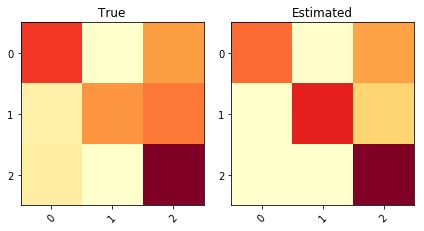

KL divergence: 0.2825	Pearson Correlation between diagonals: 0.6963


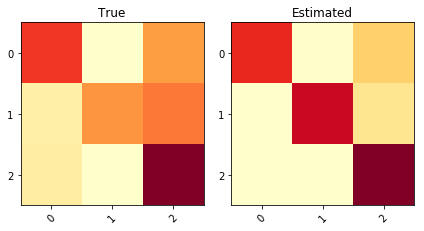

KL divergence: 0.3440	Pearson Correlation between diagonals: 0.6844


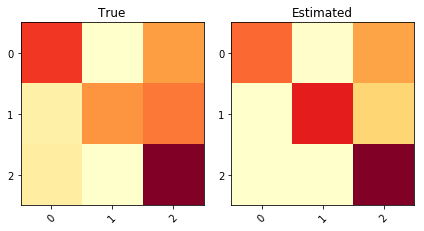

KL divergence: 0.2818	Pearson Correlation between diagonals: 0.6973


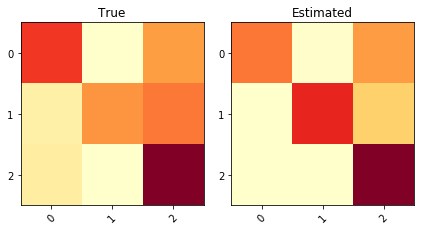

KL divergence: 0.2804	Pearson Correlation between diagonals: 0.6962


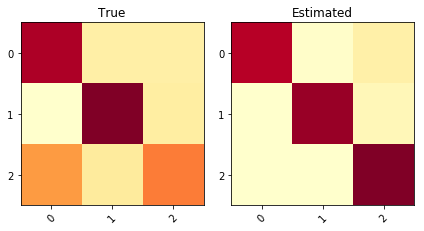

KL divergence: 0.8957	Pearson Correlation between diagonals: -0.7328


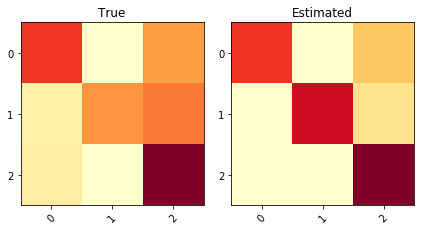

KL divergence: 0.3252	Pearson Correlation between diagonals: 0.6888


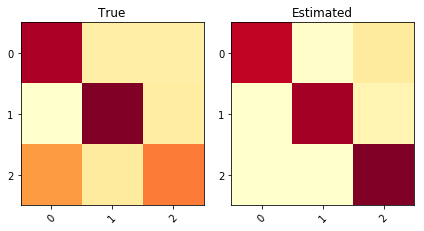

KL divergence: 0.8753	Pearson Correlation between diagonals: -0.7694
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.862027      0.862027      0.872728              0.0399778        0.156492
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.635078                0.758449
====  =======================  ======================
Test


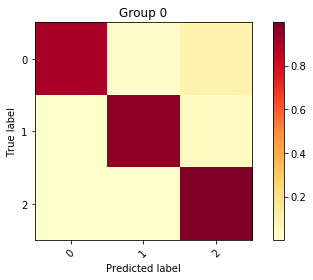

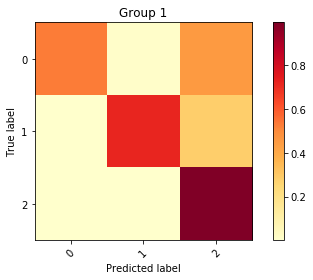

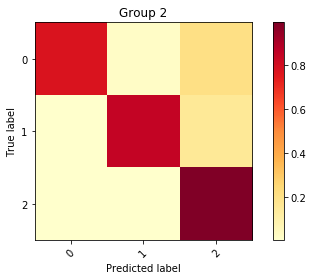

Inertia: 0.028337412513792515
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.47453     2372   0.163561     0.958927  0.0426241            0.978913    0.838828      0.838828
   1         1  0.344939    1724   0.45588      0.749184  0.321268             0.851638    0.547009      0.547009
   2         2  0.18053      902   0.359051     0.872339  0.141973             0.931209    0.667888      0.667888
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.864469      0.864

In [19]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


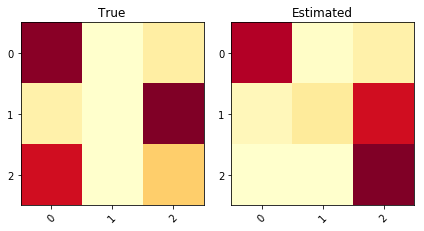

KL divergence: 1.1646	Pearson Correlation between diagonals: 0.6409


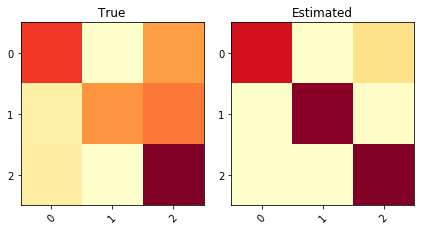

KL divergence: 0.5588	Pearson Correlation between diagonals: 0.2219


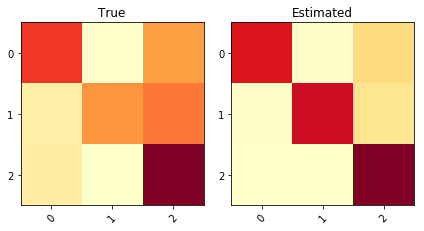

KL divergence: 0.2321	Pearson Correlation between diagonals: 0.8269


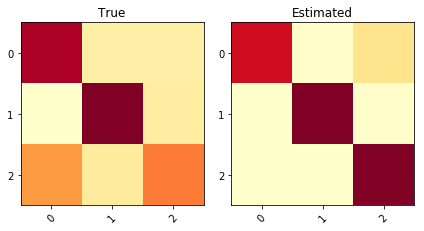

KL divergence: 0.6882	Pearson Correlation between diagonals: -0.3570


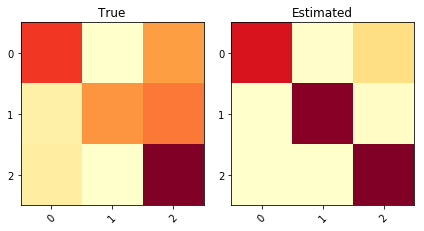

KL divergence: 0.5495	Pearson Correlation between diagonals: 0.2172


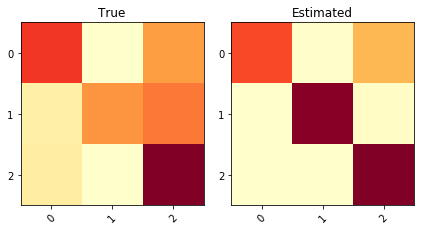

KL divergence: 0.5395	Pearson Correlation between diagonals: 0.1762


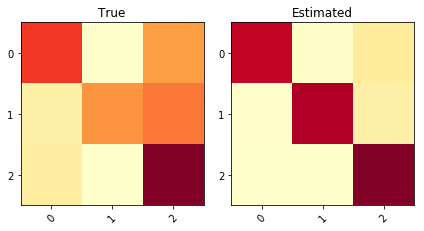

KL divergence: 0.3491	Pearson Correlation between diagonals: 0.7822


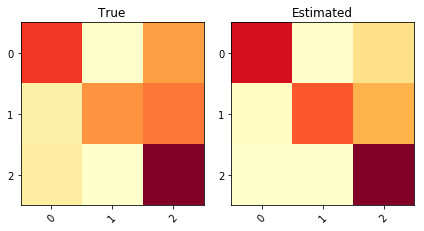

KL divergence: 0.1414	Pearson Correlation between diagonals: 0.9945


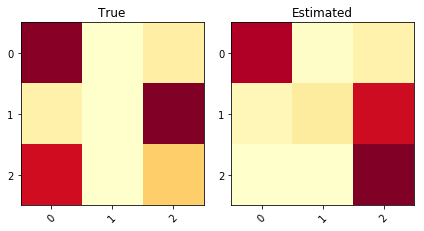

KL divergence: 1.1604	Pearson Correlation between diagonals: 0.6452


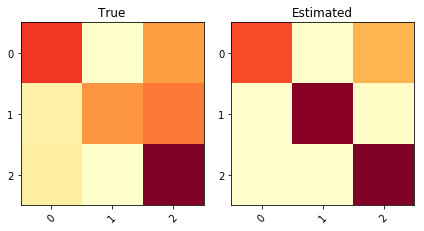

KL divergence: 0.5202	Pearson Correlation between diagonals: 0.1825


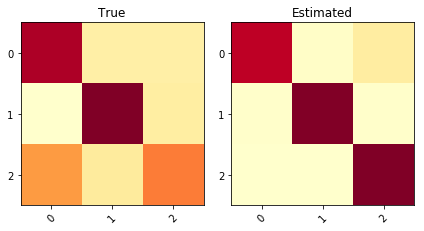

KL divergence: 0.6899	Pearson Correlation between diagonals: -0.3545


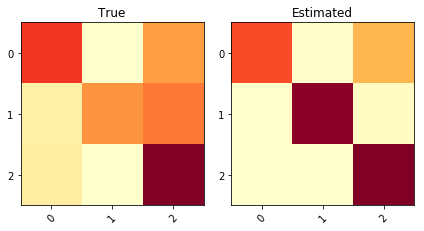

KL divergence: 0.5021	Pearson Correlation between diagonals: 0.1916


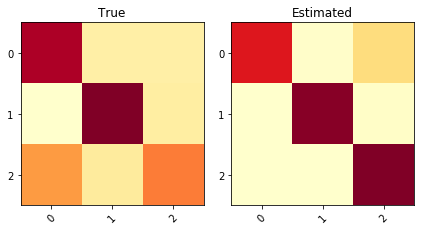

KL divergence: 0.6836	Pearson Correlation between diagonals: -0.3802


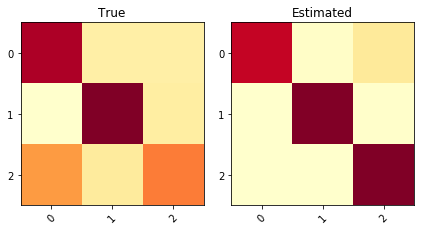

KL divergence: 0.6904	Pearson Correlation between diagonals: -0.3516


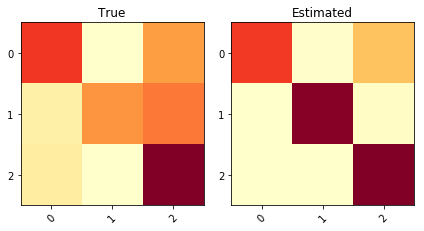

KL divergence: 0.5484	Pearson Correlation between diagonals: 0.1784
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.900692      0.900692      0.618431               0.277073        0.130664
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.686919                0.708123
====  =======================  ======================
Test


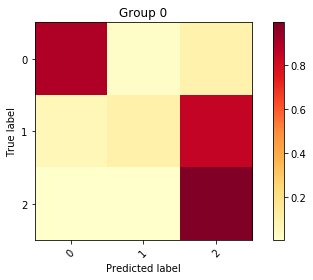

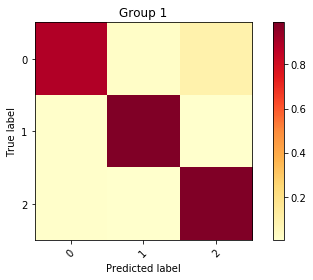

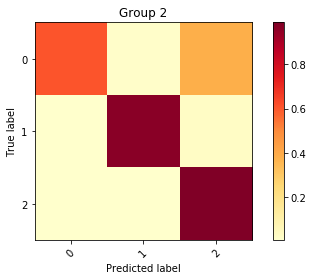

Inertia: 0.1217692531645298
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.272794    1363   0.322061     0.661478   0.814433            0.726401    0.64591       0.64591
   1         1  0.329308    1646   0.172086     0.956637   0.045573            0.977538    0.91453       0.91453
   2         2  0.397897    1989   0.314001     0.854963   0.180985            0.915633    0.892552      0.892552
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.904762      0.904762


In [20]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v3 ($T$ = 10000, $T_{data}$ = 40 )

In [23]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8237688237688238


*** Soft-Majority (Train with softMV) ***
Train


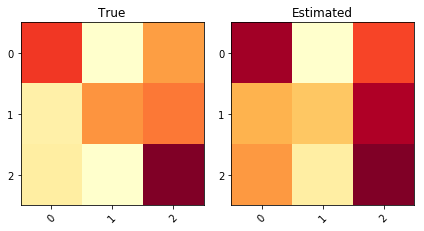

KL divergence: 0.1322	Pearson Correlation between diagonals: 0.8498


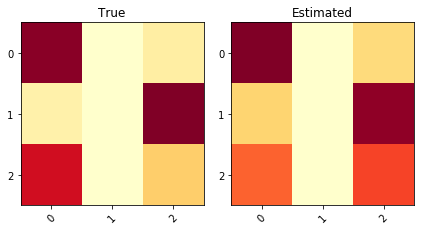

KL divergence: 0.0785	Pearson Correlation between diagonals: 0.9168


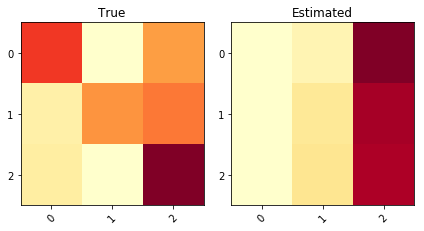

KL divergence: 4.0325	Pearson Correlation between diagonals: 0.8508


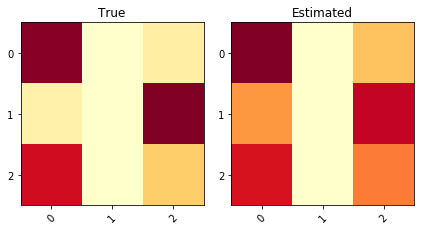

KL divergence: 0.1000	Pearson Correlation between diagonals: 0.9619


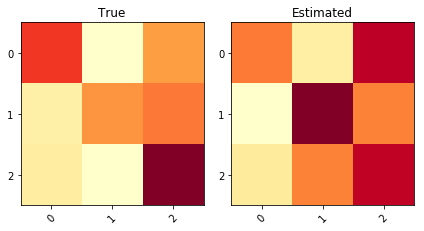

KL divergence: 0.2451	Pearson Correlation between diagonals: -0.1697


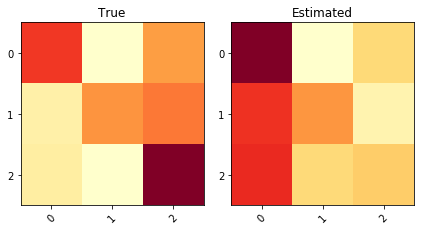

KL divergence: 0.5866	Pearson Correlation between diagonals: -0.3625


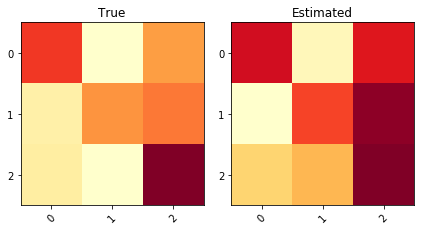

KL divergence: 0.1487	Pearson Correlation between diagonals: 0.9980


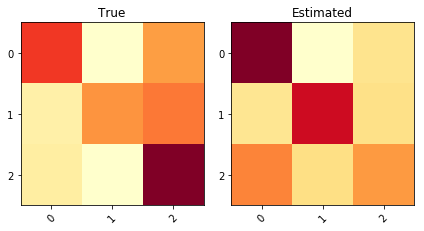

KL divergence: 0.3343	Pearson Correlation between diagonals: -0.7455


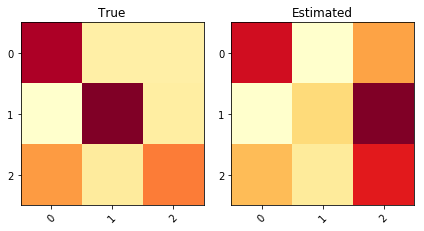

KL divergence: 0.4221	Pearson Correlation between diagonals: -0.5868


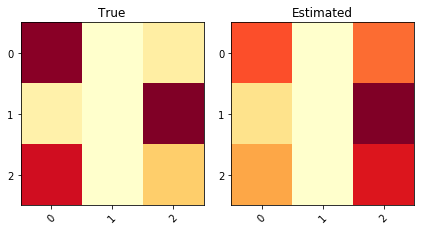

KL divergence: 0.2208	Pearson Correlation between diagonals: 0.5836


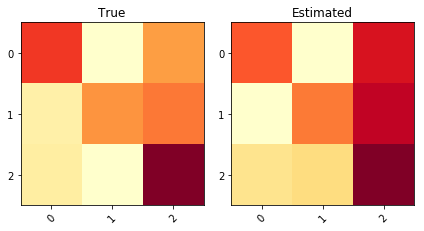

KL divergence: 0.1178	Pearson Correlation between diagonals: 0.9670


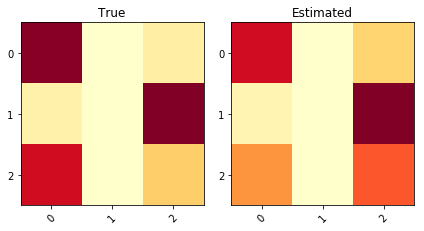

KL divergence: 0.0845	Pearson Correlation between diagonals: 0.8711


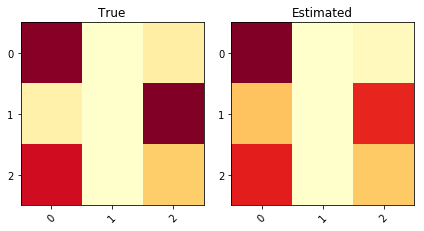

KL divergence: 0.0604	Pearson Correlation between diagonals: 0.9999


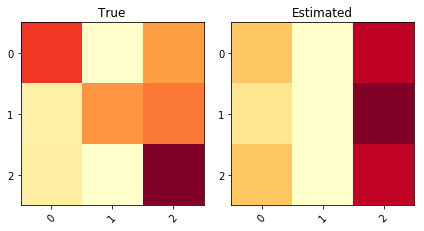

KL divergence: 2.1647	Pearson Correlation between diagonals: 0.9993


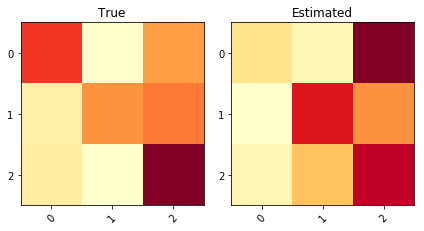

KL divergence: 0.3445	Pearson Correlation between diagonals: 0.2558
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.641433 |     0.641433 |     0.807789 |              0.647566 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.661783 |     0.661783 |
+----+--------+------------+--------------+


In [24]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
Z_train_p = model_mvsoft.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***


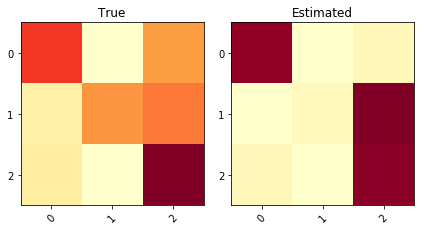

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


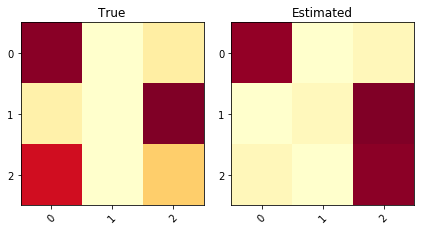

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7125


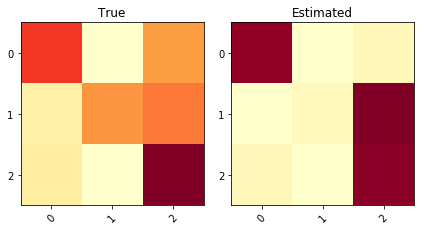

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


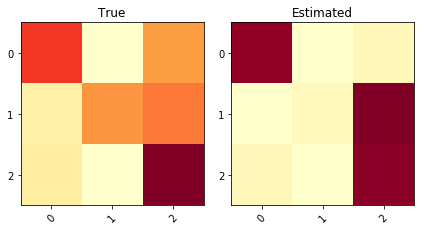

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


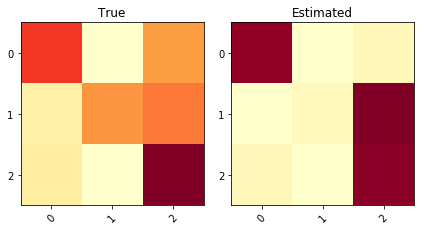

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


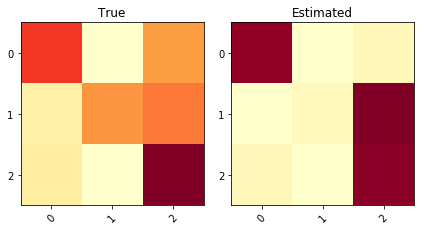

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


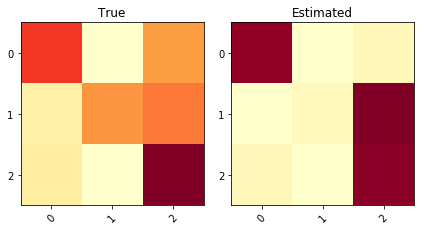

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


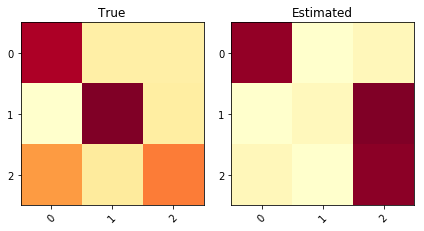

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688


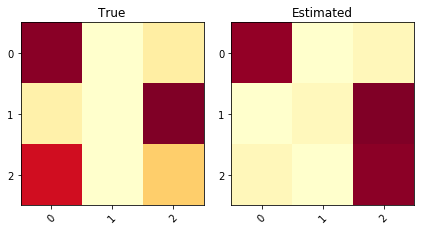

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7125


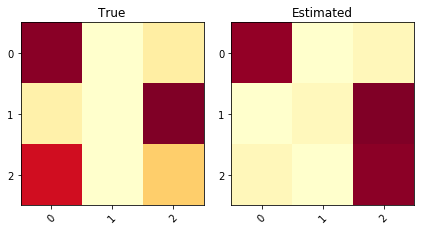

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7125


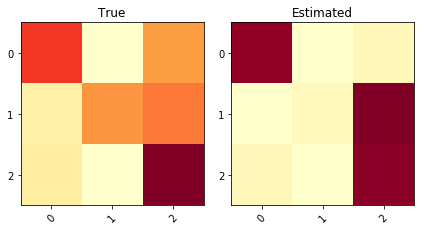

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


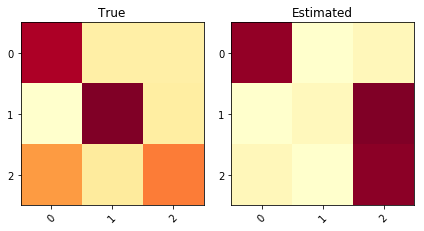

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688


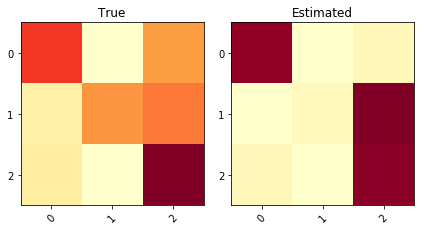

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8047


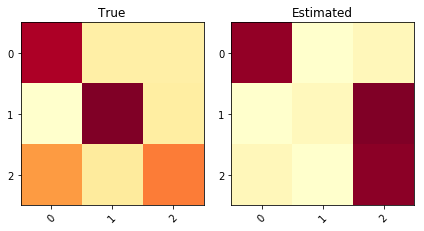

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688


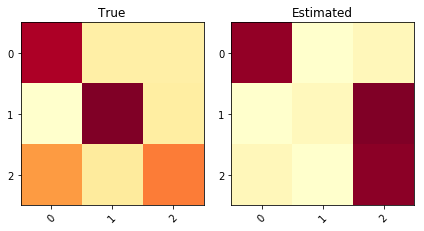

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6688
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.641433 |     0.641433 |     0.521171 |               0.41802 |
+----+--------+------------+--------------+--------------+-----------------------+


In [25]:
print("*** Soft-Majority (Train with softMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Hard-Majority (Train with hardMV) ***
Train


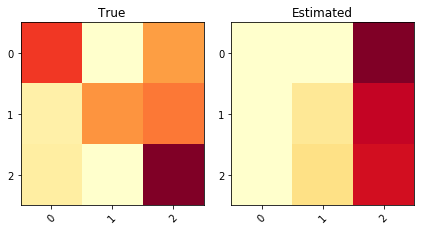

KL divergence: 4.0302	Pearson Correlation between diagonals: 0.8379


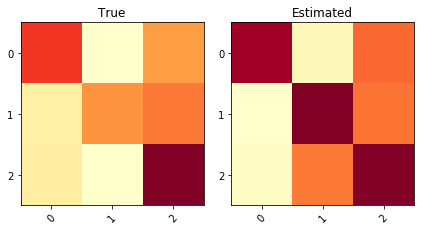

KL divergence: 0.2179	Pearson Correlation between diagonals: 0.0185


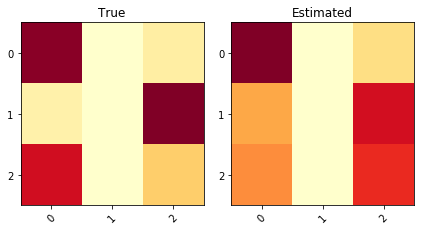

KL divergence: 0.1391	Pearson Correlation between diagonals: 0.8878


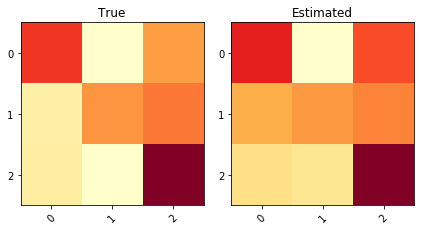

KL divergence: 0.0969	Pearson Correlation between diagonals: 0.9903


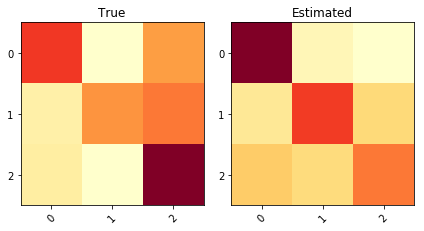

KL divergence: 0.5760	Pearson Correlation between diagonals: -0.3901


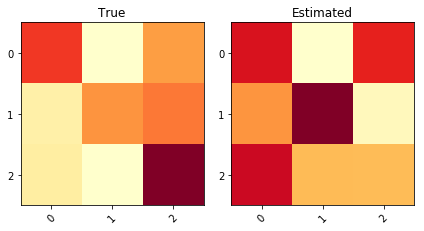

KL divergence: 0.6747	Pearson Correlation between diagonals: -0.9979


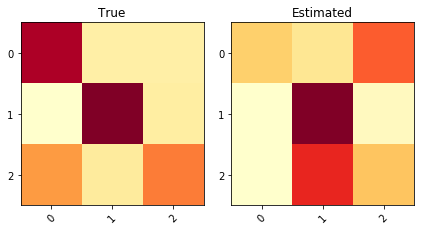

KL divergence: 0.9145	Pearson Correlation between diagonals: 0.6235


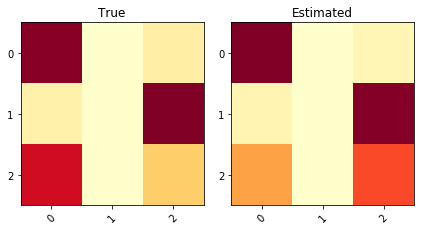

KL divergence: 0.0839	Pearson Correlation between diagonals: 0.9241


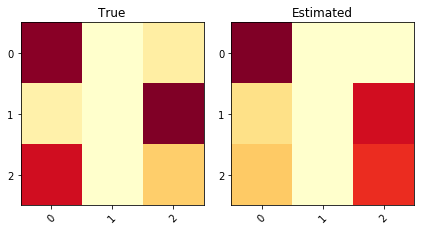

KL divergence: 0.2866	Pearson Correlation between diagonals: 0.8916


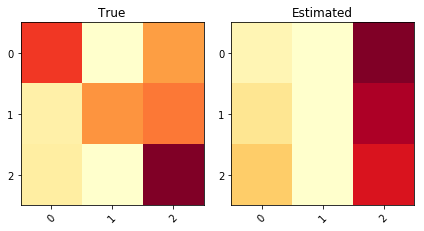

KL divergence: 2.4218	Pearson Correlation between diagonals: 0.9499


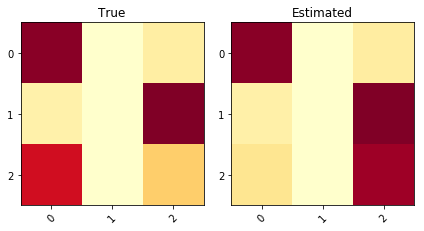

KL divergence: 0.2889	Pearson Correlation between diagonals: 0.7500


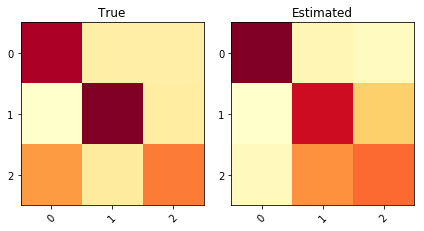

KL divergence: 0.2270	Pearson Correlation between diagonals: 0.8107


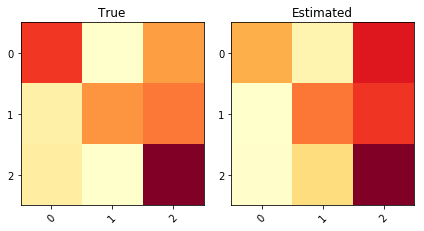

KL divergence: 0.2520	Pearson Correlation between diagonals: 0.7978


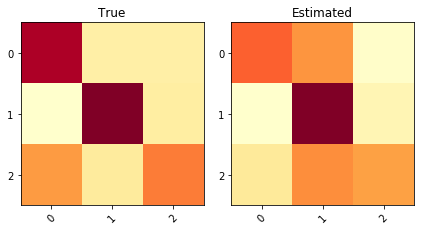

KL divergence: 0.2244	Pearson Correlation between diagonals: 0.8318


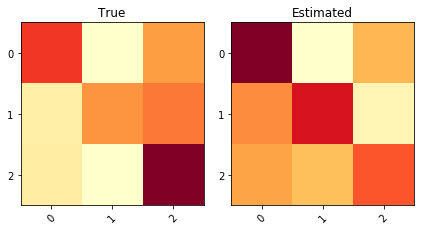

KL divergence: 0.4106	Pearson Correlation between diagonals: -0.5623
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.660155 |     0.660155 |     0.868676 |              0.650343 |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.684982 |     0.684982 |
+----+--------+------------+--------------+


In [26]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
Z_train_p = model_mvhard.predict(Xstd_train)
prob_Yzt = get_confusionM(Z_train_p,y_obs_categorical)
Z_train_pred = Z_train_p.argmax(axis=1)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_mvhard.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***


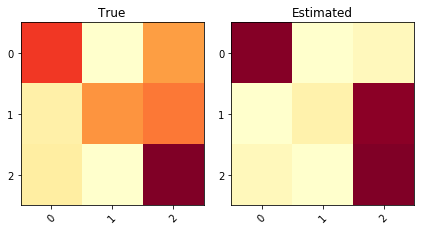

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


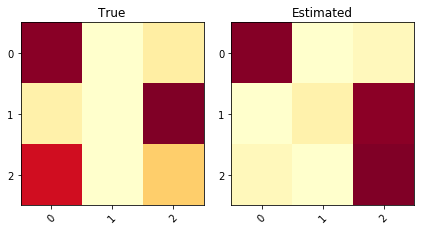

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


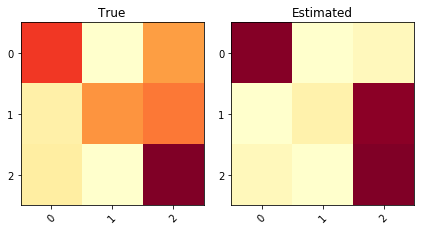

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


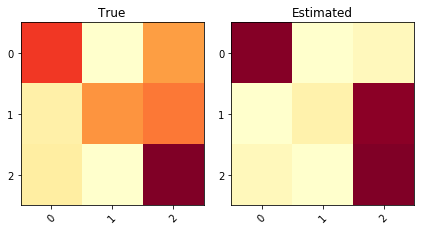

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


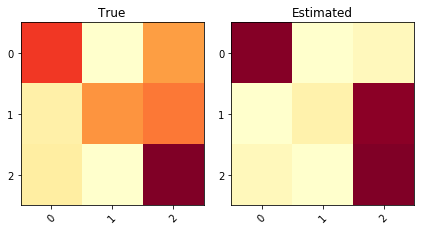

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


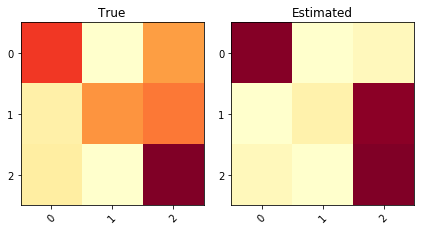

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


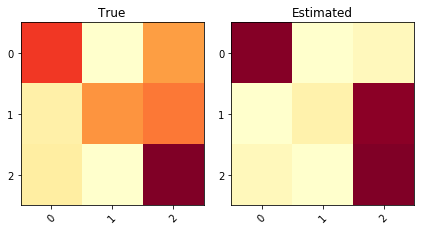

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


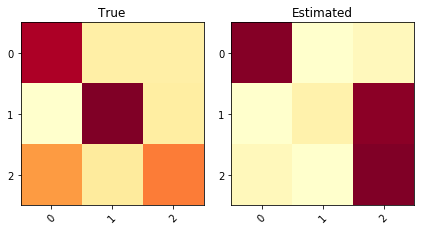

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6665


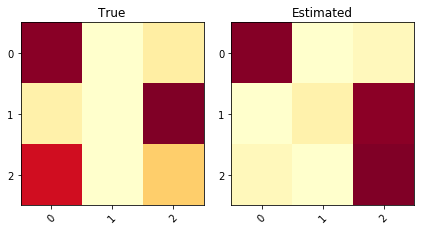

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


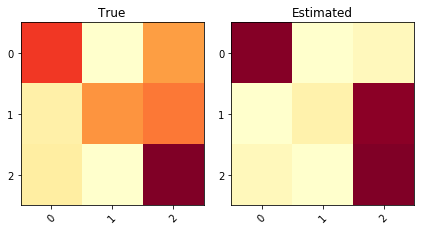

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


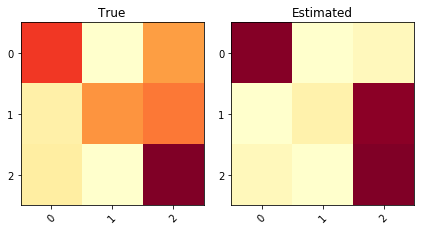

KL divergence: 0.1817	Pearson Correlation between diagonals: 0.8029


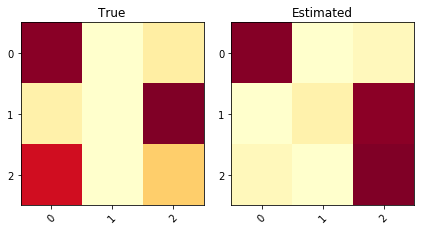

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


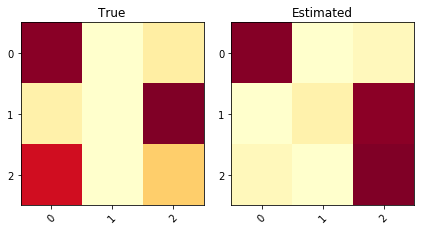

KL divergence: 0.4278	Pearson Correlation between diagonals: 0.7146


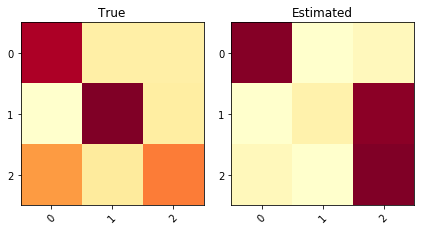

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6665


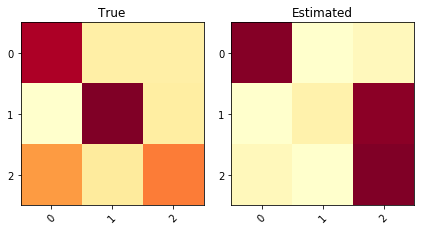

KL divergence: 1.3479	Pearson Correlation between diagonals: -0.6665
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.660155 |     0.660155 |     0.521171 |              0.417991 |
+----+--------+------------+--------------+--------------+-----------------------+


In [27]:
print("*** Hard-Majority (Train with hardMV) ***")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

*** Dawid and Skene model (Train with D&S) ***
Train


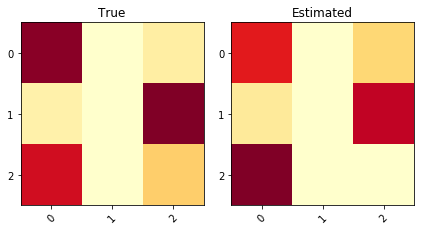

KL divergence: 1.2267	Pearson Correlation between diagonals: 0.9597


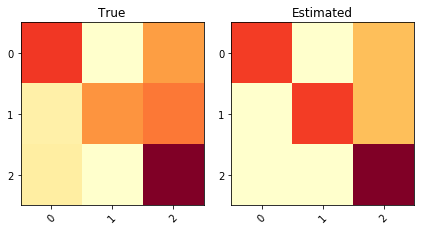

KL divergence: 0.8700	Pearson Correlation between diagonals: 0.9225


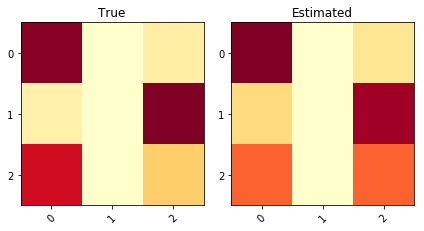

KL divergence: 0.0590	Pearson Correlation between diagonals: 0.9445


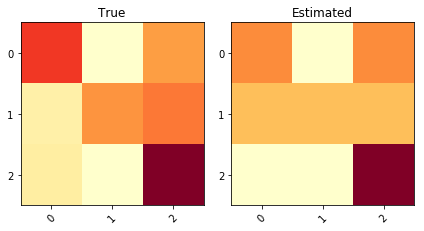

KL divergence: 0.5162	Pearson Correlation between diagonals: 0.9882


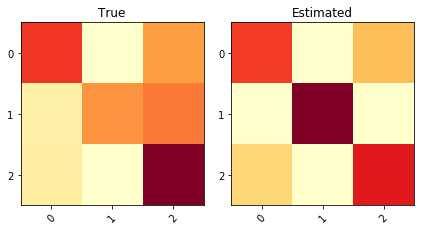

KL divergence: 2.8087	Pearson Correlation between diagonals: -0.6267


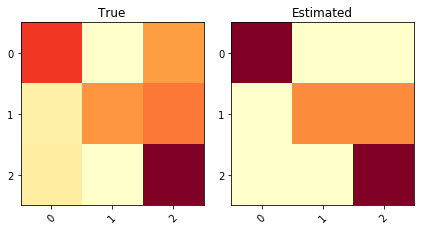

KL divergence: 2.7299	Pearson Correlation between diagonals: 0.7955


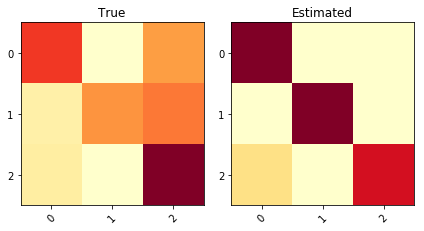

KL divergence: 4.6821	Pearson Correlation between diagonals: -0.9225


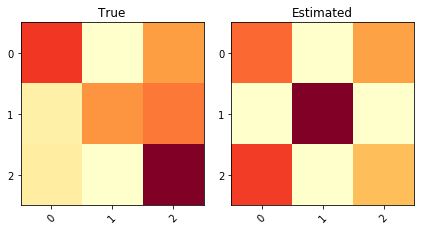

KL divergence: 3.0144	Pearson Correlation between diagonals: -0.9580


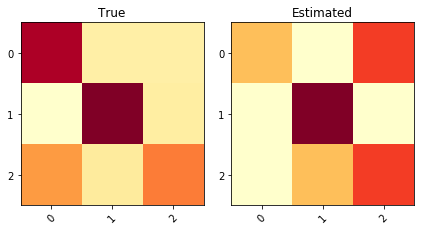

KL divergence: 3.0167	Pearson Correlation between diagonals: 0.1924


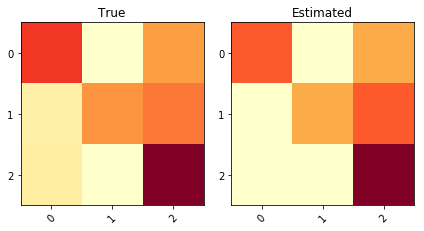

KL divergence: 0.8446	Pearson Correlation between diagonals: 0.9980


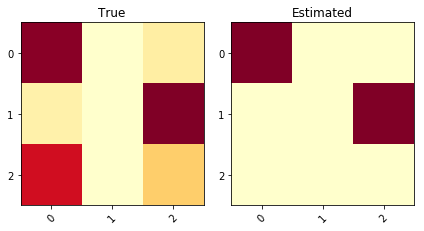

KL divergence: 0.9934	Pearson Correlation between diagonals: 0.9597


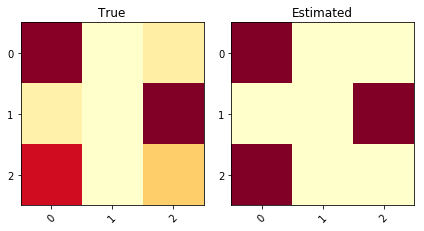

KL divergence: 2.0172	Pearson Correlation between diagonals: 0.9597


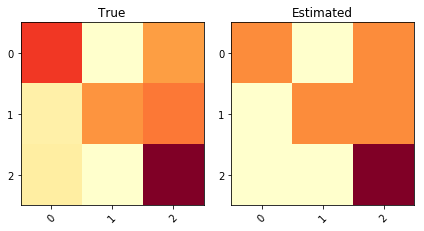

KL divergence: 0.8502	Pearson Correlation between diagonals: 0.9225


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


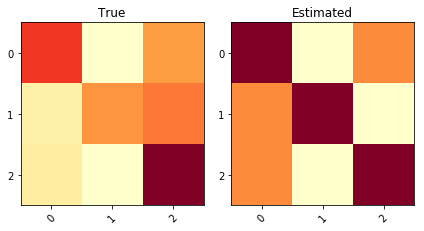

KL divergence: 2.4342	Pearson Correlation between diagonals: nan


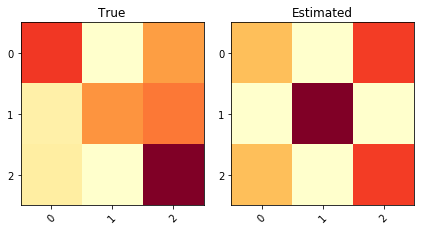

KL divergence: 2.8832	Pearson Correlation between diagonals: -0.3860
A result
 +----+--------+------------+--------------+--------------+-----------------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |
|----+--------+------------+--------------+--------------+-----------------------|
|  0 | Global |   0.932031 |     0.932031 |      2.16908 |                   nan |
+----+--------+------------+--------------+--------------+-----------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.946276 |     0.946276 |
+----+--------+------------+--------------+


In [28]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
Z_train_pred = model_ds.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
Z_test_pred = model_ds.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


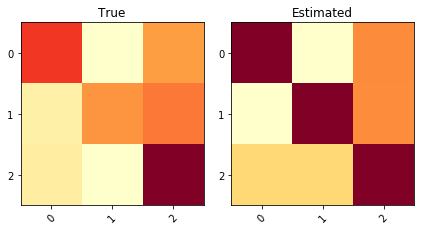

KL divergence: 0.2229	Pearson Correlation between diagonals: -0.1327


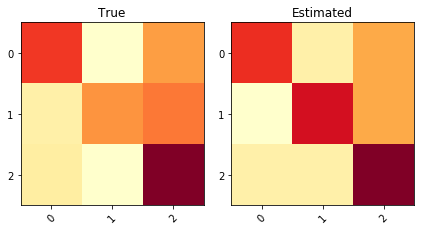

KL divergence: 0.1488	Pearson Correlation between diagonals: 0.7454


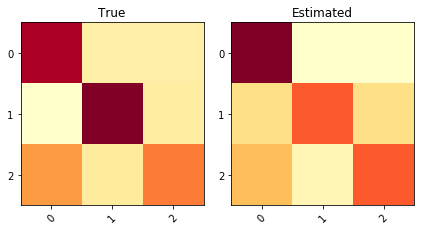

KL divergence: 0.1513	Pearson Correlation between diagonals: 0.3240


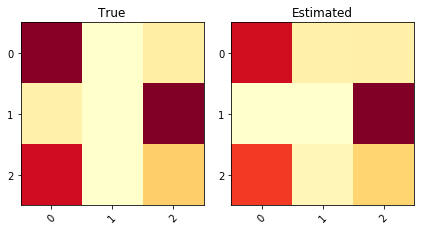

KL divergence: 0.1639	Pearson Correlation between diagonals: 0.9992


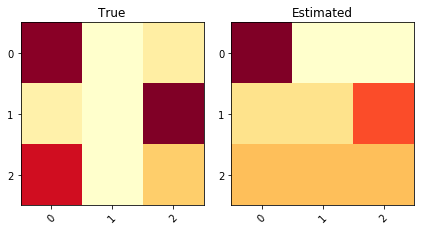

KL divergence: 0.3853	Pearson Correlation between diagonals: 0.9933


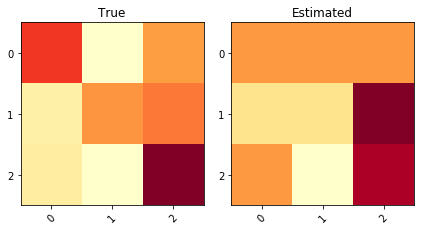

KL divergence: 0.2924	Pearson Correlation between diagonals: 0.9999


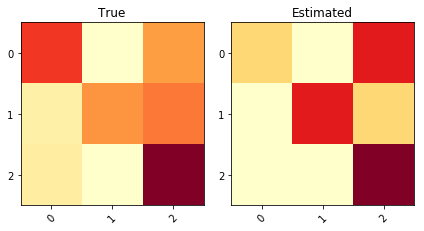

KL divergence: 0.1896	Pearson Correlation between diagonals: 0.4447


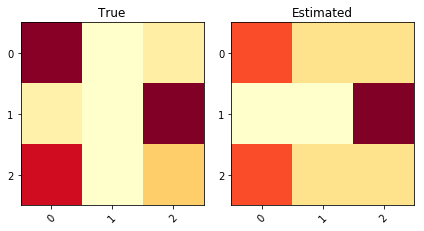

KL divergence: 0.3040	Pearson Correlation between diagonals: 0.9999


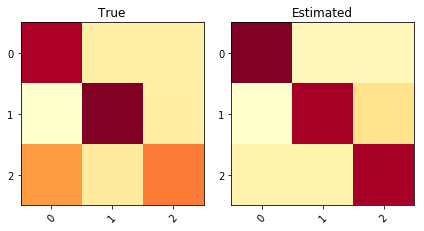

KL divergence: 0.1220	Pearson Correlation between diagonals: 0.3326


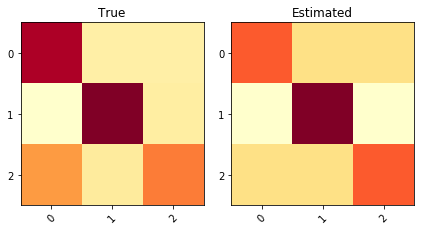

KL divergence: 0.1423	Pearson Correlation between diagonals: 0.6573


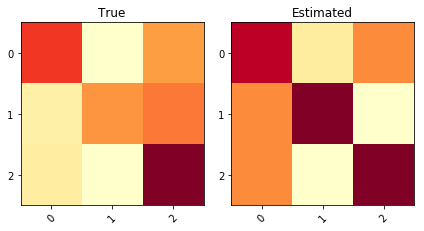

KL divergence: 0.3230	Pearson Correlation between diagonals: 0.1270


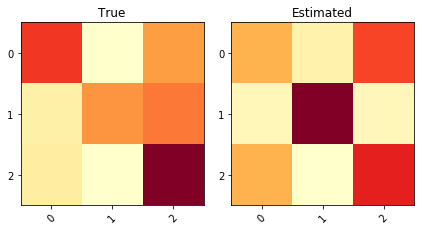

KL divergence: 0.3016	Pearson Correlation between diagonals: -0.2958


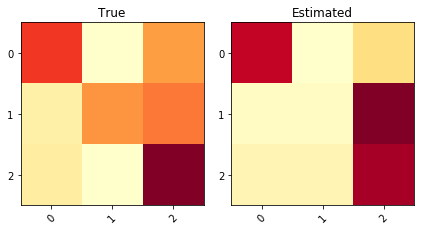

KL divergence: 0.2024	Pearson Correlation between diagonals: 0.8368


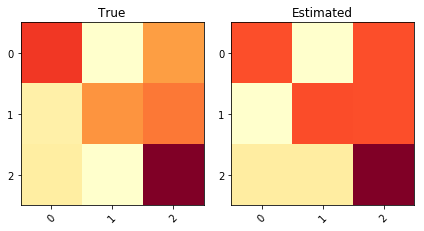

KL divergence: 0.1605	Pearson Correlation between diagonals: 0.9225


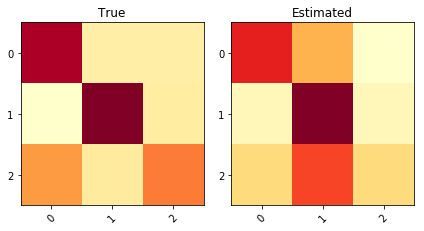

KL divergence: 0.2223	Pearson Correlation between diagonals: 0.9889


/users/fmena/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.626374 |     0.626374 |     0.236337 |                   nan |       0.192491 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
A result
 +----+-------------------------+------------------------+
|    |   ACC imiting Annotator |   CE imiting Annotator |
|----+-------------------------+------------------------|
|  0 |                0.688195 |               0.837098 |
+----+-------------------------+------------------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.650794 |     0.650794 |

In [29]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours (1) multiples runs***
Train


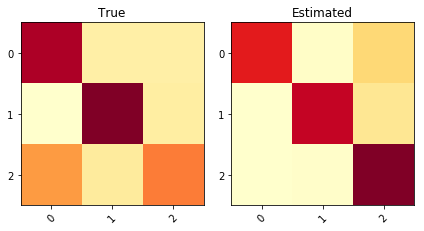

KL divergence: 0.7059	Pearson Correlation between diagonals: -0.8182


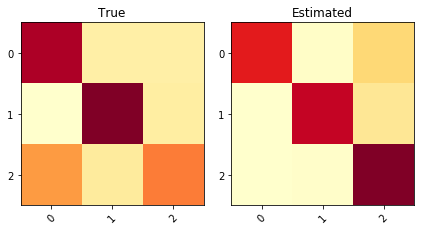

KL divergence: 0.7065	Pearson Correlation between diagonals: -0.8154


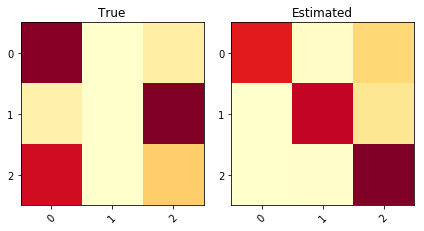

KL divergence: 1.9476	Pearson Correlation between diagonals: -0.6040


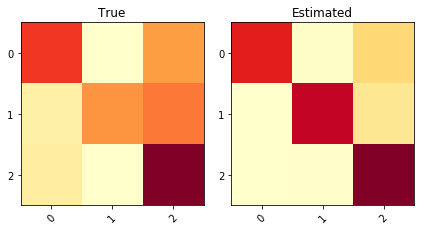

KL divergence: 0.3500	Pearson Correlation between diagonals: 0.6855


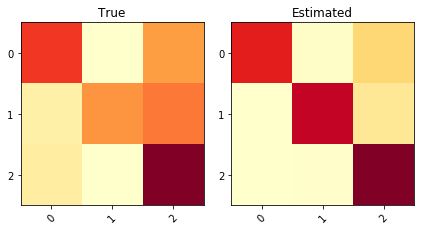

KL divergence: 0.3521	Pearson Correlation between diagonals: 0.6780


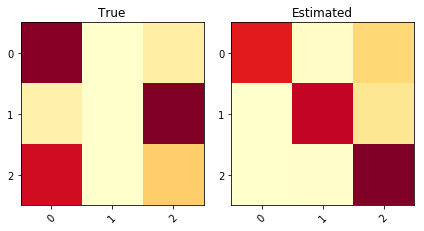

KL divergence: 1.9496	Pearson Correlation between diagonals: -0.6067


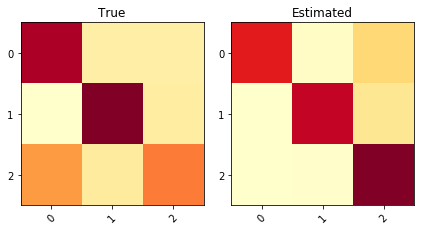

KL divergence: 0.7049	Pearson Correlation between diagonals: -0.8235


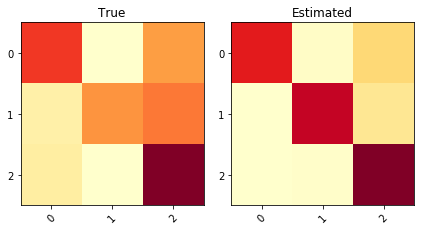

KL divergence: 0.3492	Pearson Correlation between diagonals: 0.6889


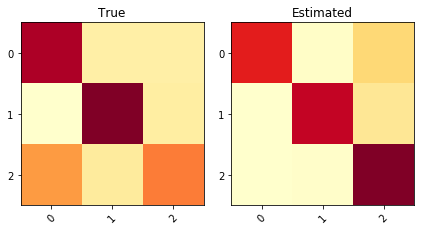

KL divergence: 0.7073	Pearson Correlation between diagonals: -0.8092


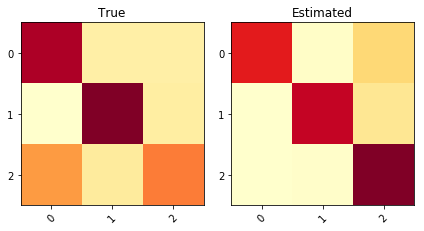

KL divergence: 0.7063	Pearson Correlation between diagonals: -0.8163


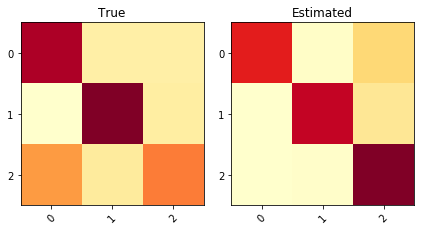

KL divergence: 0.7071	Pearson Correlation between diagonals: -0.8115


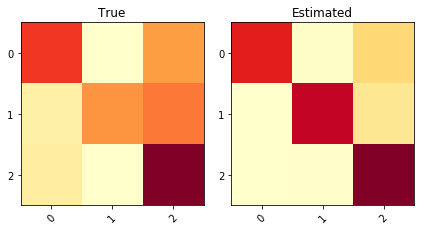

KL divergence: 0.3502	Pearson Correlation between diagonals: 0.6846


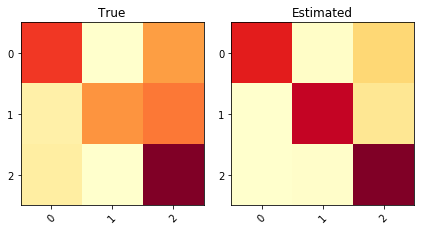

KL divergence: 0.3509	Pearson Correlation between diagonals: 0.6818


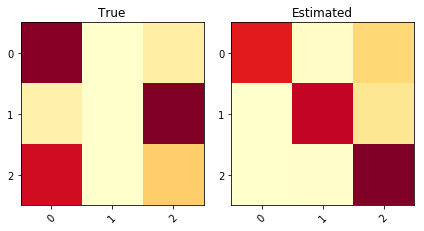

KL divergence: 1.9496	Pearson Correlation between diagonals: -0.6067


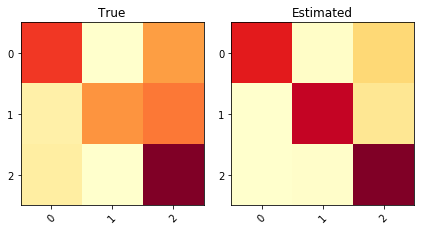

KL divergence: 0.3497	Pearson Correlation between diagonals: 0.6867
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.888482      0.888482      0.762259              0.0410437        0.203967
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.604776                0.802971
====  =======================  ======================
Test


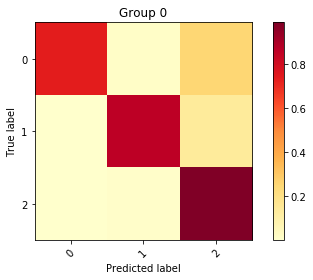

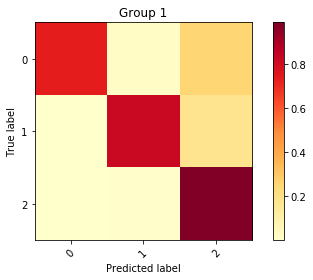

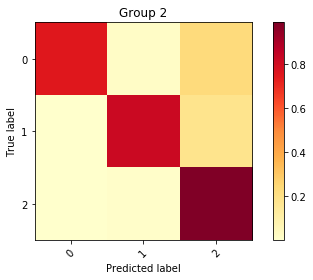

Inertia: 0.0005296690893980364
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.438225    4382   0.368957     0.861599   0.156321            0.924644    0.710623      0.710623
   1         1  0.299955    2999   0.396681     0.847162   0.173656            0.916431    0.665446      0.665446
   2         2  0.26182     2618   0.395006     0.852298   0.166383            0.919706    0.664225      0.664225
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.894994      0.89

In [21]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


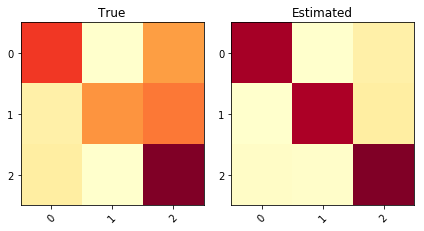

KL divergence: 0.3197	Pearson Correlation between diagonals: 0.9608


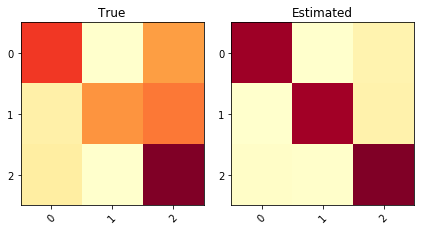

KL divergence: 0.3841	Pearson Correlation between diagonals: 0.9493


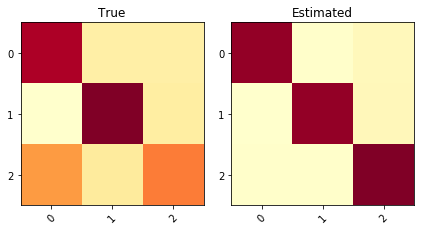

KL divergence: 0.5048	Pearson Correlation between diagonals: -0.9710


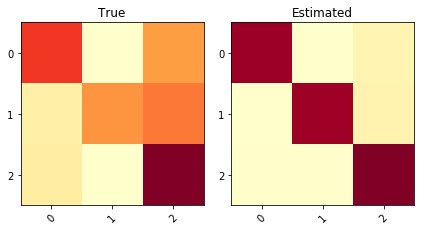

KL divergence: 0.4093	Pearson Correlation between diagonals: 0.9434


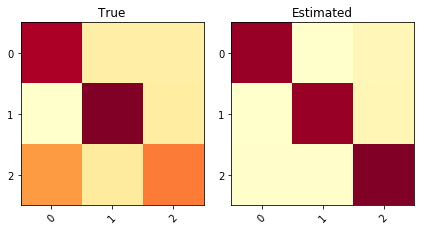

KL divergence: 0.4663	Pearson Correlation between diagonals: -0.9848


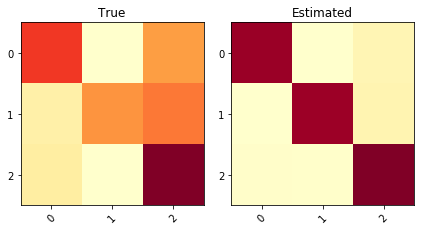

KL divergence: 0.4370	Pearson Correlation between diagonals: 0.9358


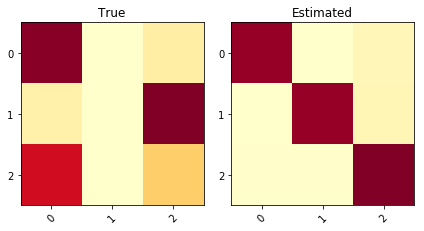

KL divergence: 1.7187	Pearson Correlation between diagonals: -0.2349


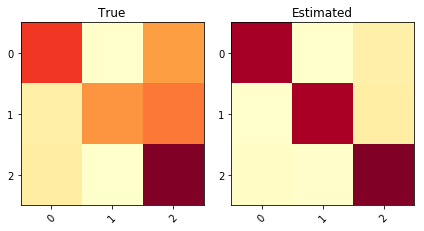

KL divergence: 0.3291	Pearson Correlation between diagonals: 0.9592


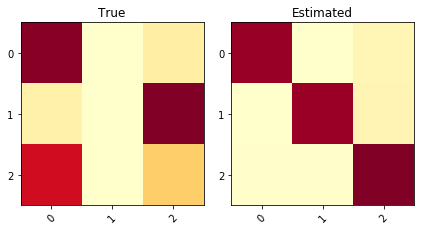

KL divergence: 1.6654	Pearson Correlation between diagonals: -0.2099


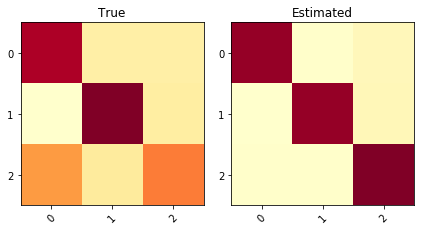

KL divergence: 0.4928	Pearson Correlation between diagonals: -0.9778


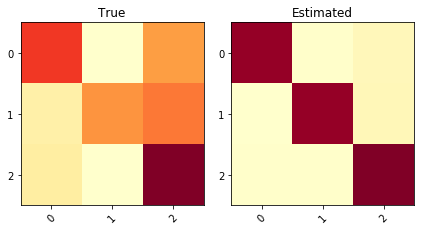

KL divergence: 0.5147	Pearson Correlation between diagonals: 0.9119


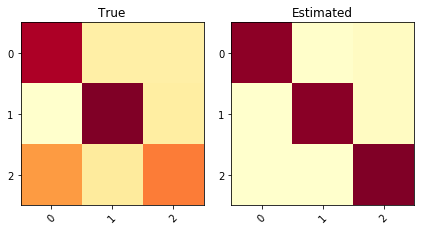

KL divergence: 0.5861	Pearson Correlation between diagonals: -0.9191


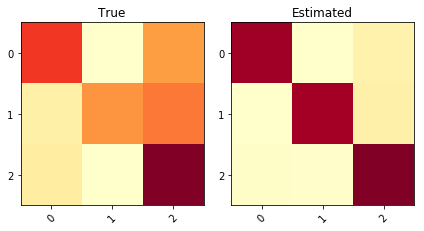

KL divergence: 0.3636	Pearson Correlation between diagonals: 0.9528


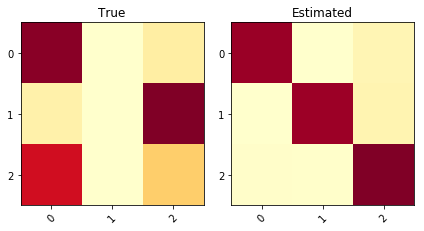

KL divergence: 1.6369	Pearson Correlation between diagonals: -0.1985


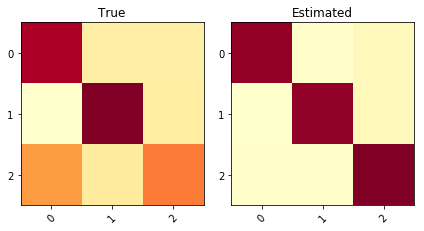

KL divergence: 0.5135	Pearson Correlation between diagonals: -0.9675
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.748474      0.748474      0.711648               0.214823        0.196764
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.612067                0.799046
====  =======================  ======================
Test


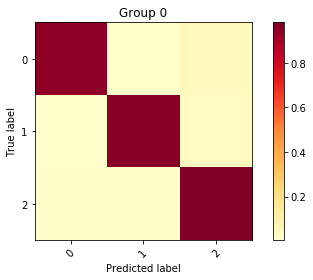

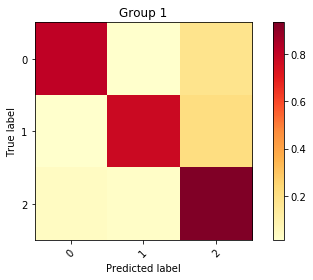

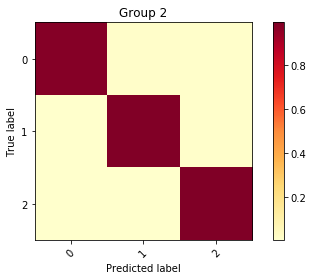

Inertia: 0.024073545006103814
A result
 ====  ========  =======  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups     Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  =======  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.45524    4552  0.175542      0.961901  0.0389491            0.980647    0.703297      0.703297
   1         1  0.25206    2520  0.470367      0.83902   0.178653             0.913384    0.648352      0.648352
   2         2  0.2927     2926  0.0812579     0.986159  0.0139481            0.993042    0.735043      0.735043
====  ========  =======  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.741148      0.741148
===

In [22]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (3) multiples runs***
Train


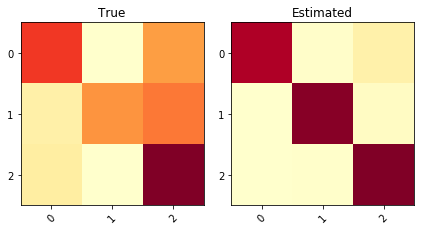

KL divergence: 0.8141	Pearson Correlation between diagonals: 0.3096


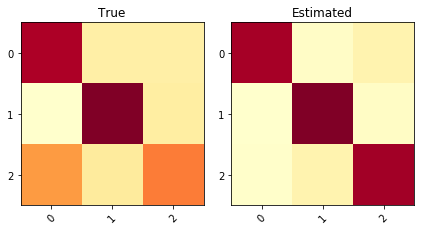

KL divergence: 0.5041	Pearson Correlation between diagonals: 0.5681


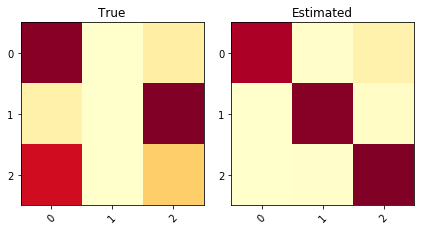

KL divergence: 3.0540	Pearson Correlation between diagonals: -0.9032


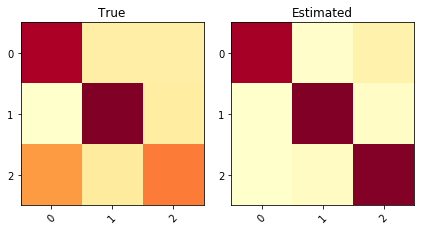

KL divergence: 0.6890	Pearson Correlation between diagonals: -0.2024


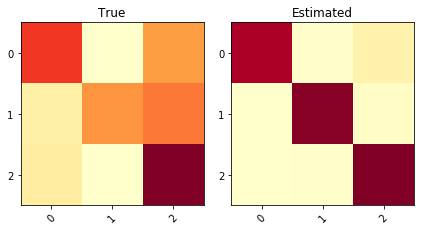

KL divergence: 0.8413	Pearson Correlation between diagonals: 0.2823


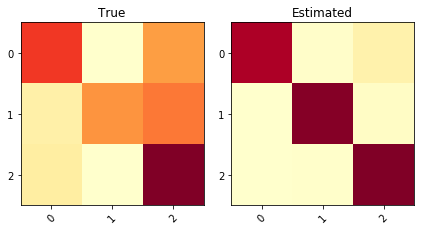

KL divergence: 0.8367	Pearson Correlation between diagonals: 0.2760


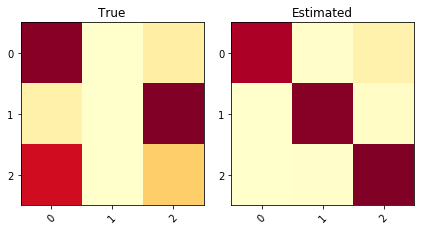

KL divergence: 3.0532	Pearson Correlation between diagonals: -0.9032


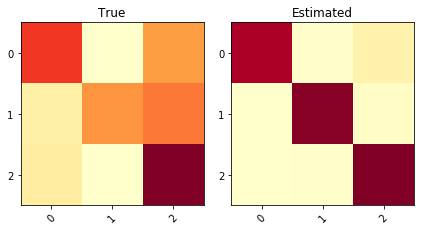

KL divergence: 0.8396	Pearson Correlation between diagonals: 0.2798


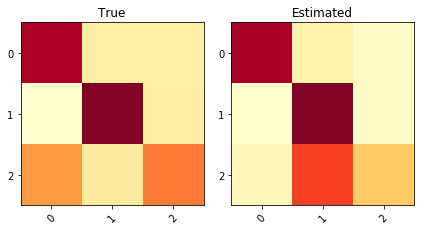

KL divergence: 0.3310	Pearson Correlation between diagonals: 0.9968


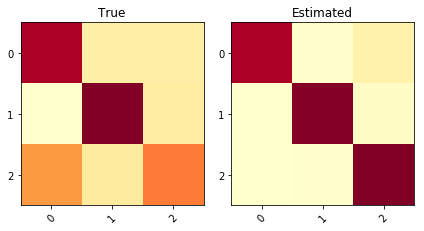

KL divergence: 0.9599	Pearson Correlation between diagonals: -0.4541


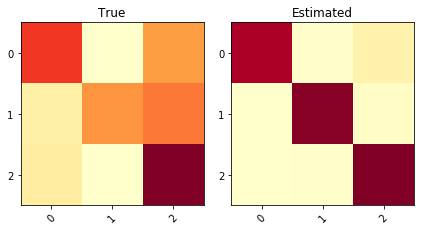

KL divergence: 0.8418	Pearson Correlation between diagonals: 0.2824


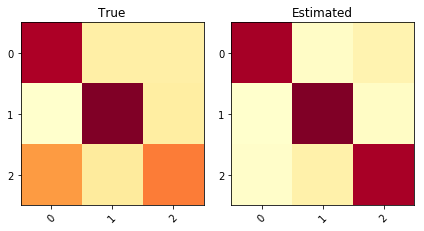

KL divergence: 0.4850	Pearson Correlation between diagonals: 0.6645


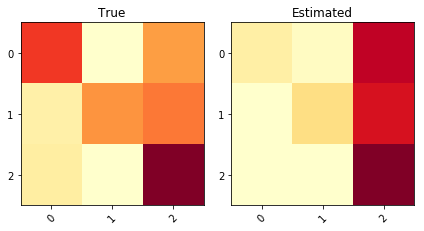

KL divergence: 0.5046	Pearson Correlation between diagonals: 0.8796


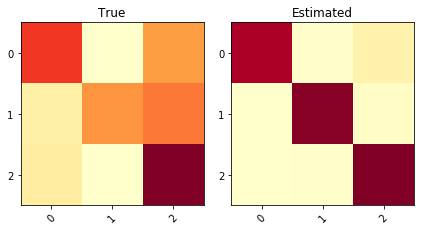

KL divergence: 0.8411	Pearson Correlation between diagonals: 0.2825


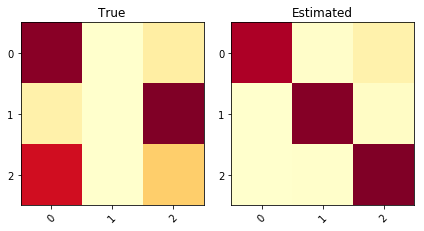

KL divergence: 3.0217	Pearson Correlation between diagonals: -0.9058
A result
 ====  ======  ==========  ============  ============  =====================  ==============
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr    Average RMSE
====  ======  ==========  ============  ============  =====================  ==============
   0  Global    0.897843      0.897843       1.17888              0.0740151       0.0895135
====  ======  ==========  ============  ============  =====================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.623039                0.757881
====  =======================  ======================
Test


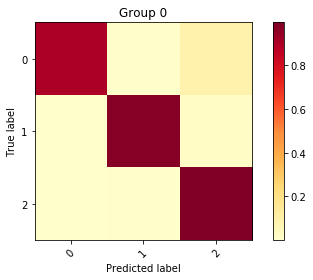

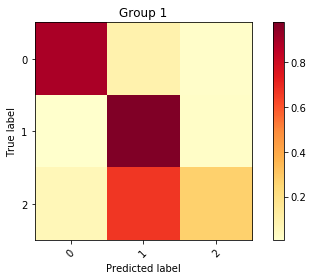

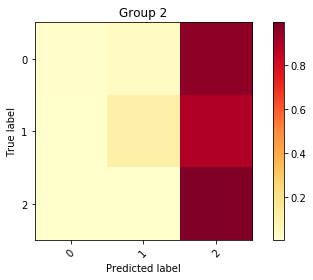

Inertia: 0.3102724564572175
A result
 ====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I similar % (JS)    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
   0         0  0.797915    7979   0.162836     0.95818    0.043676            0.978433    0.901099      0.901099
   1         1  0.044038     440   0.432018     0.713986   0.480421            0.802756    0.666667      0.666667
   2         2  0.158047    1580   0.186655     0.369064   2.43063             0.425557    0.333333      0.333333
====  ========  ========  ======  =========  ===========  =========  ==================  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.901099      0.90109

In [23]:
evaluate = Evaluation_metrics(gMixture3,'our1') 
aux = gMixture3.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (3) multiples runs***") #lambda = random

print("Train")
Z_train_pred = gMixture3.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture3.get_confusionM()
y_o_groups = gMixture3.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture3.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 20 )

In [37]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6295811518324608
